In [63]:

# Core libraries
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
from abc import ABC, abstractmethod
import logging
from itertools import product
import itertools

# Data source
import yfinance as yf

# Statistical analysis
from scipy import stats
from scipy.stats import jarque_bera, normaltest

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Time series analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Table formatting
from tabulate import tabulate

# Optional imports with error handling
try:
    from statsmodels.tsa.stattools import kpss
    KPSS_AVAILABLE = True
except ImportError:
    print("ATTENZIONE: Test KPSS non disponibile.")
    KPSS_AVAILABLE = False

try:
    from statsmodels.stats.diagnostic import acorr_ljungbox
except ImportError:
    try:
        from statsmodels.tsa.stattools import acorr_ljungbox
    except ImportError:
        print("ATTENZIONE: acorr_ljungbox non disponibile. Test Ljung-Box disabilitato.")
        acorr_ljungbox = None

try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    TSAPLOTS_AVAILABLE = True
except ImportError:
    print("ATTENZIONE: statsmodels.graphics.tsaplots non disponibile. Grafici ACF/PACF disabilitati.")
    TSAPLOTS_AVAILABLE = False

try:
    import pandas_datareader.data as web
    import statsmodels.api as sm
    FF_AVAILABLE = True
except ImportError:
    FF_AVAILABLE = False

# Suppress warnings
warnings.filterwarnings('ignore')

In [64]:
# Tickers e periodo di analisi
tickers = ['XOM', 'CVX', 'KO', 'PEP', 'PFE', 'JNJ']
start_date = '2014-05-31'
end_date   = '2024-05-31'

# Download prezzi adjusted (Close auto-adjusted da yfinance)
df_list = []
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date,
                       progress=False, auto_adjust=True)[['Close']]
    data.rename(columns={'Close': ticker}, inplace=True)
    df_list.append(data)

# Concatenazione in unico DataFrame
prices = pd.concat(df_list, axis=1)
prices.dropna(inplace=True)

print(f"Dati scaricati per il periodo {start_date} - {end_date}")
print(f"Forma del dataset: {prices.shape}")
print(f"\nPrimi 5 prezzi:")
print(prices.head())


Dati scaricati per il periodo 2014-05-31 - 2024-05-31
Forma del dataset: (2517, 6)

Primi 5 prezzi:
Price             XOM        CVX         KO        PEP        PFE        JNJ
Ticker            XOM        CVX         KO        PEP        PFE        JNJ
Date                                                                        
2014-06-02  62.592419  76.557617  28.677275  63.058628  18.029226  75.256111
2014-06-03  62.874260  76.770615  28.691317  63.309780  17.956400  75.469742
2014-06-04  62.655087  76.645325  28.628149  63.212173  17.986738  75.631775
2014-06-05  62.974464  77.378258  28.698341  63.450794  18.059565  76.029549
2014-06-06  63.632111  77.797989  28.768517  63.559235  17.853239  76.000061


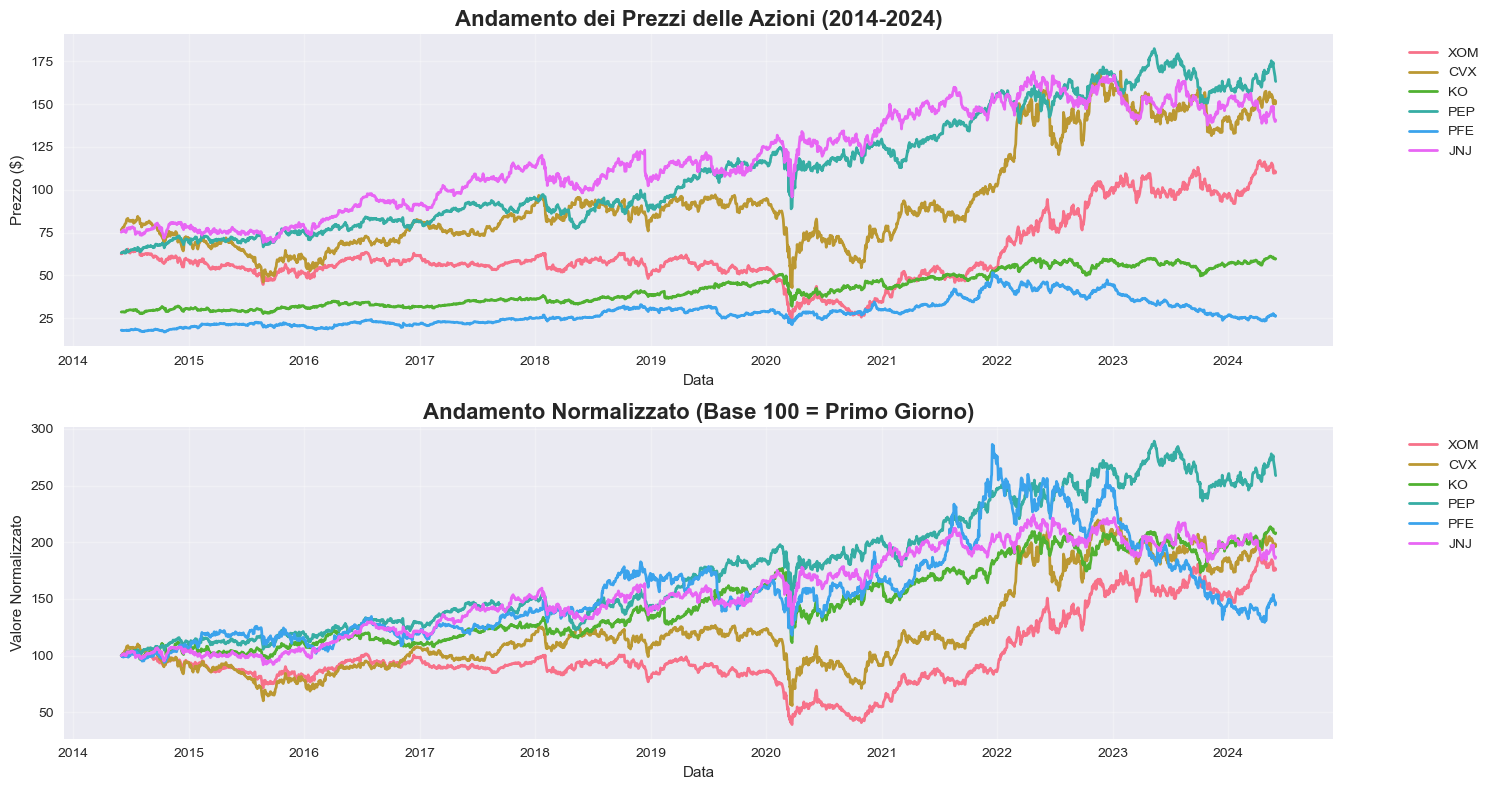


========== STATISTICHE DESCRITTIVE DEI PREZZI ==========
Price       XOM      CVX       KO      PEP      PFE      JNJ
Ticker      XOM      CVX       KO      PEP      PFE      JNJ
count   2517.00  2517.00  2517.00  2517.00  2517.00  2517.00
mean      62.98    94.28    42.04   111.60    28.16   117.93
std       20.19    30.65    10.03    34.23     7.34    28.59
min       24.58    42.92    27.70    63.04    16.96    69.22
25%       53.09    72.08    33.10    81.85    22.34    93.42
50%       57.17    85.48    39.63   105.93    26.73   115.19
75%       63.58    99.77    50.48   145.35    31.57   146.66
max      117.13   169.27    61.30   182.35    51.62   168.80

========== PERFORMANCE COMPLESSIVA (2014-2024) ==========
Rendimento totale per ogni titolo:
XOM: 75.98%
CVX: 97.74%
KO: 108.34%
PEP: 158.81%
PFE: 46.61%
JNJ: 86.96%

Migliore performer: ('PEP', 'PEP') (158.81%)
Peggiore performer: ('PFE', 'PFE') (46.61%)


In [65]:
# ========== ANDAMENTO DEI PREZZI DELLE AZIONI ==========
plt.figure(figsize=(15, 8))

# Plot dei prezzi assoluti
plt.subplot(2, 1, 1)
for ticker in tickers:
    plt.plot(prices.index, prices[ticker], label=ticker, linewidth=2)

plt.title('Andamento dei Prezzi delle Azioni (2014-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Prezzo ($)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot dei prezzi normalizzati (base 100)
plt.subplot(2, 1, 2)
normalized_prices = (prices / prices.iloc[0]) * 100

for ticker in tickers:
    plt.plot(normalized_prices.index, normalized_prices[ticker], label=ticker, linewidth=2)

plt.title('Andamento Normalizzato (Base 100 = Primo Giorno)', fontsize=16, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Valore Normalizzato')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n========== STATISTICHE DESCRITTIVE DEI PREZZI ==========")
print(prices.describe().round(2))

print(f"\n========== PERFORMANCE COMPLESSIVA (2014-2024) ==========")
total_return = ((prices.iloc[-1] / prices.iloc[0]) - 1) * 100
print("Rendimento totale per ogni titolo:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {float(total_return.iloc[i]):.2f}%")

print(f"\nMigliore performer: {total_return.idxmax()} ({float(total_return.iloc[total_return.argmax()]):.2f}%)")
print(f"Peggiore performer: {total_return.idxmin()} ({float(total_return.iloc[total_return.argmin()]):.2f}%)")


CumReturn      CAGR
Ticker                     
XOM      0.759785  0.058188
CVX      0.977393  0.070606
KO       1.083378  0.076214
PEP      1.588087  0.099832
PFE      0.466100  0.039029
JNJ      0.869561  0.064615

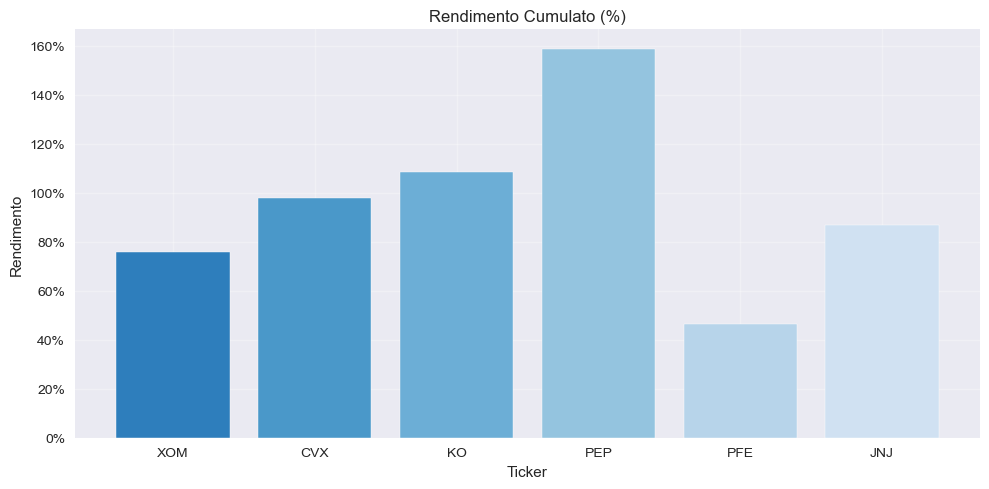

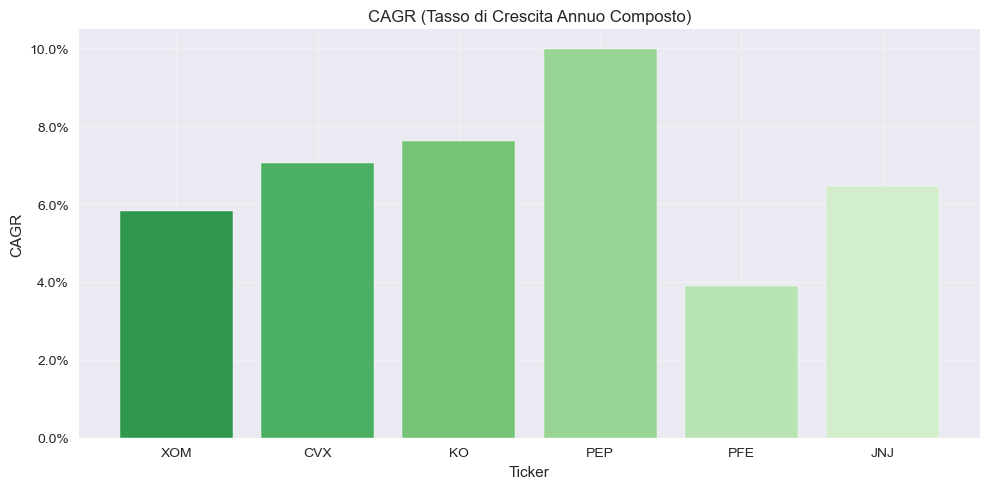

In [66]:
# prices: ['Price', 'Ticker']
# Prendiamo solo il livello 'Ticker'
prices_simple = prices.copy()
prices_simple.columns = prices_simple.columns.get_level_values('Ticker')

# Calcolo rendimento cumulato
cum_return = (prices_simple.iloc[-1] / prices_simple.iloc[0] - 1)

# Calcolo CAGR
n_years = (prices_simple.index[-1] - prices_simple.index[0]).days / 365.25
cagr = (prices_simple.iloc[-1] / prices_simple.iloc[0]) ** (1/n_years) - 1

# DataFrame dei risultati
results = pd.DataFrame({'CumReturn': cum_return, 'CAGR': cagr})

# Visualizzazione
display(results)

# === GRAFICI ===

plt.figure(figsize=(10, 5))
bars1 = plt.bar(results.index, results['CumReturn'], color=plt.cm.Blues_r(np.linspace(0.3, 0.8, len(results))))
plt.title("Rendimento Cumulato (%)")
plt.ylabel("Rendimento")
plt.xlabel("Ticker")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# CAGR - con matplotlib
plt.figure(figsize=(10, 5))
bars2 = plt.bar(results.index, results['CAGR'], color=plt.cm.Greens_r(np.linspace(0.3, 0.8, len(results))))
plt.title("CAGR (Tasso di Crescita Annuo Composto)")
plt.ylabel("CAGR")
plt.xlabel("Ticker")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


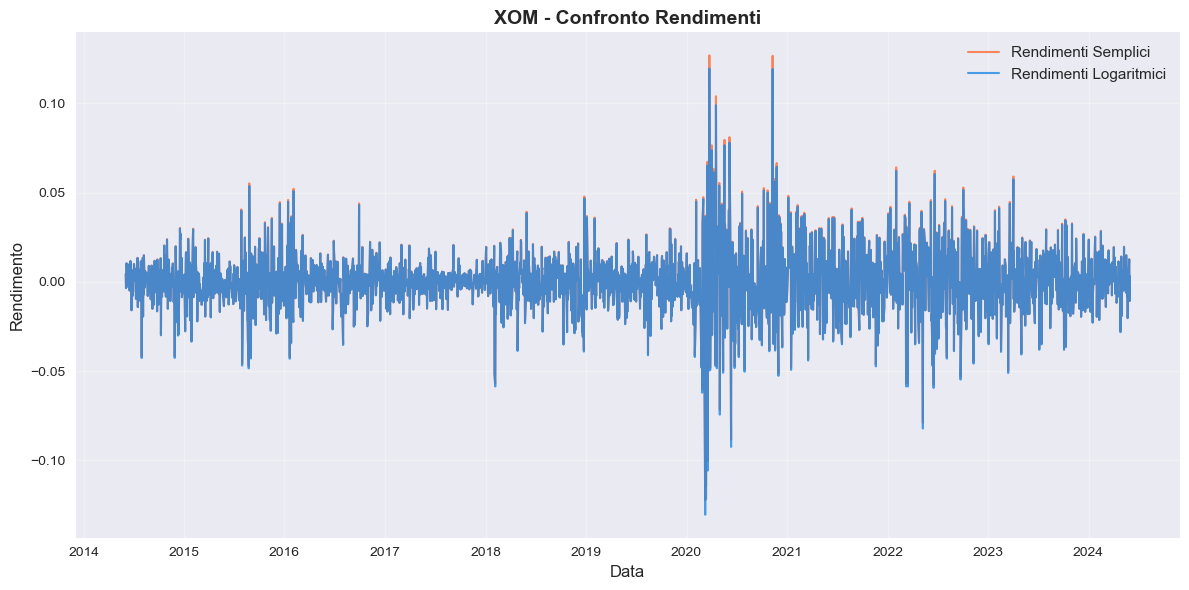

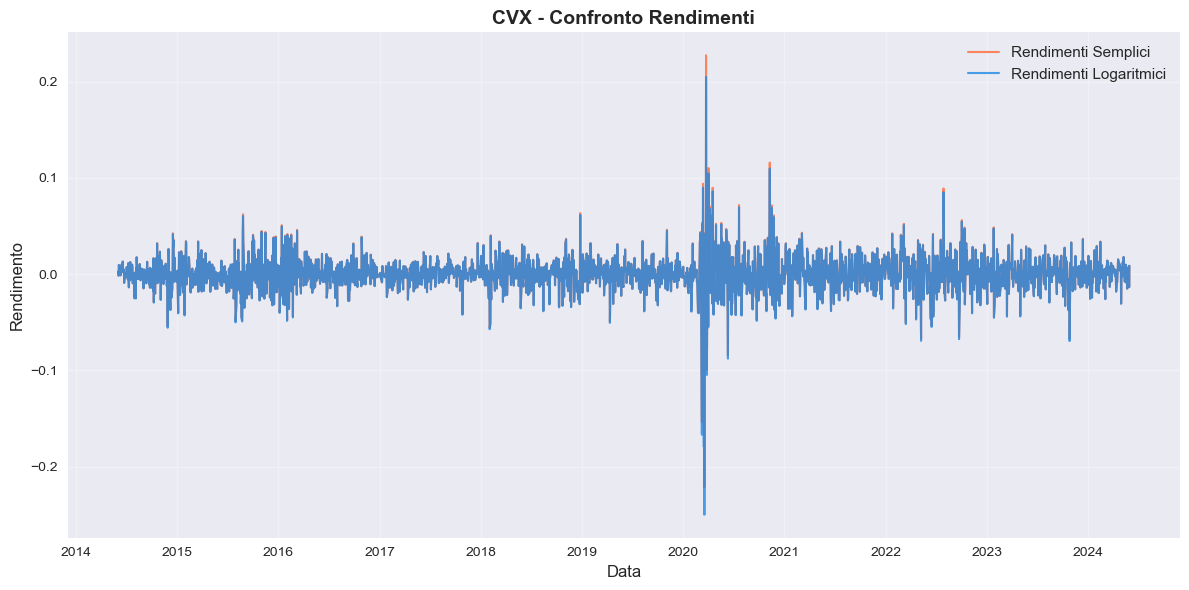

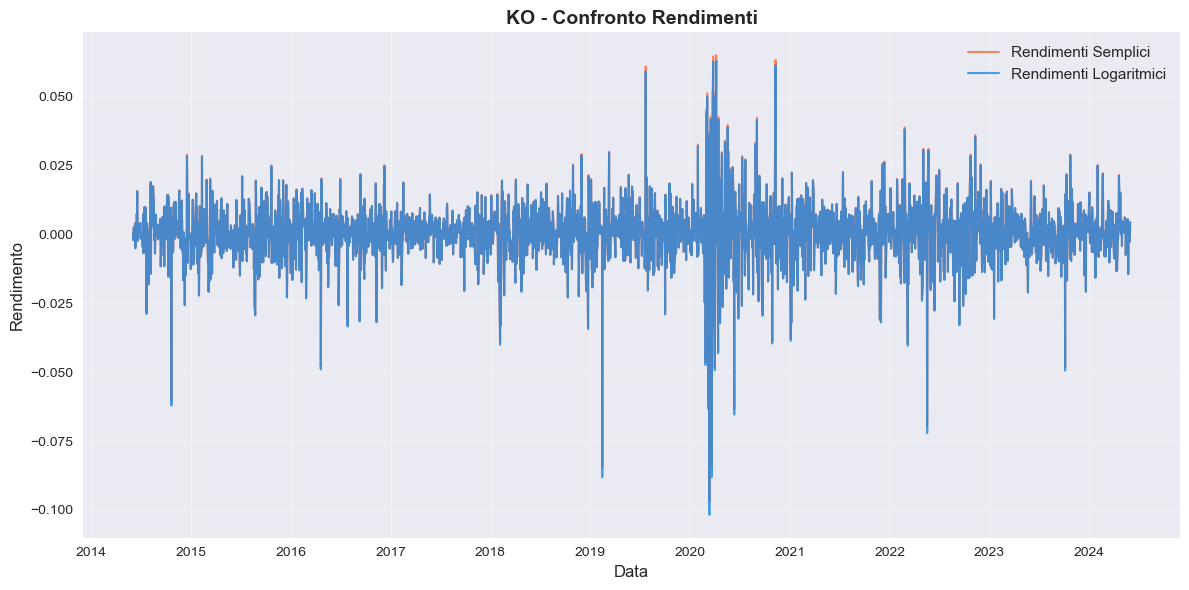

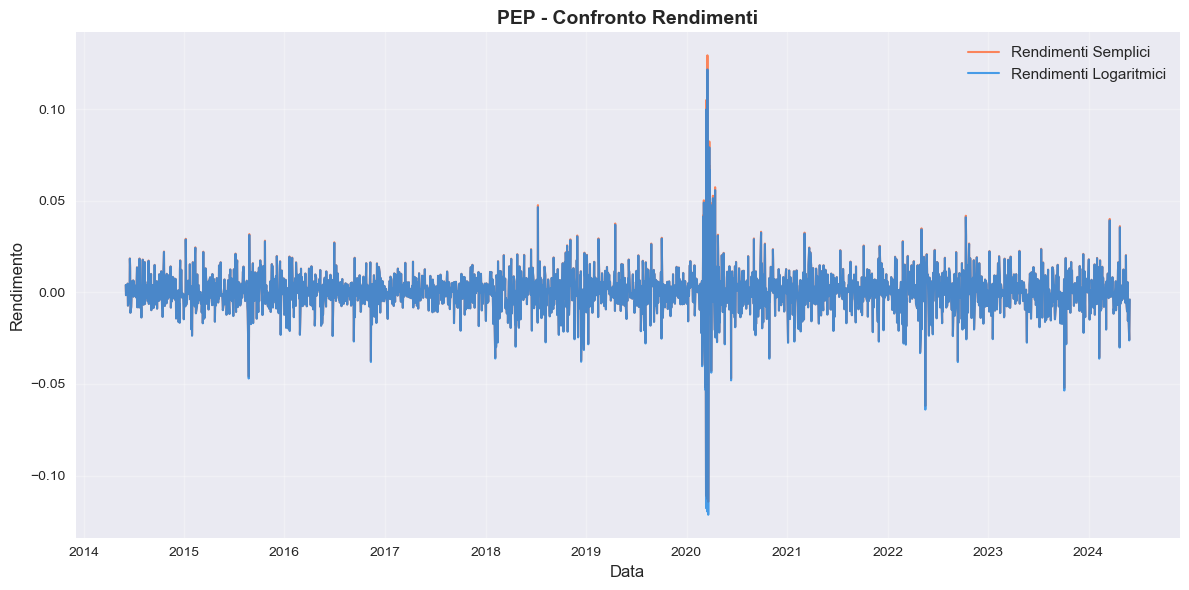

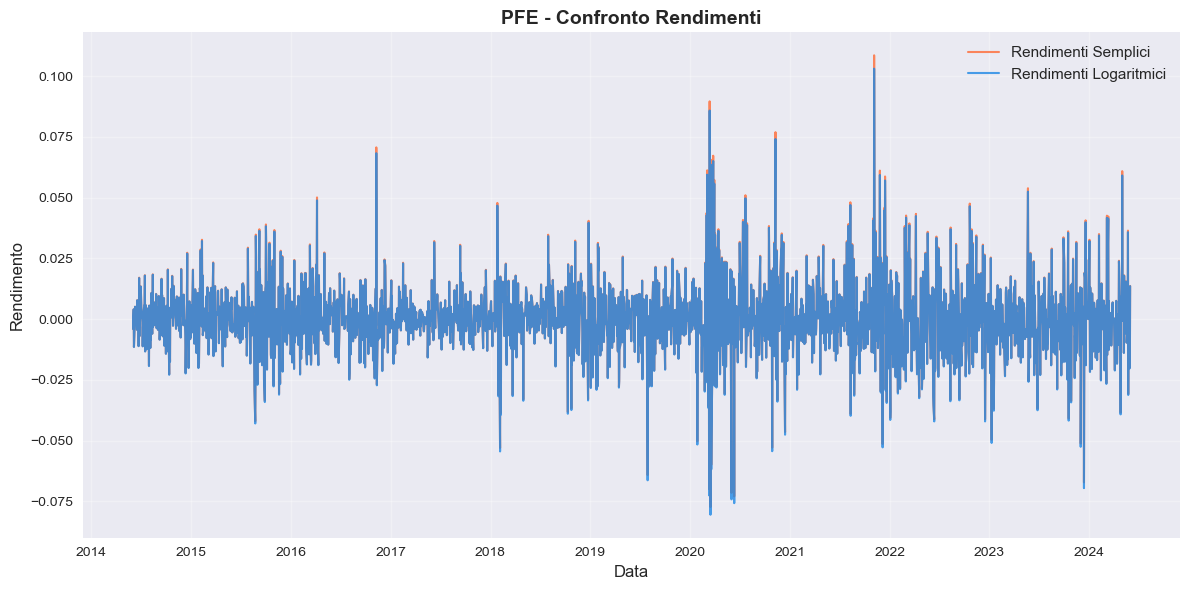

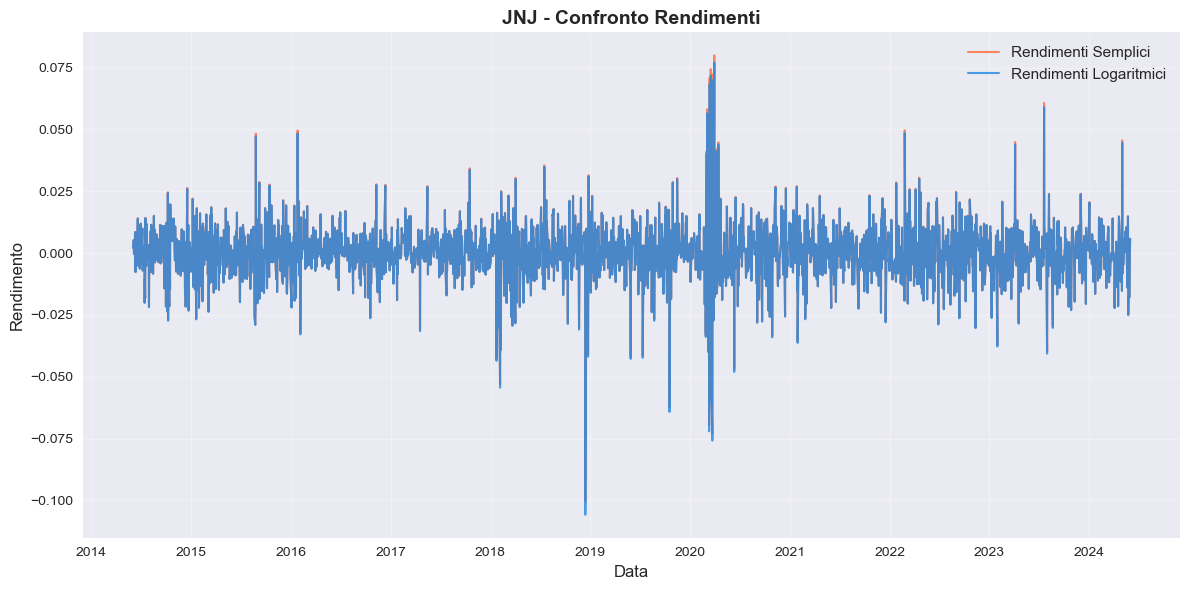

Statistiche descrittive delle differenze (Semplici - Logaritmici):
Price           XOM          CVX           KO          PEP          PFE  \
Ticker          XOM          CVX           KO          PEP          PFE   
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.000152     0.000175     0.000064     0.000068     0.000103   
std        0.000446     0.000907     0.000227     0.000333     0.000276   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.000008     0.000007     0.000003     0.000003     0.000005   
50%        0.000035     0.000034     0.000013     0.000016     0.000024   
75%        0.000127     0.000130     0.000047     0.000050     0.000089   
max        0.008143     0.028815     0.005003     0.007710     0.005497   

Price           JNJ  
Ticker          JNJ  
count   2516.000000  
mean       0.000065  
std        0.000220  
min        0.000000  
25%        0.000003  
50%        0.000015  
75%   

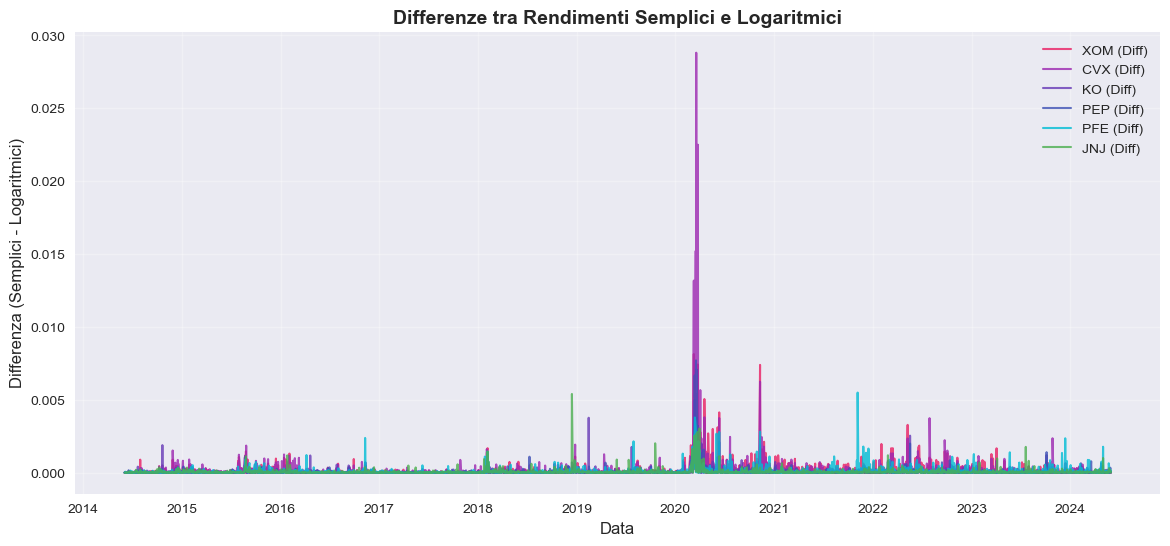

In [67]:
# Calcolo dei rendimenti
simple_ret = prices.pct_change().dropna()
log_ret = np.log(prices / prices.shift(1)).dropna()

# Creazione di un plot separato per ogni titolo
for ticker in tickers:
    plt.figure(figsize=(12, 6))

    # Plot dei rendimenti semplici e logaritmici
    plt.plot(simple_ret.index, simple_ret[ticker],
             label='Rendimenti Semplici',
             color='#FF6B35',
             alpha=0.8,
             linewidth=1.5)
    plt.plot(log_ret.index, log_ret[ticker],
             label='Rendimenti Logaritmici',
             color='#1E88E5',
             alpha=0.8,
             linewidth=1.5)

    plt.title(f'{ticker} - Confronto Rendimenti', fontsize=14, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Rendimento', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualizzazione delle differenze tra i due tipi di rendimenti
print("Statistiche descrittive delle differenze (Semplici - Logaritmici):")
differences = simple_ret - log_ret
print(differences.describe())

plt.figure(figsize=(14, 6))

# Colori  per ogni ticker
colors = ['#E91E63', '#9C27B0', '#673AB7', '#3F51B5', '#00BCD4', '#4CAF50']

for i, ticker in enumerate(tickers):
    color = colors[i % len(colors)]  # Usa i colori ciclicamente
    plt.plot(differences.index, differences[ticker],
             label=f'{ticker} (Diff)',
             color=color,
             alpha=0.8,
             linewidth=1.5)

plt.title('Differenze tra Rendimenti Semplici e Logaritmici', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Differenza (Semplici - Logaritmici)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

ANALISI DIAGNOSTICA DEI RENDIMENTI

GRAFICI DIAGNOSTICI PER OGNI TICKER
--------------------------------------------------

XOM:


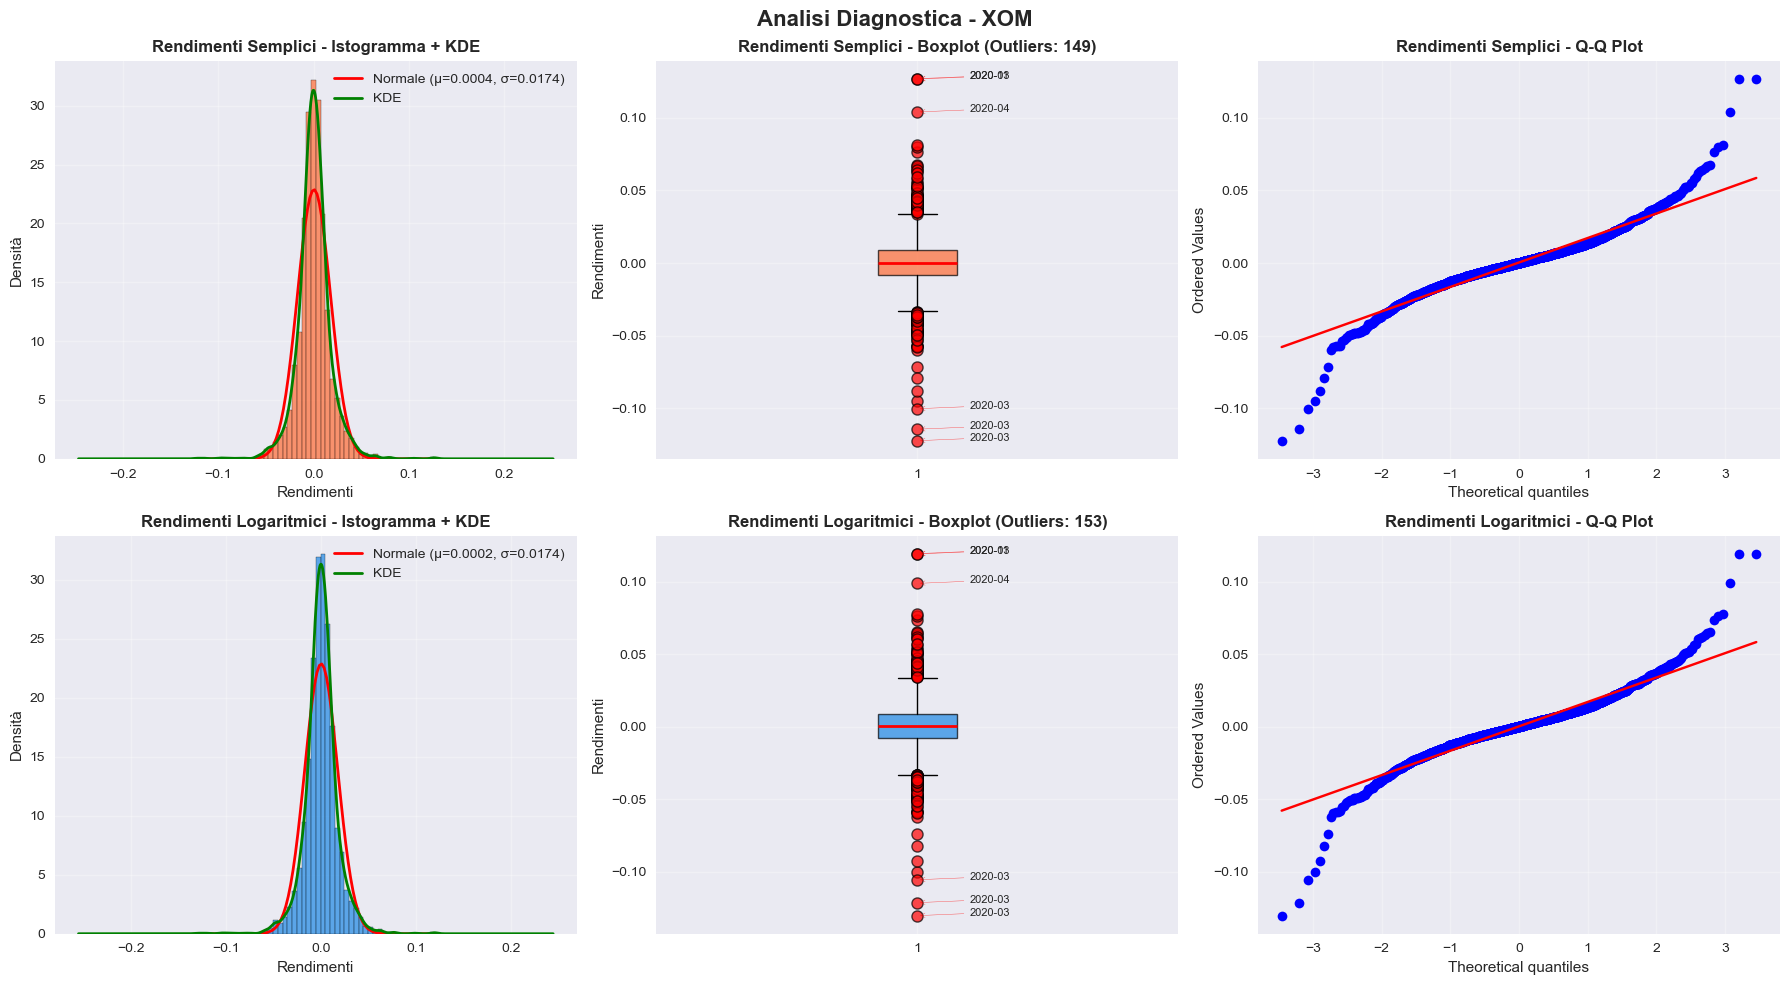


CVX:


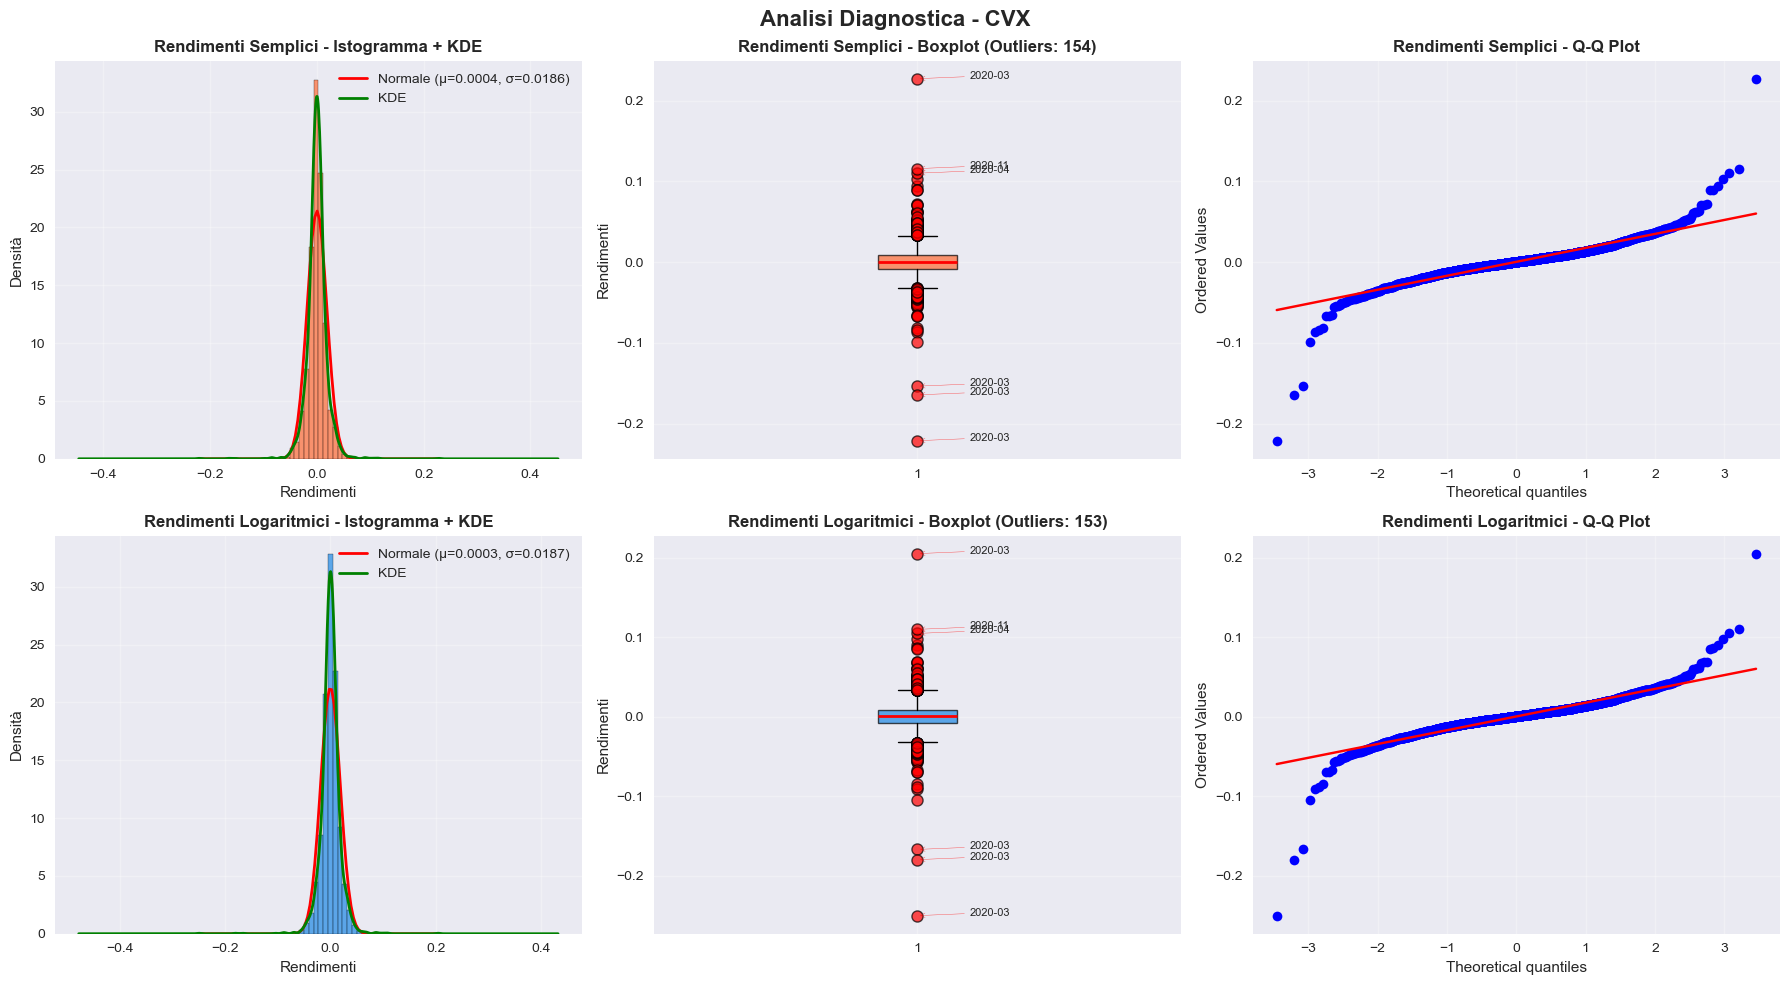


KO:


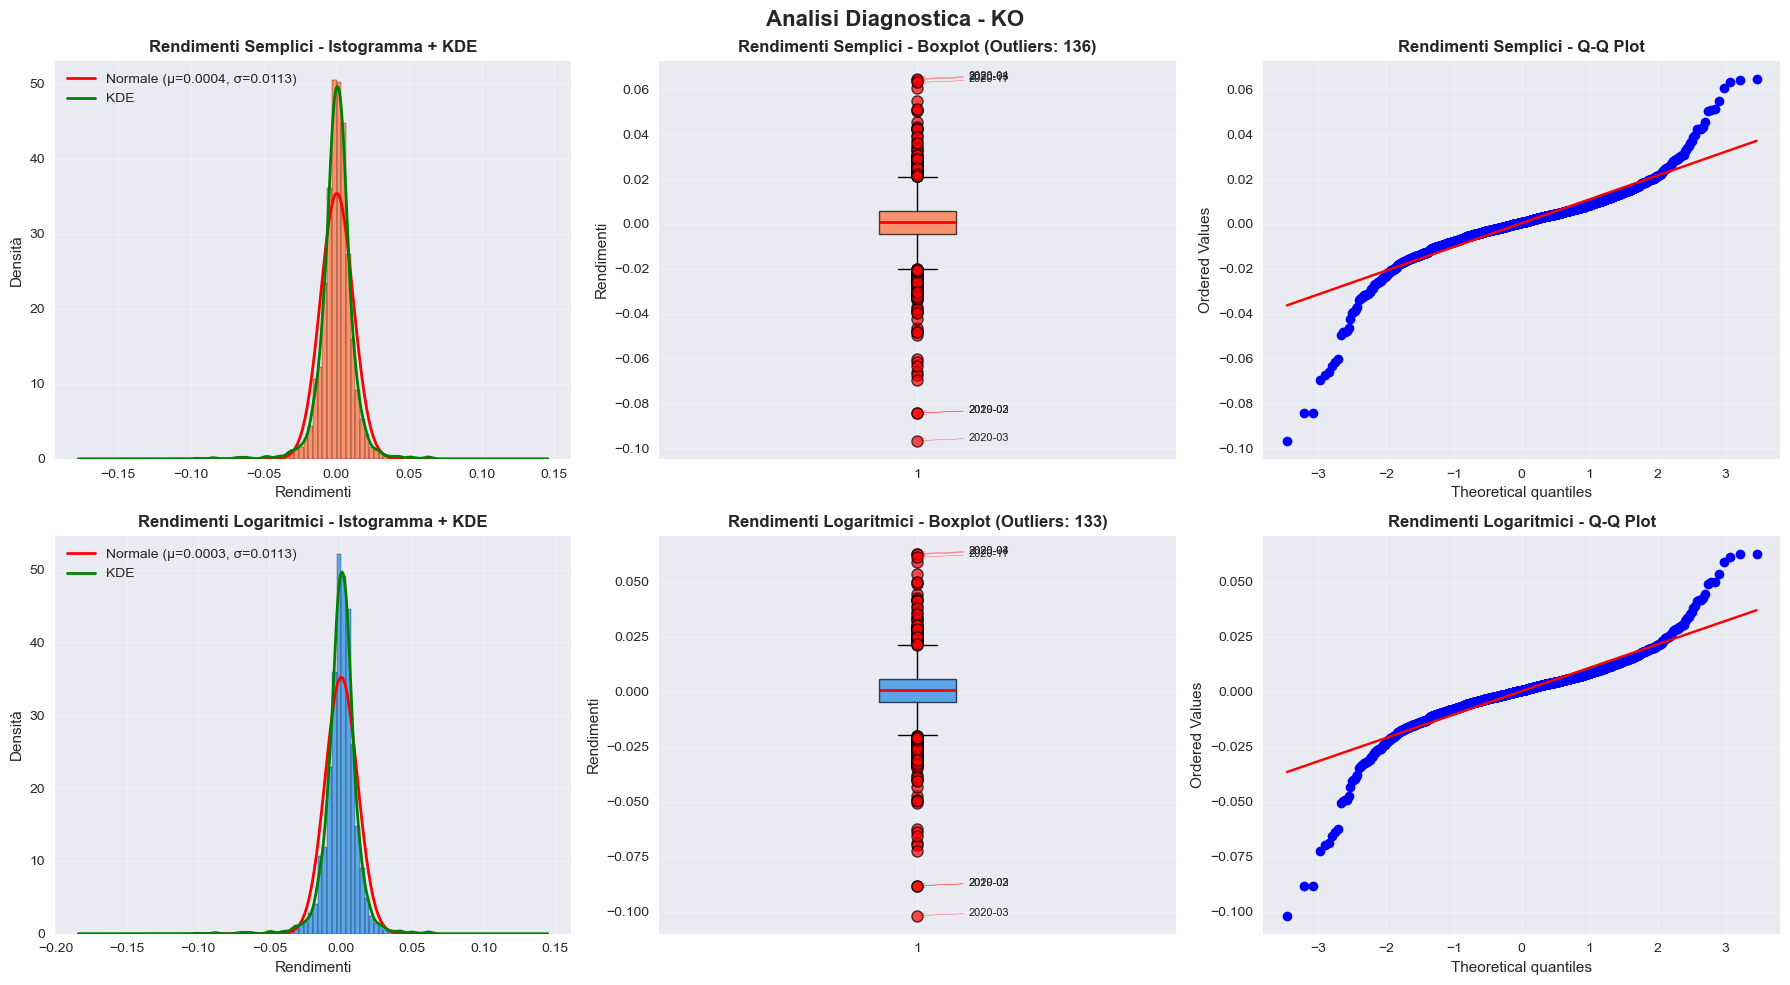


PEP:


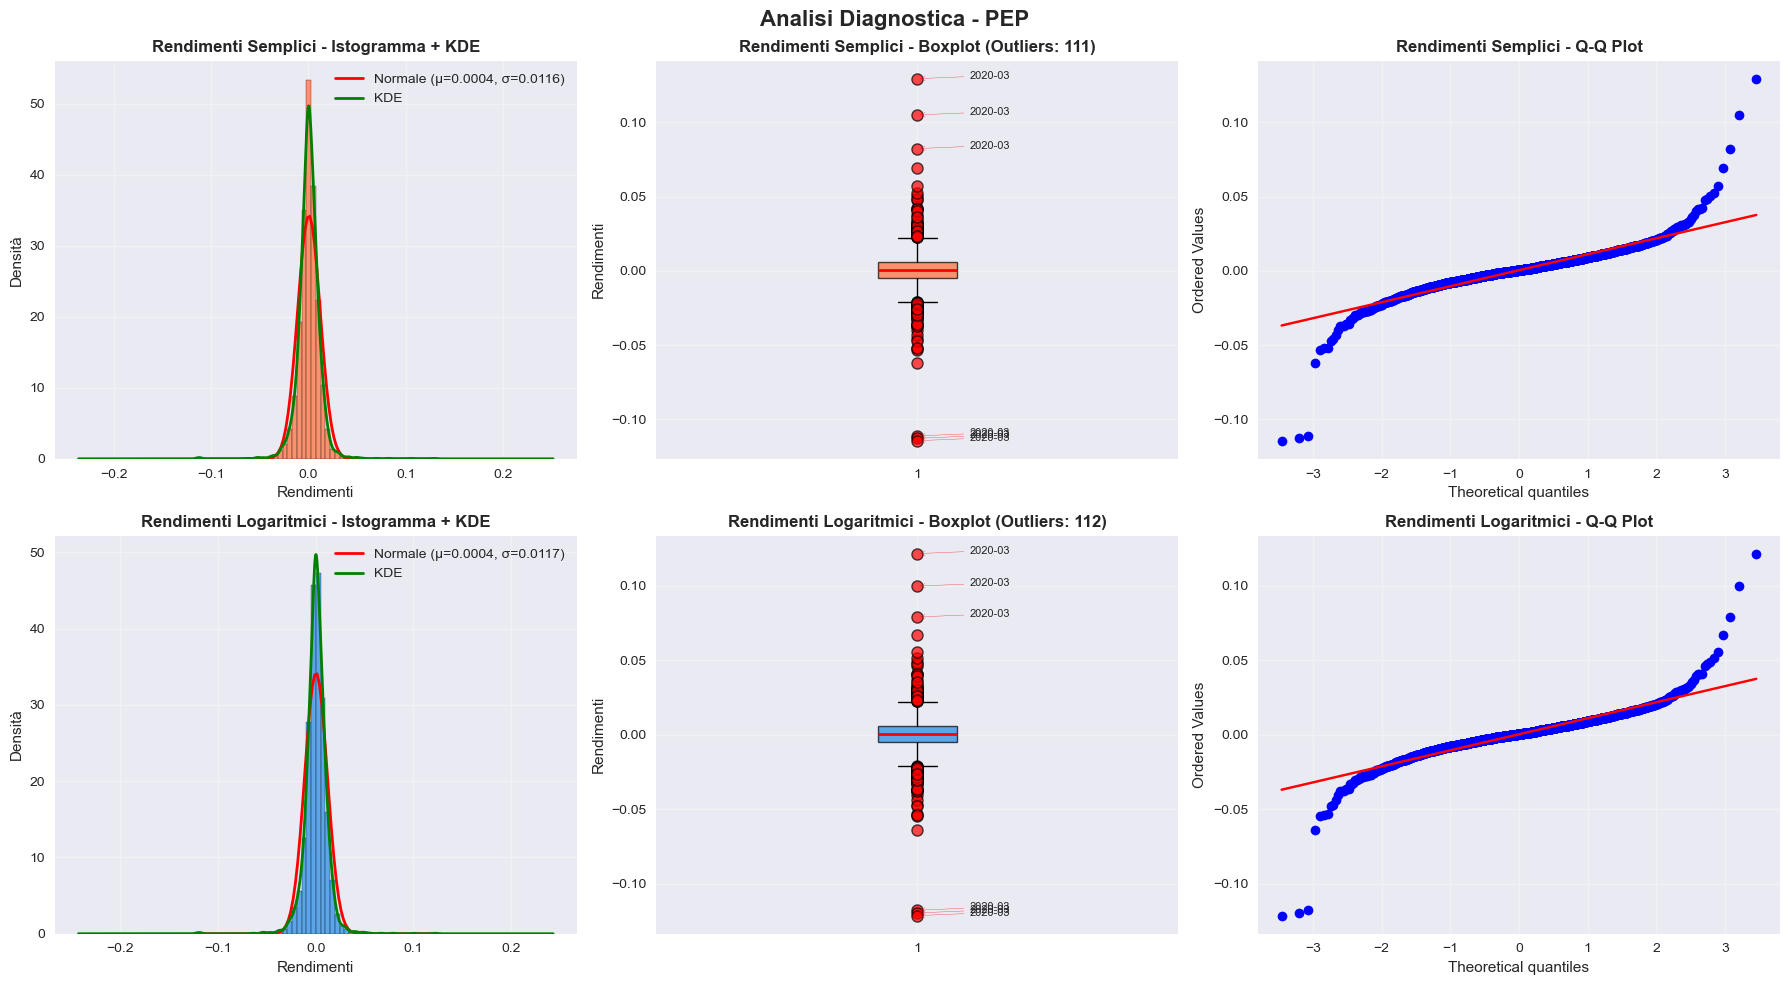


PFE:


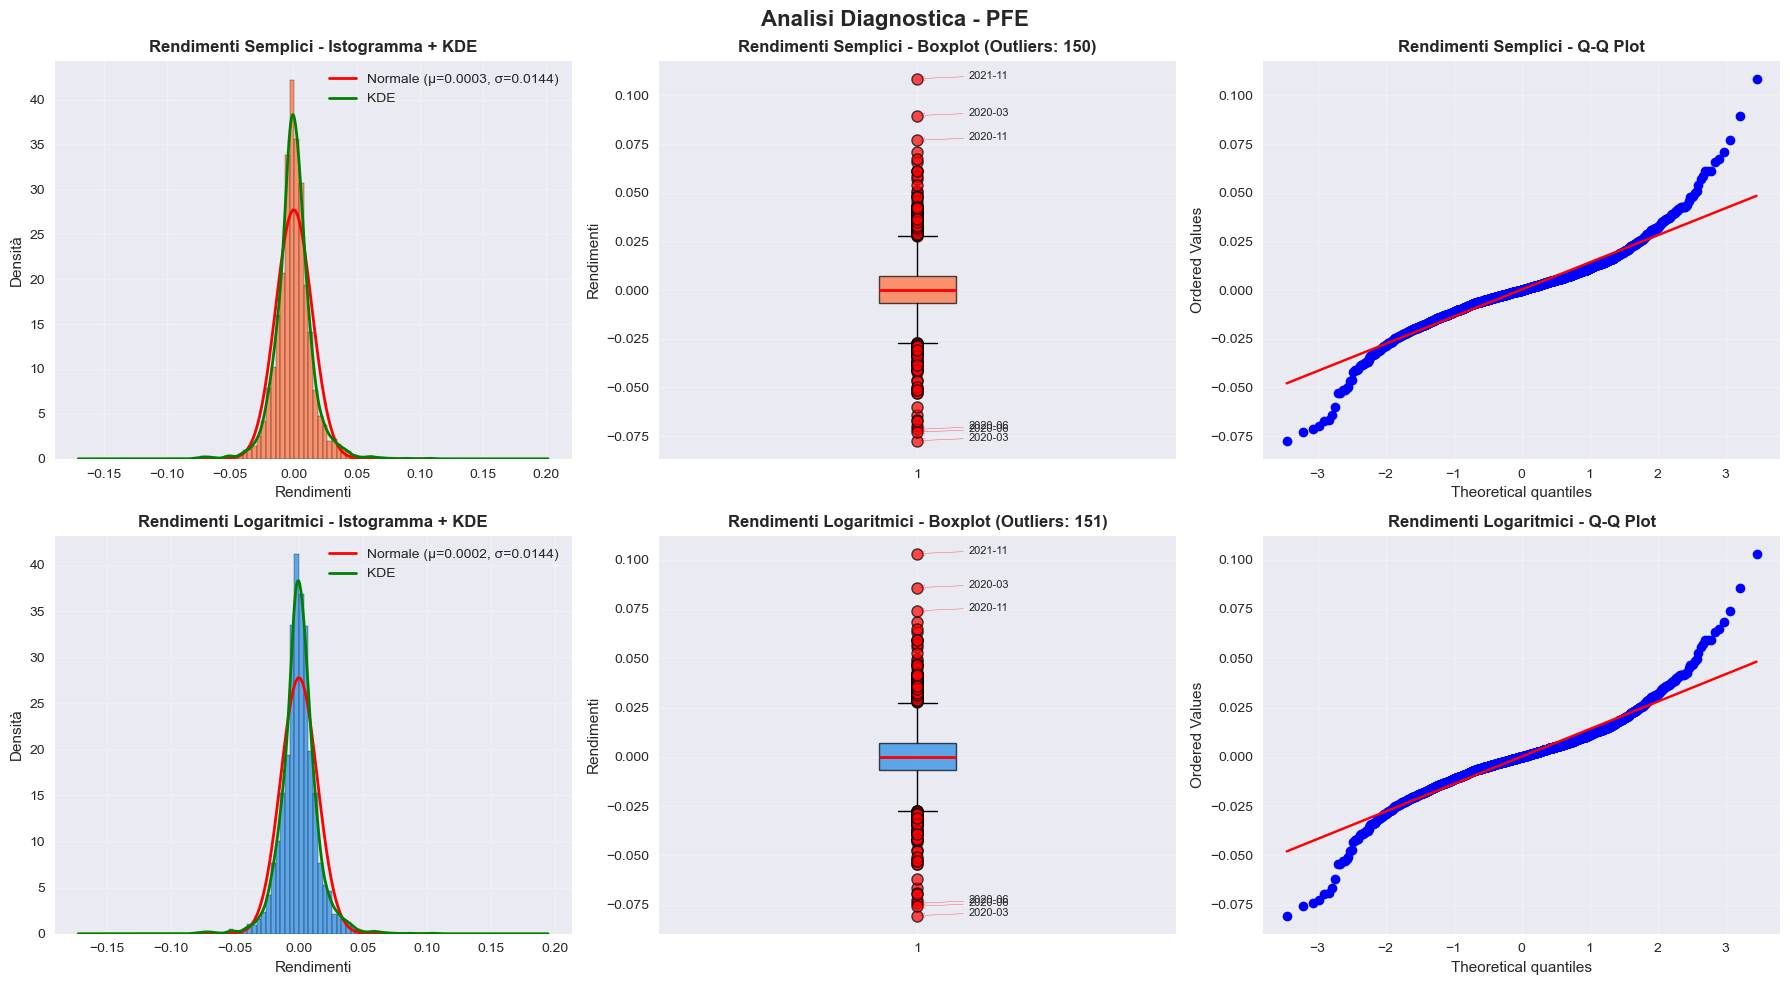


JNJ:


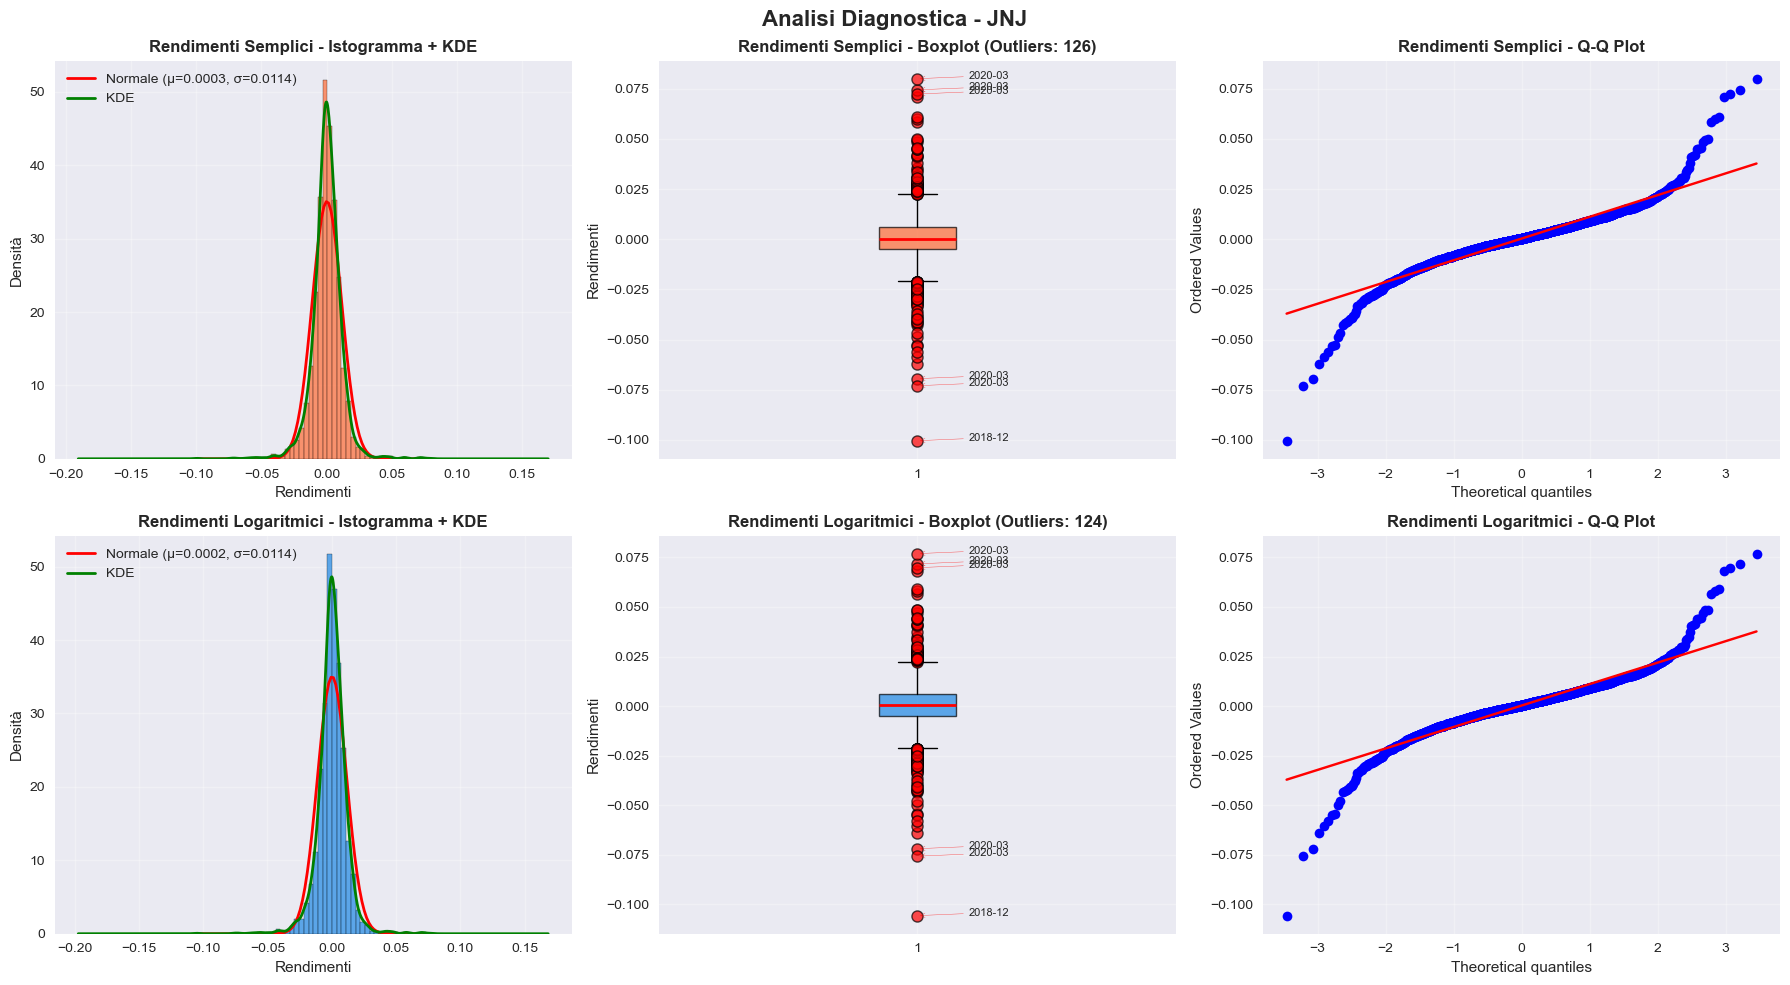


GRAFICI OUTLIERS SEPARATI PER RENDIMENTI SEMPLICI E LOGARITMICI


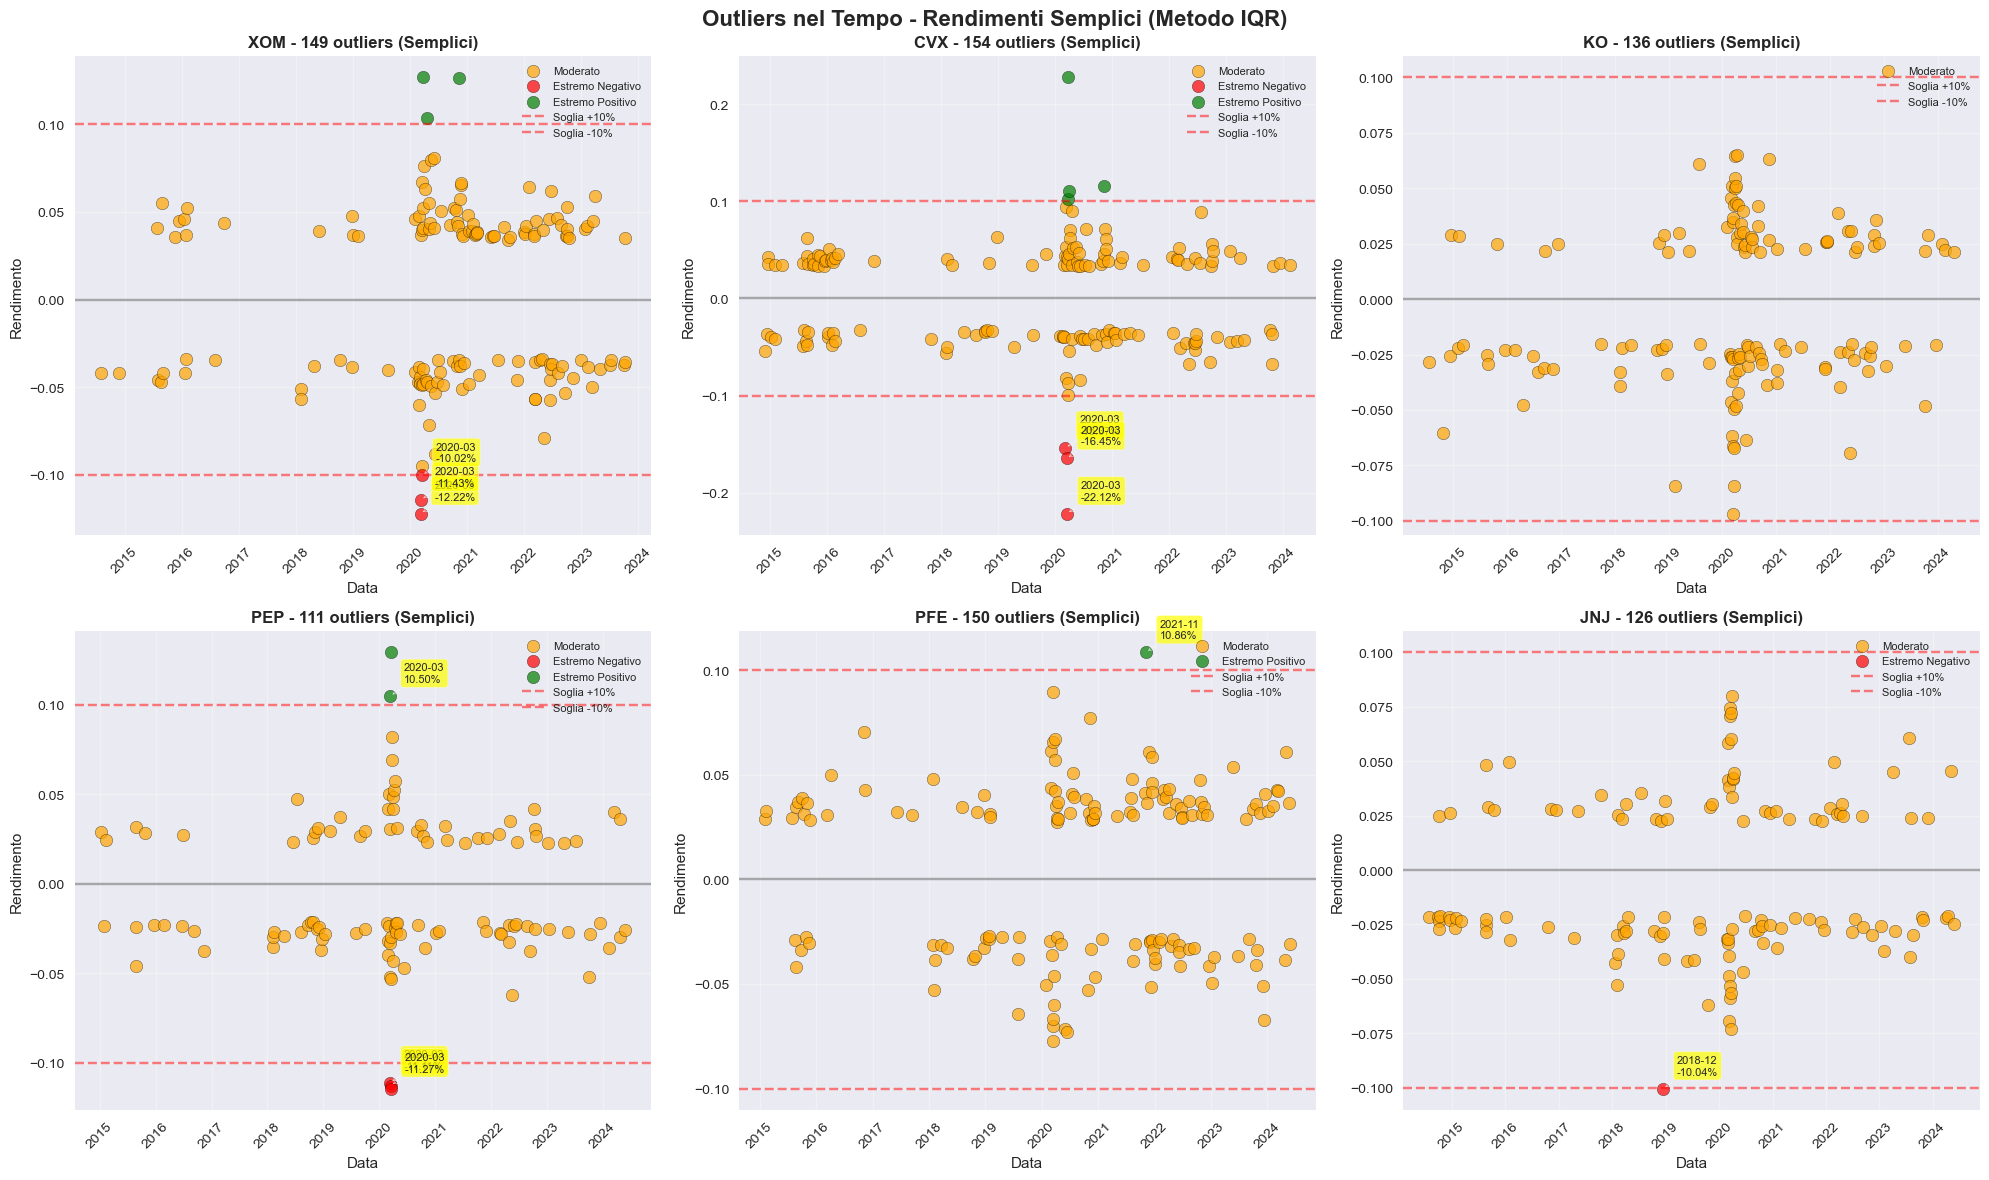

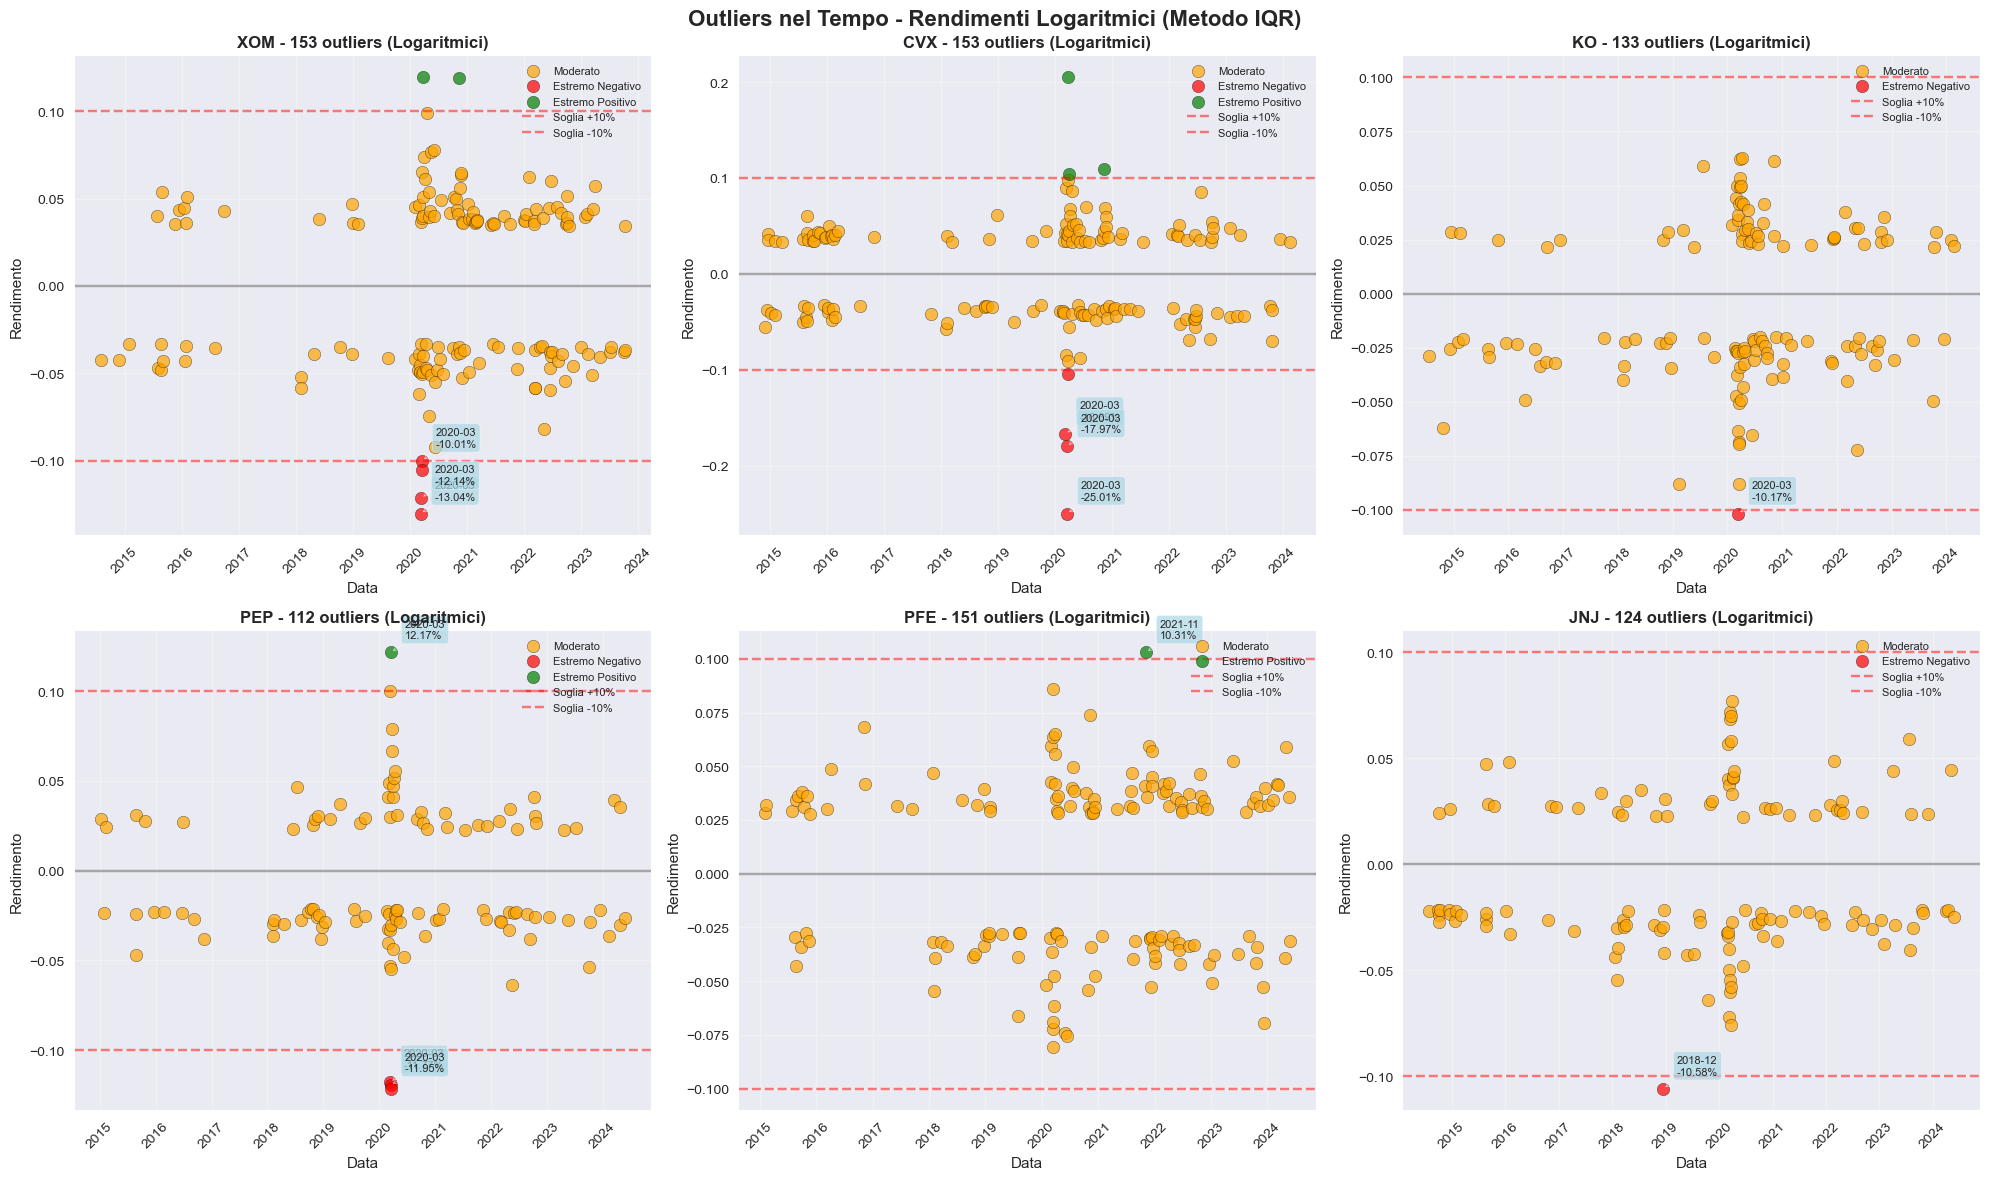


4-5. GRAFICI SERIE TEMPORALI CON SOGLIA 3σ


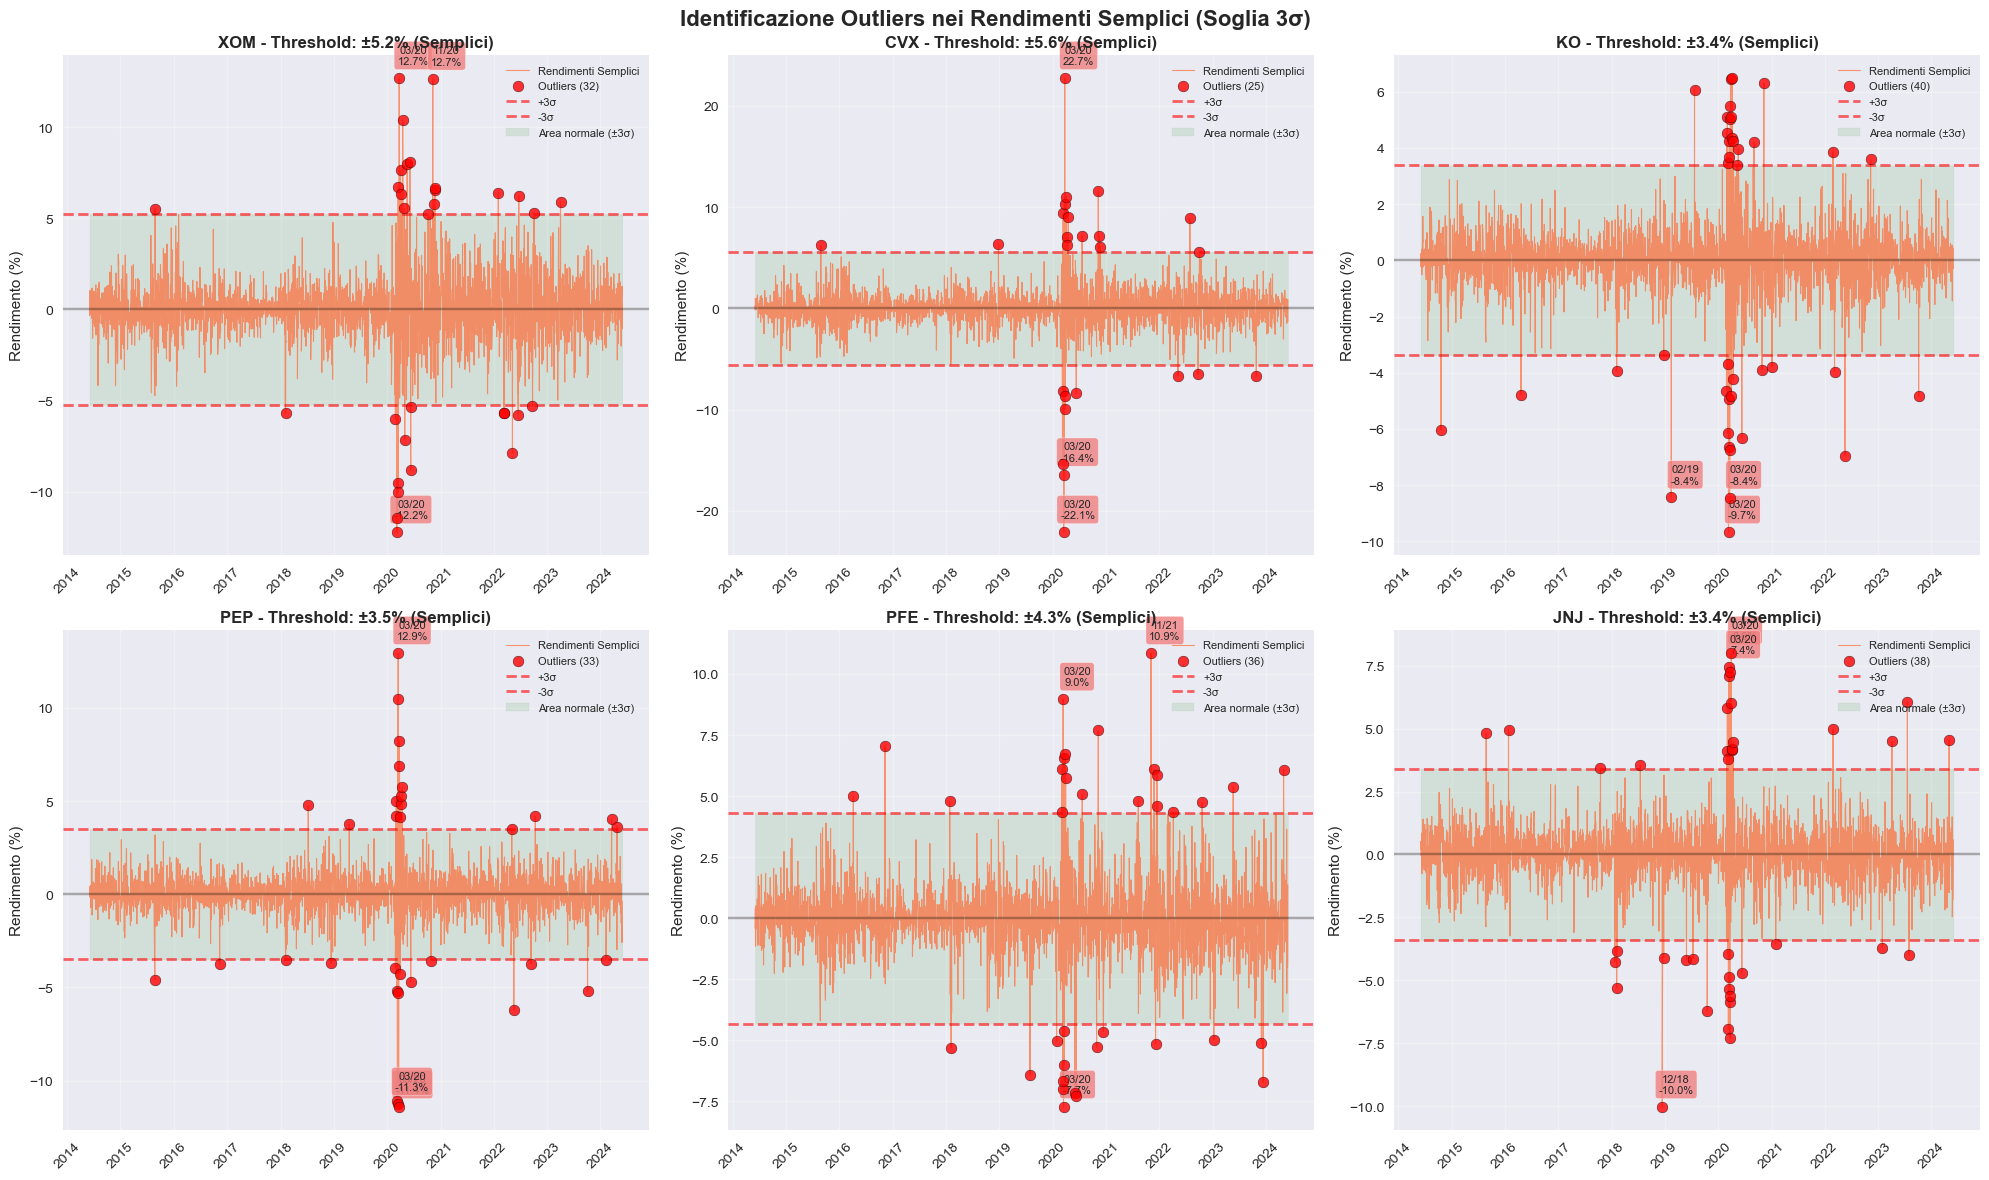

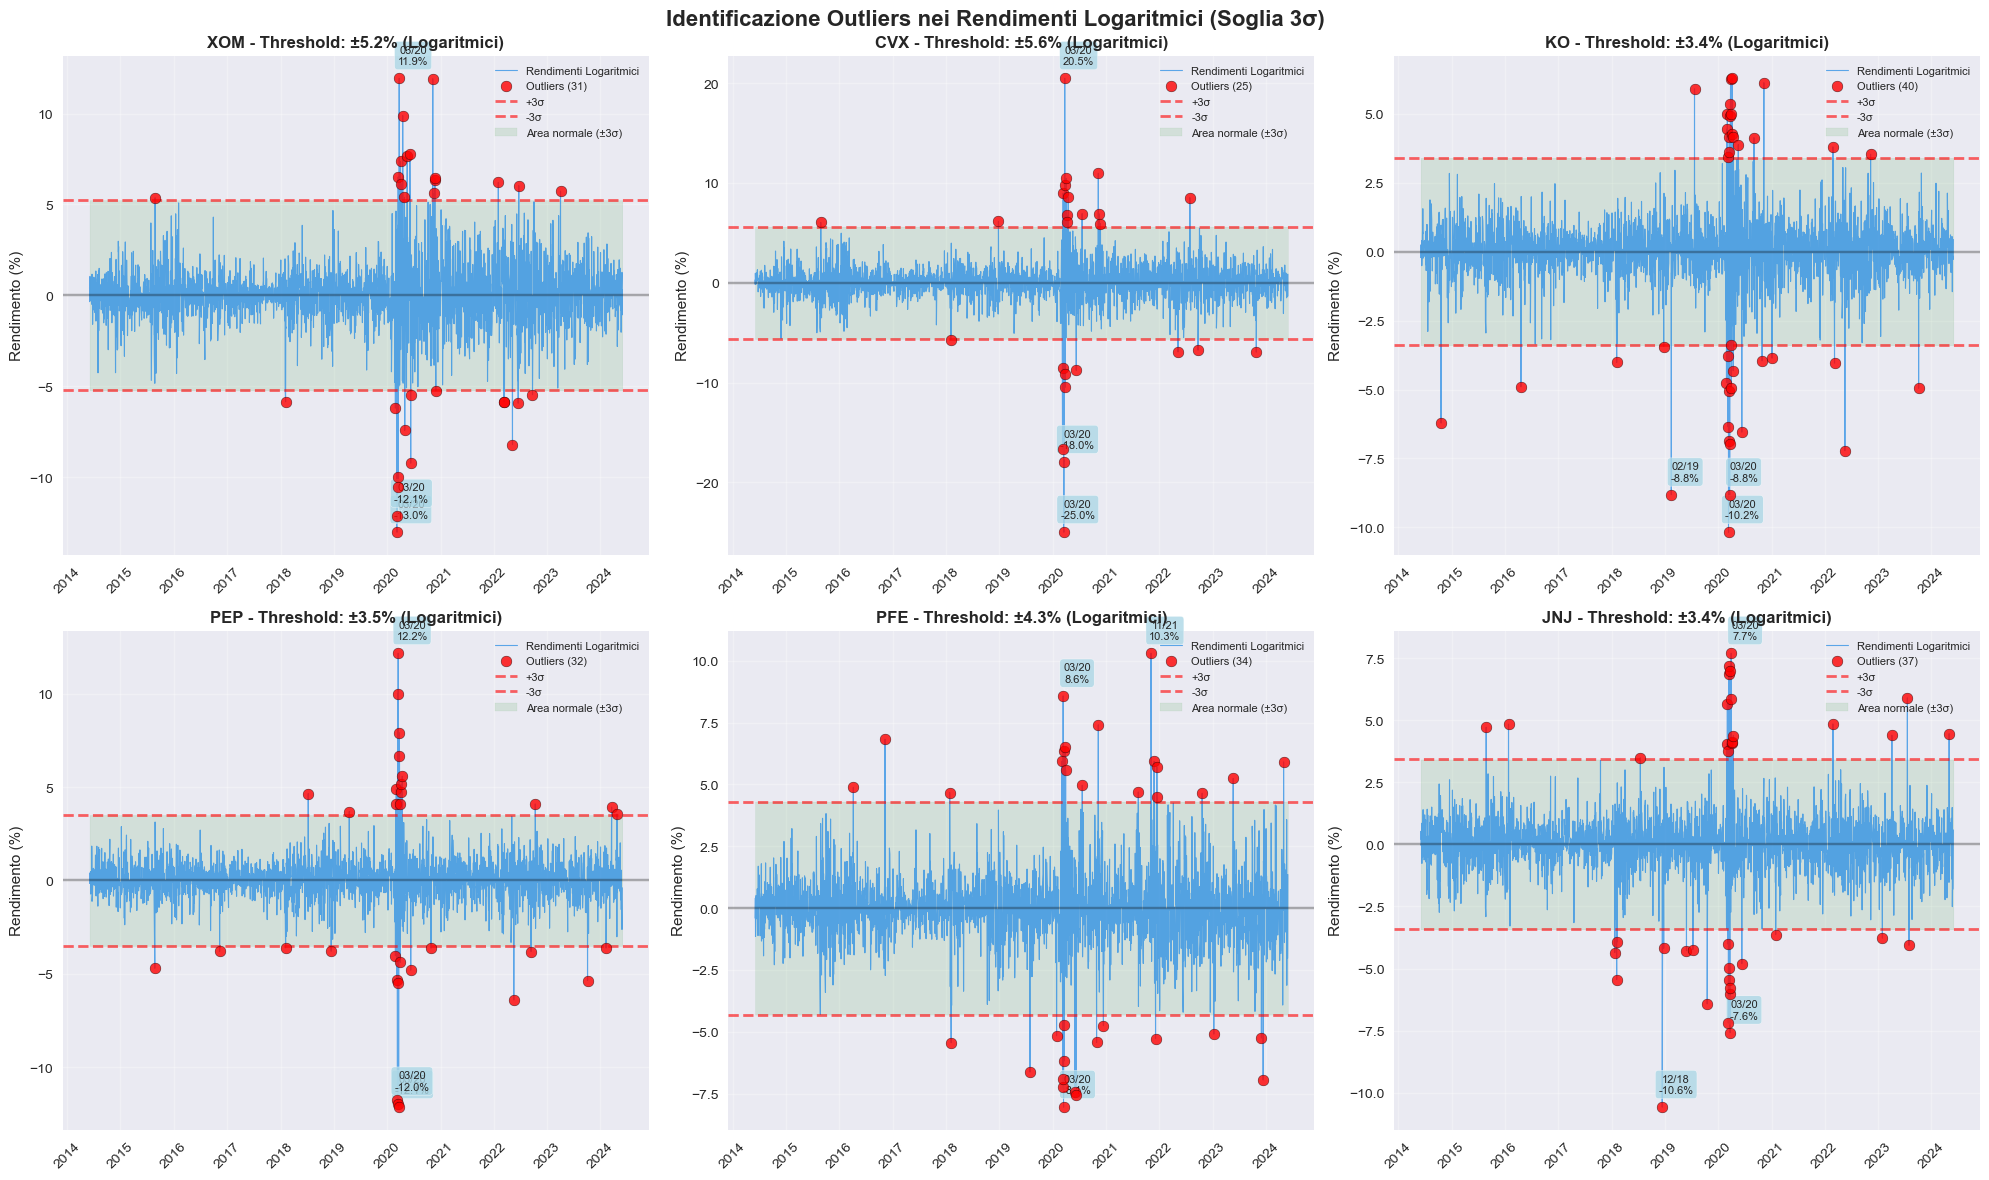


TEST DI NORMALITÀ
   Ticker         Tipo  Jarque-Bera Stat  JB p-value  D'Agostino Stat  \
0     XOM     Semplici       4548.004010         0.0       348.628371   
1     XOM  Logaritmici       4687.663003         0.0       358.904051   
2     CVX     Semplici      57942.619759         0.0       686.157375   
3     CVX  Logaritmici      73233.138833         0.0       971.390053   
4      KO     Semplici      11244.567514         0.0       656.027019   
5      KO  Logaritmici      13368.481572         0.0       765.897001   
6     PEP     Semplici      49576.261777         0.0       661.725375   
7     PEP  Logaritmici      52867.310424         0.0       782.781707   
8     PFE     Semplici       2985.582195         0.0       333.566607   
9     PFE  Logaritmici       2745.767427         0.0       297.499085   
10    JNJ     Semplici       9162.427167         0.0       444.730189   
11    JNJ  Logaritmici       9918.955803         0.0       495.847510   

       DA p-value  Shapiro-Wilk

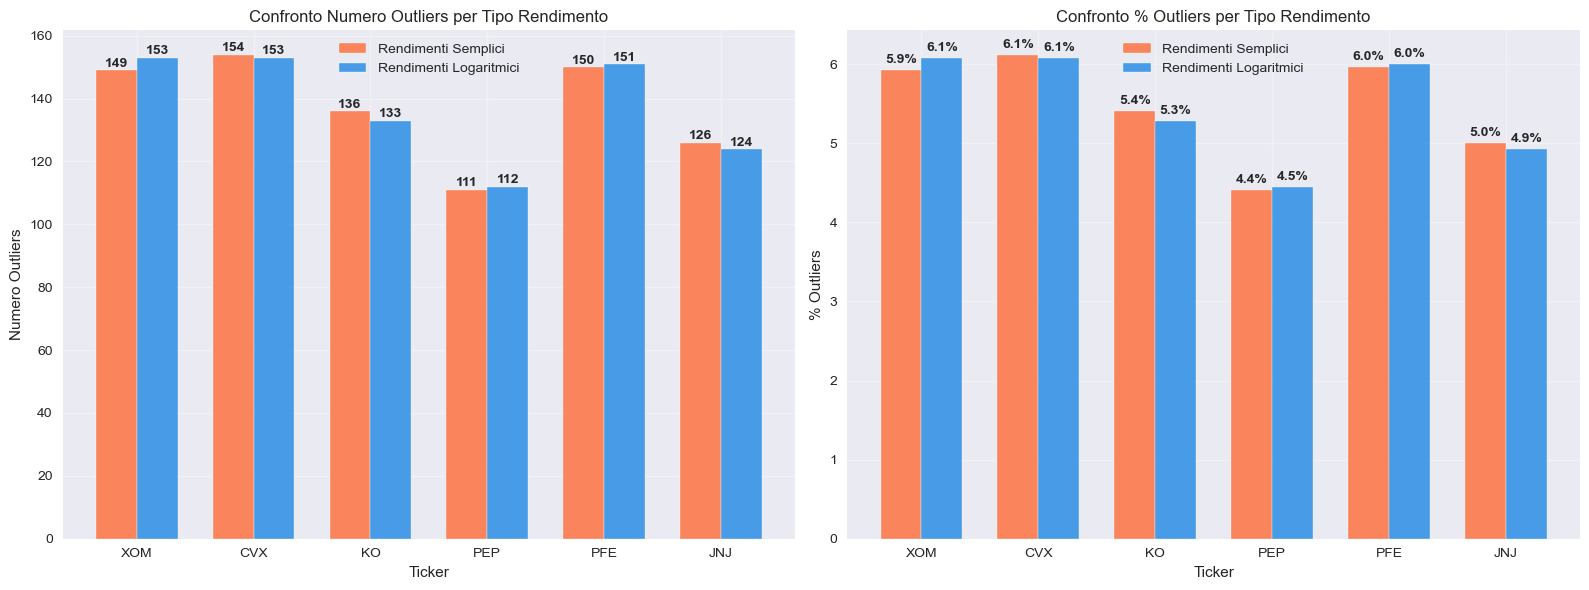

In [68]:
#ANALISI DIAGNOSTICA COMPLETA DEI RENDIMENTI
# Setup dati
if isinstance(simple_ret.columns, pd.MultiIndex):
    tickers = simple_ret.columns.get_level_values(1)
    simple_ret_clean = simple_ret.copy()
    simple_ret_clean.columns = tickers
else:
    tickers = simple_ret.columns
    simple_ret_clean = simple_ret

if isinstance(log_ret.columns, pd.MultiIndex):
    log_ret_clean = log_ret.copy()
    log_ret_clean.columns = log_ret.columns.get_level_values(1)
else:
    log_ret_clean = log_ret

print("="*80)
print("ANALISI DIAGNOSTICA DEI RENDIMENTI")
print("="*80)

# FUNZIONI

def identify_outliers(data, method='iqr'):
    if method == 'iqr':
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        return data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
    elif method == '3sigma':
        threshold = 3 * data.std()
        return data[abs(data - data.mean()) > threshold]

def create_diagnostic_plots(simple_data, log_data, ticker):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Analisi Diagnostica - {ticker}', fontsize=16, fontweight='bold')

    data_pairs = [(simple_data.dropna(), '#FF6B35', 'Semplici'),
                  (log_data.dropna(), '#1E88E5', 'Logaritmici')]

    for row, (clean_data, color, tipo) in enumerate(data_pairs):
        # Istogramma + KDE
        axes[row,0].hist(clean_data, bins=50, density=True, alpha=0.7, color=color, edgecolor='black')
        mu, sigma = clean_data.mean(), clean_data.std()
        x = np.linspace(clean_data.min(), clean_data.max(), 100)
        axes[row,0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2,
                        label=f'Normale (μ={mu:.4f}, σ={sigma:.4f})')
        try:
            clean_data.plot.density(ax=axes[row,0], color='green', linewidth=2, label='KDE')
        except: pass
        axes[row,0].set_title(f'Rendimenti {tipo} - Istogramma + KDE', fontweight='bold')
        axes[row,0].set_xlabel('Rendimenti')
        axes[row,0].set_ylabel('Densità')
        axes[row,0].legend()
        axes[row,0].grid(True, alpha=0.3)

        # Boxplot
        outliers_iqr = identify_outliers(clean_data, 'iqr')
        axes[row,1].boxplot(clean_data, patch_artist=True,
                           boxprops=dict(facecolor=color, alpha=0.7),
                           medianprops=dict(color='red', linewidth=2),
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=8, alpha=0.7))
        if len(outliers_iqr) > 0:
            extreme = pd.concat([outliers_iqr.nlargest(3), outliers_iqr.nsmallest(3)])
            for idx, value in extreme.items():
                axes[row,1].annotate(f'{idx.strftime("%Y-%m")}', xy=(1, value), xytext=(1.1, value),
                                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                                   fontsize=8, ha='left')
        axes[row,1].set_title(f'Rendimenti {tipo} - Boxplot (Outliers: {len(outliers_iqr)})', fontweight='bold')
        axes[row,1].set_ylabel('Rendimenti')
        axes[row,1].grid(True, alpha=0.3)

        # Q-Q Plot
        stats.probplot(clean_data, dist="norm", plot=axes[row,2])
        axes[row,2].set_title(f'Rendimenti {tipo} - Q-Q Plot', fontweight='bold')
        axes[row,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return identify_outliers(data_pairs[0][0], 'iqr'), identify_outliers(data_pairs[1][0], 'iqr')

def normality_tests(data, ticker, data_type):
    clean_data = data.dropna()
    try:
        jb_stat, jb_pvalue = jarque_bera(clean_data)
    except:
        n = len(clean_data)
        skew, kurt = stats.skew(clean_data), stats.kurtosis(clean_data)
        jb_stat = n * (skew**2 / 6 + kurt**2 / 24)
        jb_pvalue = 1 - stats.chi2.cdf(jb_stat, 2)

    dp_stat, dp_pvalue = normaltest(clean_data)
    sw_stat, sw_pvalue = (stats.shapiro(clean_data) if len(clean_data) <= 5000 else (None, None))

    return {
        'ticker': ticker, 'type': data_type,
        'jarque_bera': (jb_stat, jb_pvalue),
        'dagostino_pearson': (dp_stat, dp_pvalue),
        'shapiro_wilk': (sw_stat, sw_pvalue) if sw_stat else (None, None)
    }

def create_outliers_plot(all_outliers, data_type, color, bg_color):
    n_tickers = len(tickers)
    cols, rows = 3, (n_tickers + 2) // 3

    fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
    fig.suptitle(f'Outliers nel Tempo - Rendimenti {data_type} (Metodo IQR)', fontsize=16, fontweight='bold')

    if rows == 1: axes = [axes] if cols == 1 else list(axes)
    else: axes = axes.flatten()

    colors = {'Estremo Negativo': 'red', 'Estremo Positivo': 'green', 'Moderato': 'orange'}

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        ticker_outliers = all_outliers[(all_outliers['Ticker'] == ticker) &
                                      (all_outliers['Tipo_Rendimento'] == data_type)]

        if len(ticker_outliers) > 0:
            for tipo in ticker_outliers['Tipo'].unique():
                subset = ticker_outliers[ticker_outliers['Tipo'] == tipo]
                ax.scatter(subset['Data'], subset['Rendimento'], color=colors[tipo],
                          s=80, alpha=0.7, label=tipo, edgecolors='black')

            ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Soglia +10%')
            ax.axhline(y=-0.1, color='red', linestyle='--', alpha=0.5, label='Soglia -10%')

            extreme = ticker_outliers[ticker_outliers['Tipo'].isin(['Estremo Negativo', 'Estremo Positivo'])]
            for _, row in extreme.head(3).iterrows():
                ax.annotate(f"{row['Data'].strftime('%Y-%m')}\n{row['Rendimento']:.2%}",
                           xy=(row['Data'], row['Rendimento']), xytext=(10, 10),
                           textcoords='offset points', fontsize=8,
                           bbox=dict(boxstyle='round,pad=0.3', fc=bg_color, alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        else:
            ax.text(0.5, 0.5, f'Nessun outlier\nper {ticker}', ha='center', va='center',
                   transform=ax.transAxes, fontsize=12, fontweight='bold')

        ax.set_title(f'{ticker} - {len(ticker_outliers)} outliers ({data_type})', fontweight='bold', fontsize=12)
        ax.set_xlabel('Data')
        ax.set_ylabel('Rendimento')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc='upper right')
        plt.setp(ax.get_xticklabels(), rotation=45)

    for j in range(i + 1, len(axes)): axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

def create_3sigma_plot(data_clean, data_type, color):
    n_tickers = len(tickers)
    cols, rows = 3, (n_tickers + 2) // 3

    fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
    fig.suptitle(f'Identificazione Outliers nei Rendimenti {data_type} (Soglia 3σ)', fontsize=16, fontweight='bold')

    if rows == 1: axes = [axes] if cols == 1 else list(axes)
    else: axes = axes.flatten()

    bg_color = 'lightcoral' if data_type == 'Semplici' else 'lightblue'

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        series = data_clean[ticker].dropna()
        threshold = 3 * series.std()
        outliers_3sigma = series[abs(series) > threshold]

        ax.plot(series.index, series * 100, alpha=0.7, linewidth=0.8, color=color,
               label=f'Rendimenti {data_type}')

        if len(outliers_3sigma) > 0:
            ax.scatter(outliers_3sigma.index, outliers_3sigma * 100, color='red', s=60,
                      zorder=5, label=f'Outliers ({len(outliers_3sigma)})',
                      edgecolors='black', alpha=0.8)

            extreme = outliers_3sigma.reindex(outliers_3sigma.abs().sort_values(ascending=False).index).head(3)
            for date, value in extreme.items():
                ax.annotate(f"{date.strftime('%m/%y')}\n{value:.1%}", xy=(date, value * 100),
                           xytext=(10, 10), textcoords='offset points', fontsize=8, ha='center',
                           bbox=dict(boxstyle='round,pad=0.3', fc=bg_color, alpha=0.8),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1'))

        ax.axhline(y=threshold * 100, color='red', linestyle='--', alpha=0.6, label='+3σ', linewidth=2)
        ax.axhline(y=-threshold * 100, color='red', linestyle='--', alpha=0.6, label='-3σ', linewidth=2)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.fill_between(series.index, -threshold * 100, threshold * 100,
                       alpha=0.1, color='green', label='Area normale (±3σ)')

        ax.set_title(f'{ticker} - Threshold: ±{threshold:.1%} ({data_type})', fontweight='bold', fontsize=12)
        ax.set_ylabel('Rendimento (%)')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc='upper right')
        plt.setp(ax.get_xticklabels(), rotation=45)

    for j in range(i + 1, len(axes)): axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

# ESECUZIONE ANALISI

print("\nGRAFICI DIAGNOSTICI PER OGNI TICKER")
print("-" * 50)

outliers_summary = {'Semplici': {}, 'Logaritmici': {}}
normality_results = []

# Analisi per ogni ticker
for ticker in tickers:
    print(f"\n{ticker}:")
    outliers_s, outliers_l = create_diagnostic_plots(simple_ret_clean[ticker], log_ret_clean[ticker], ticker)
    outliers_summary['Semplici'][ticker] = outliers_s
    outliers_summary['Logaritmici'][ticker] = outliers_l

    # Test di normalità
    for data, tipo in [(simple_ret_clean[ticker], 'Semplici'), (log_ret_clean[ticker], 'Logaritmici')]:
        normality_results.append(normality_tests(data, ticker, tipo))

# Processamento outliers
all_outliers_list = []
for data_type in ['Semplici', 'Logaritmici']:
    for ticker, outliers in outliers_summary[data_type].items():
        if len(outliers) > 0:
            all_outliers_list.append(pd.DataFrame({
                'Ticker': ticker, 'Tipo_Rendimento': data_type,
                'Data': outliers.index, 'Rendimento': outliers.values,
                'Tipo': ['Estremo Negativo' if x < -0.1 else 'Estremo Positivo' if x > 0.1 else 'Moderato'
                        for x in outliers.values]
            }))

if all_outliers_list:
    all_outliers = pd.concat(all_outliers_list, ignore_index=True)

    # Grafici Outliers
    print("\n" + "="*80)
    print("GRAFICI OUTLIERS SEPARATI PER RENDIMENTI SEMPLICI E LOGARITMICI")
    print("="*80)

    create_outliers_plot(all_outliers, 'Semplici', '#FF6B35', 'yellow')
    create_outliers_plot(all_outliers, 'Logaritmici', '#1E88E5', 'lightblue')

    # Grafici 3σ
    print("\n" + "="*80)
    print("4-5. GRAFICI SERIE TEMPORALI CON SOGLIA 3σ")
    print("="*80)

    create_3sigma_plot(simple_ret_clean, 'Semplici', '#FF6B35')
    create_3sigma_plot(log_ret_clean, 'Logaritmici', '#1E88E5')

else:
    print("Nessun outlier trovato.")

# Test di normalità
print("\n" + "="*80)
print("TEST DI NORMALITÀ")
print("="*80)

normality_df = pd.concat([pd.DataFrame([{
    'Ticker': r['ticker'], 'Tipo': r['type'],
    'Jarque-Bera Stat': r['jarque_bera'][0], 'JB p-value': r['jarque_bera'][1],
    'D\'Agostino Stat': r['dagostino_pearson'][0], 'DA p-value': r['dagostino_pearson'][1],
    **({'Shapiro-Wilk Stat': r['shapiro_wilk'][0], 'SW p-value': r['shapiro_wilk'][1]}
       if r['shapiro_wilk'][0] else {})
}]) for r in normality_results], ignore_index=True)

print(normality_df)

# Riepilogo comparativo
print("\n" + "="*80)
print("RIEPILOGO COMPARATIVO OUTLIERS")
print("="*80)

comparison_df = pd.DataFrame([{
    'Ticker': ticker,
    'Outliers_Semplici': len(outliers_summary['Semplici'][ticker]),
    'Outliers_Logaritmici': len(outliers_summary['Logaritmici'][ticker]),
    'Semplici_%': len(outliers_summary['Semplici'][ticker]) / len(simple_ret_clean[ticker].dropna()) * 100,
    'Logaritmici_%': len(outliers_summary['Logaritmici'][ticker]) / len(log_ret_clean[ticker].dropna()) * 100,
    'Osservazioni_Semplici': len(simple_ret_clean[ticker].dropna()),
    'Osservazioni_Logaritmici': len(log_ret_clean[ticker].dropna())
} for ticker in tickers])

print("\nCOMPARAZIONE OUTLIERS: RENDIMENTI SEMPLICI vs LOGARITMICI:")
print(comparison_df.round(2))

# Grafici comparativi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
x = np.arange(len(tickers))
width = 0.35

# Numero outliers
for i, (bars, col, label) in enumerate([
    (ax1.bar(x - width/2, comparison_df['Outliers_Semplici'], width, alpha=0.8, color='#FF6B35'),
     'Outliers_Semplici', 'Rendimenti Semplici'),
    (ax1.bar(x + width/2, comparison_df['Outliers_Logaritmici'], width, alpha=0.8, color='#1E88E5'),
     'Outliers_Logaritmici', 'Rendimenti Logaritmici')
]):
    bars.set_label(label)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

ax1.set_xlabel('Ticker')
ax1.set_ylabel('Numero Outliers')
ax1.set_title('Confronto Numero Outliers per Tipo Rendimento')
ax1.set_xticks(x)
ax1.set_xticklabels(tickers)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Percentuale outliers
for i, (bars, col, label) in enumerate([
    (ax2.bar(x - width/2, comparison_df['Semplici_%'], width, alpha=0.8, color='#FF6B35'),
     'Semplici_%', 'Rendimenti Semplici'),
    (ax2.bar(x + width/2, comparison_df['Logaritmici_%'], width, alpha=0.8, color='#1E88E5'),
     'Logaritmici_%', 'Rendimenti Logaritmici')
]):
    bars.set_label(label)
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Ticker')
ax2.set_ylabel('% Outliers')
ax2.set_title('Confronto % Outliers per Tipo Rendimento')
ax2.set_xticks(x)
ax2.set_xticklabels(tickers)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

STATISTICHE ANNUALIZZATE - CONFRONTO RENDIMENTI SEMPLICI vs LOGARITMICI

 RENDIMENTI SEMPLICI - ANNUALIZZATI:
--------------------------------------------------


Mean       Var       Std      Skew   Kurtosis
Ticker                                                   
XOM     0.094913  0.076616  0.276796  0.075947   6.600335
CVX     0.112308  0.087477  0.295765 -0.196658  23.555707
KO      0.089592  0.031944  0.178727 -0.774736  10.263050
PEP     0.112370  0.034145  0.184784 -0.167101  21.789487
PFE     0.064306  0.052107  0.228270  0.303935   5.314851
JNJ     0.079001  0.032601  0.180559 -0.175439   9.363195


 RENDIMENTI LOGARITMICI - ANNUALIZZATI:
--------------------------------------------------


Mean       Var       Std      Skew   Kurtosis
Ticker                                                   
XOM     0.056609  0.076656  0.276868 -0.149262   6.695981
CVX     0.068286  0.088479  0.297455 -0.937998  26.418697
KO      0.073516  0.032249  0.179580 -0.977368  11.146792
PEP     0.095243  0.034286  0.185164 -0.584784  22.473174
PFE     0.038321  0.051931  0.227884  0.150339   5.121513
JNJ     0.062670  0.032693  0.180813 -0.371021   9.720477


GRAFICI COMPARATIVI


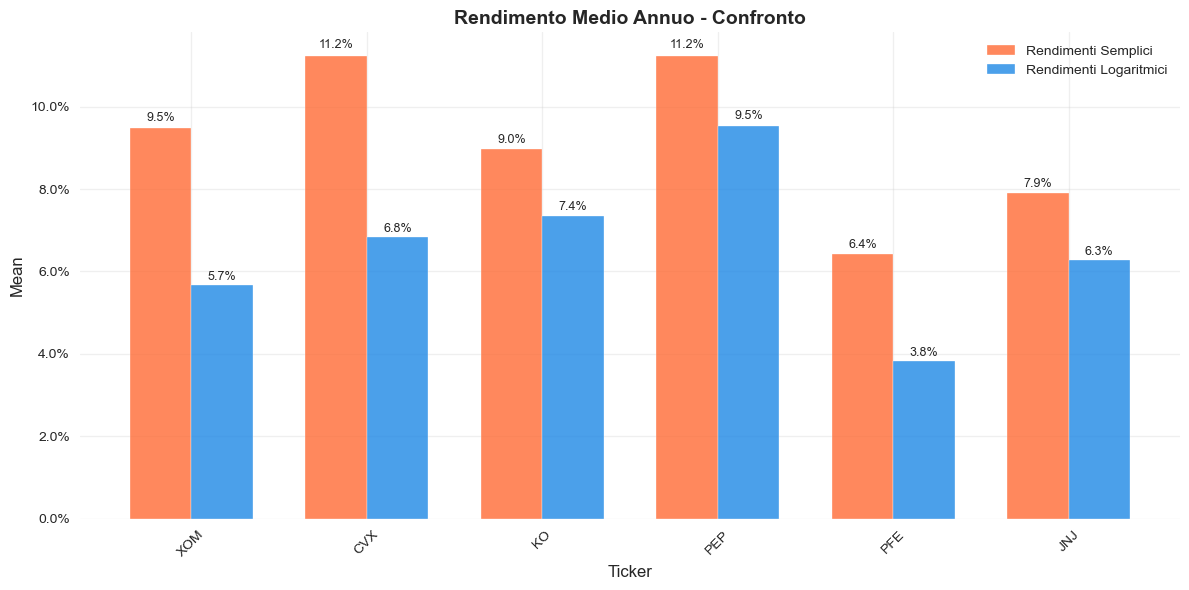

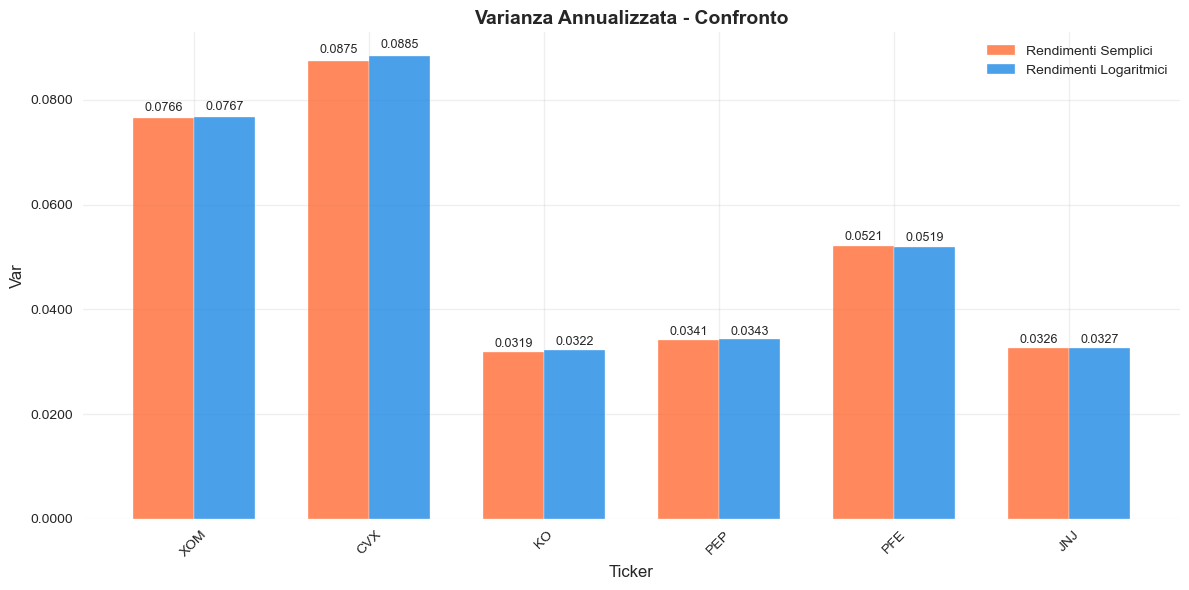

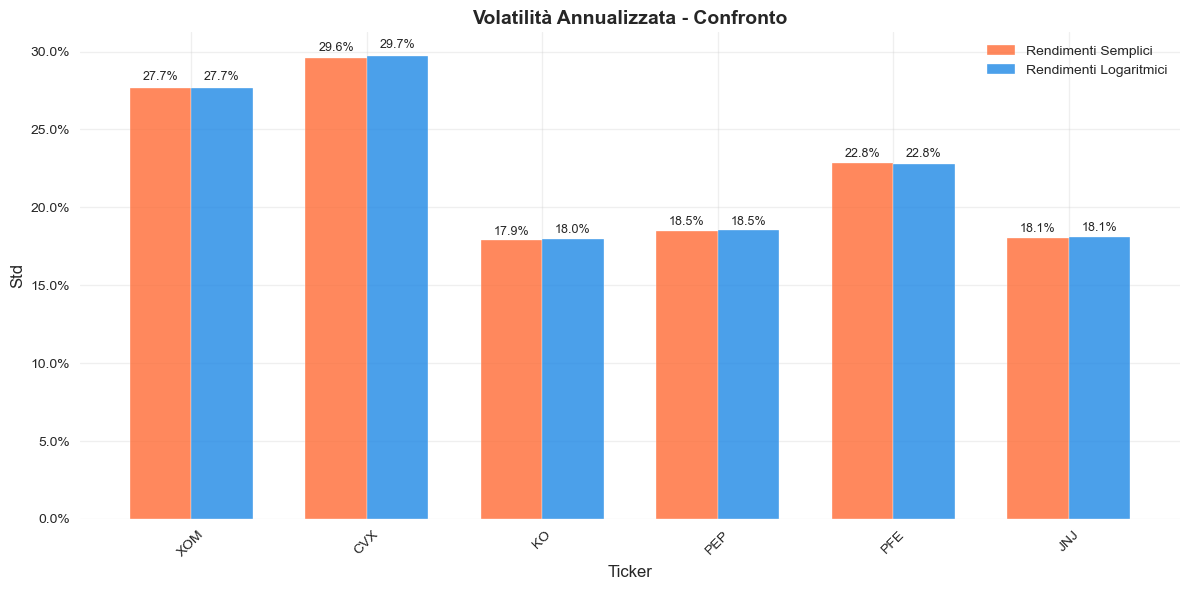

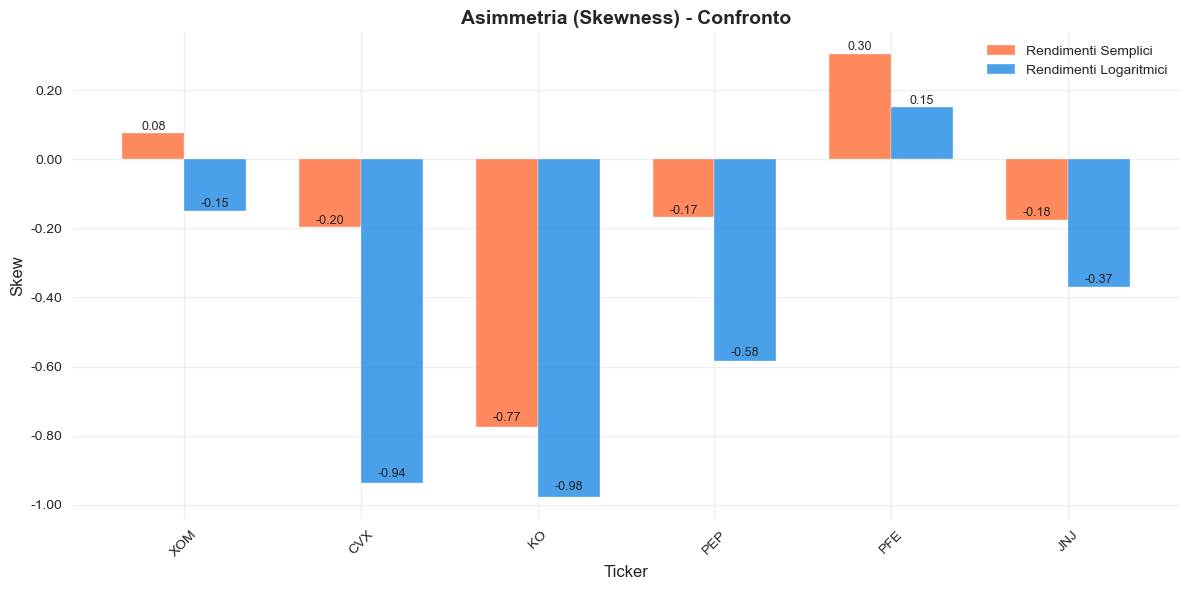

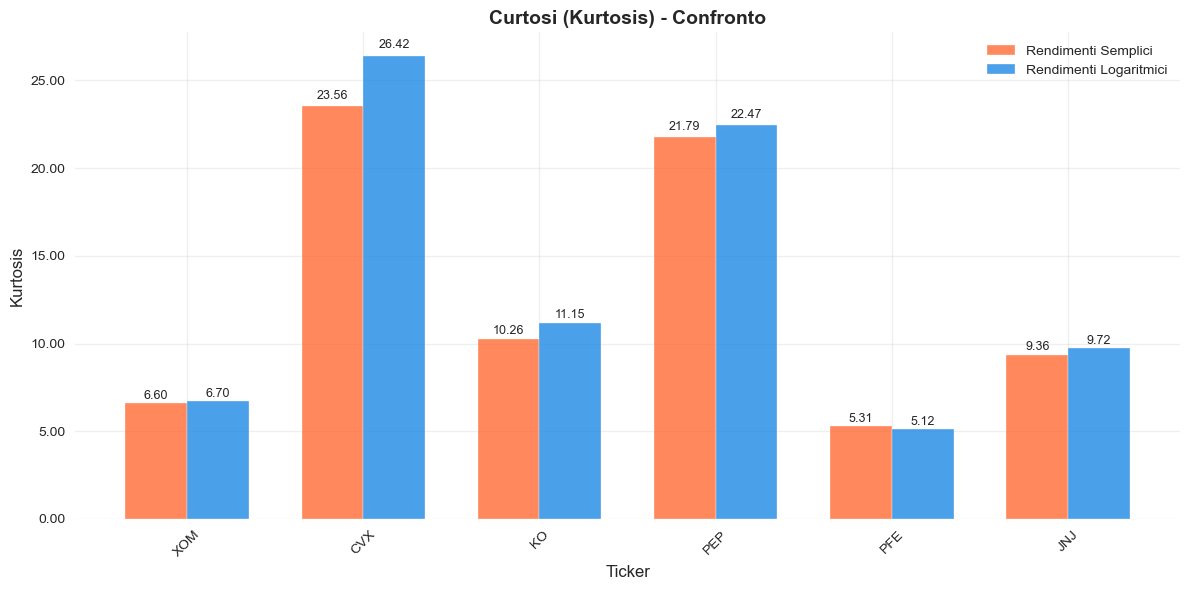


 GRAFICI RISK-RETURN COMPARATIVI


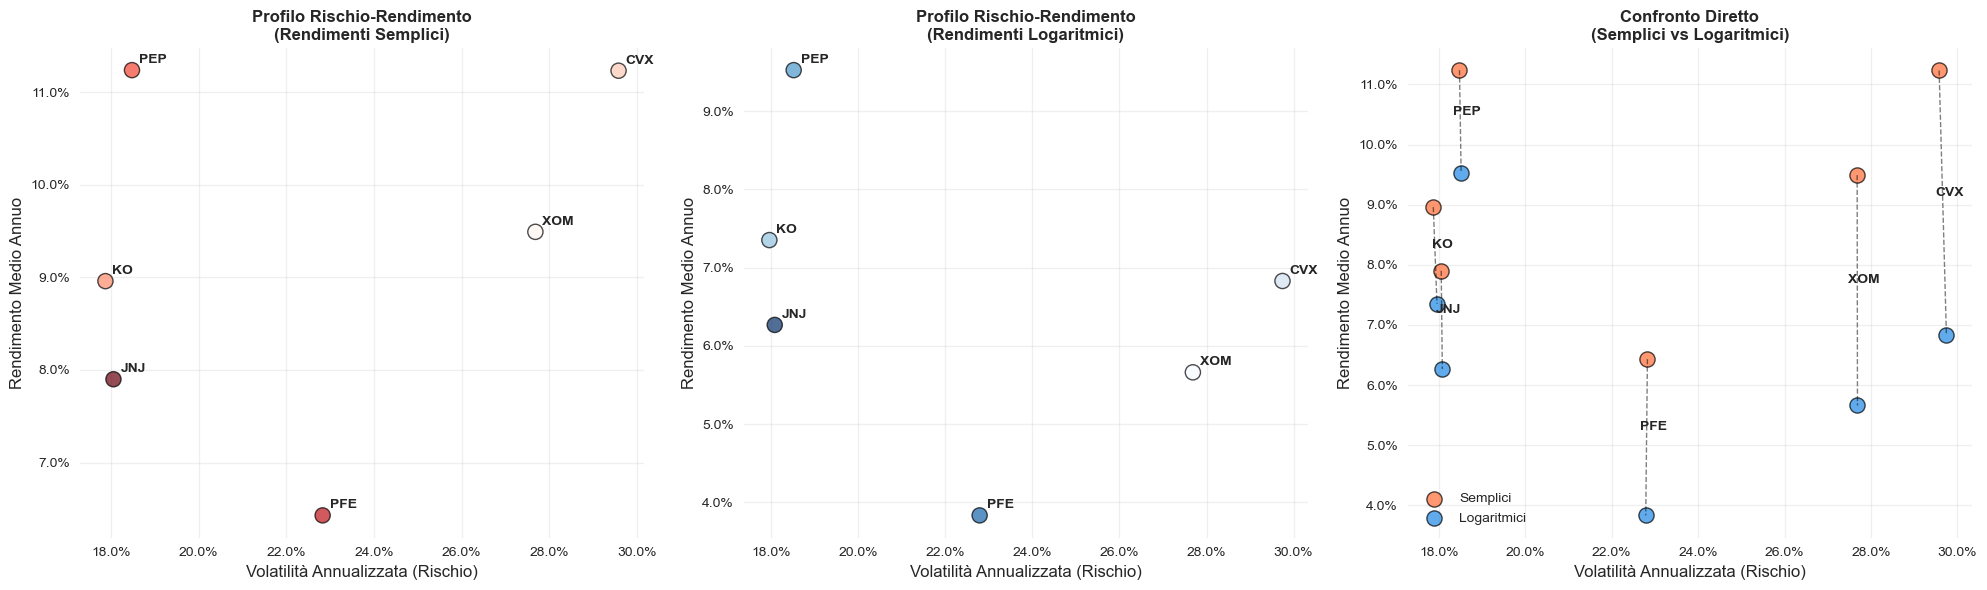

In [69]:
# FUNZIONI

def calculate_annual_stats(returns_data, data_type):
    ann_stats = pd.DataFrame({
        'Mean': returns_data.mean() * 252, 'Var': returns_data.var() * 252,
        'Std': returns_data.std() * np.sqrt(252), 'Skew': returns_data.skew(),
        'Kurtosis': returns_data.kurtosis(), 'Tipo': data_type
    })

    # Gestione MultiIndex
    ticker_labels = (ann_stats.index.get_level_values(1) if isinstance(ann_stats.index, pd.MultiIndex)
                    else ann_stats.index)
    if isinstance(ann_stats.index, pd.MultiIndex):
        ann_stats.index = ticker_labels

    return ann_stats, ticker_labels

def create_comparison_plots(stats_dict, ticker_labels):
    sns.set_style("whitegrid")
    metrics = ['Mean', 'Var', 'Std', 'Skew', 'Kurtosis']
    colors = {'Semplici': '#FF6B35', 'Logaritmici': '#1E88E5'}
    title_mapping = {
        'Mean': 'Rendimento Medio Annuo', 'Var': 'Varianza Annualizzata',
        'Std': 'Volatilità Annualizzata', 'Skew': 'Asimmetria (Skewness)',
        'Kurtosis': 'Curtosi (Kurtosis)'
    }

    # Crea un grafico separato per ogni metrica
    for metric in metrics:
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(ticker_labels))
        width = 0.35

        # Barre per entrambi i tipi
        bars_data = [(stats_dict['Semplici'][metric], 'Rendimenti Semplici', colors['Semplici']),
                     (stats_dict['Logaritmici'][metric], 'Rendimenti Logaritmici', colors['Logaritmici'])]

        bars_list = []
        for j, (data, label, color) in enumerate(bars_data):
            bars = ax.bar(x + (j-0.5)*width, data, width, label=label, color=color, alpha=0.8)
            bars_list.append(bars)

        # Configurazione asse
        ax.set_title(f'{title_mapping.get(metric, metric)} - Confronto', fontsize=14, fontweight='bold')
        ax.set_ylabel(metric, fontsize=12)
        ax.set_xlabel('Ticker', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(ticker_labels, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Formattazione e valori sopra barre
        if metric in ['Mean', 'Std']:
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, *args: f'{y:.1%}'))
            format_str = '{:.1%}'
        elif metric == 'Var':
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, *args: f'{y:.4f}'))
            format_str = '{:.4f}'
        else:
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, *args: f'{y:.2f}'))
            format_str = '{:.2f}'

        # Aggiungi valori sopra barre
        for bars in bars_list:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + abs(height)*0.01,
                       format_str.format(height), ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

def create_risk_return_plots(stats_dict, ticker_labels):
    colors = {'Semplici': '#FF6B35', 'Logaritmici': '#1E88E5'}

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Configurazioni per i primi due subplot
    plot_configs = [
        ('Semplici', 'Reds', 'Profilo Rischio-Rendimento\n(Rendimenti Semplici)'),
        ('Logaritmici', 'Blues', 'Profilo Rischio-Rendimento\n(Rendimenti Logaritmici)')
    ]

    # Primi due subplot
    for idx, (data_type, cmap, title) in enumerate(plot_configs):
        ax = axes[idx]
        stats = stats_dict[data_type]

        ax.scatter(stats['Std'], stats['Mean'], c=range(len(stats)), cmap=cmap,
                  s=120, alpha=0.7, edgecolors='black', linewidth=1)

        for i, ticker in enumerate(ticker_labels):
            ax.annotate(ticker, (stats.iloc[i]['Std'], stats.iloc[i]['Mean']),
                       xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

        ax.set_xlabel('Volatilità Annualizzata (Rischio)', fontsize=12)
        ax.set_ylabel('Rendimento Medio Annuo', fontsize=12)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, *args: f'{y:.1%}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, *args: f'{y:.1%}'))

    # Terzo subplot: confronto diretto
    ax3 = axes[2]
    for i, ticker in enumerate(ticker_labels):
        for j, (data_type, color) in enumerate([('Semplici', colors['Semplici']),
                                               ('Logaritmici', colors['Logaritmici'])]):
            stats = stats_dict[data_type]
            ax3.scatter(stats.iloc[i]['Std'], stats.iloc[i]['Mean'], color=color, s=120,
                       alpha=0.7, label=data_type if i == 0 else "",
                       edgecolors='black', linewidth=1)

        # Linea di connessione
        ax3.plot([stats_dict['Semplici'].iloc[i]['Std'], stats_dict['Logaritmici'].iloc[i]['Std']],
                 [stats_dict['Semplici'].iloc[i]['Mean'], stats_dict['Logaritmici'].iloc[i]['Mean']],
                 'k--', alpha=0.5, linewidth=1)

        # Etichetta al centro
        mid_x = (stats_dict['Semplici'].iloc[i]['Std'] + stats_dict['Logaritmici'].iloc[i]['Std']) / 2
        mid_y = (stats_dict['Semplici'].iloc[i]['Mean'] + stats_dict['Logaritmici'].iloc[i]['Mean']) / 2
        ax3.annotate(ticker, (mid_x, mid_y), xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold', ha='center')

    ax3.set_xlabel('Volatilità Annualizzata (Rischio)', fontsize=12)
    ax3.set_ylabel('Rendimento Medio Annuo', fontsize=12)
    ax3.set_title('Confronto Diretto\n(Semplici vs Logaritmici)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, *args: f'{y:.1%}'))
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, *args: f'{y:.1%}'))

    plt.tight_layout()
    plt.show()

# ESECUZIONE ANALISI

print("="*80)
print("STATISTICHE ANNUALIZZATE - CONFRONTO RENDIMENTI SEMPLICI vs LOGARITMICI")
print("="*80)

# Calcolo statistiche per entrambi i tipi
stats_data = {}
for returns, data_type in [(simple_ret_clean, 'Semplici'), (log_ret_clean, 'Logaritmici')]:
    stats_data[data_type], ticker_labels = calculate_annual_stats(returns, data_type)

# Display tabelle
for data_type in ['Semplici', 'Logaritmici']:
    print(f"\n RENDIMENTI {data_type.upper()} - ANNUALIZZATI:")
    print("-" * 50)
    display(stats_data[data_type].drop('Tipo', axis=1))


print("\n" + "="*80)
print("GRAFICI COMPARATIVI")
print("="*80)

create_comparison_plots(stats_data, ticker_labels)

print("\n" + "="*80)
print(" GRAFICI RISK-RETURN COMPARATIVI")
print("="*80)

create_risk_return_plots(stats_data, ticker_labels)



MATRICI DI CORRELAZIONE, COVARIANZA E VARIANZA - RENDIMENTI MENSILI

STATISTICHE DETTAGLIATE PER LE COPPIE SELEZIONATE:
----------------------------------------------------------------------
Coppia       Correlazione Covarianza      Var A        Var B       
----------------------------------------------------------------------
XOM-CVX       0.8668       0.005380        0.006216     0.006196    
          → Correlazione FORTE POSITIVA
KO-PEP       0.7591       0.001482        0.002079     0.001834    
          → Correlazione FORTE POSITIVA
PFE-JNJ       0.5376       0.001571        0.004265     0.002002    
          → Correlazione MODERATA POSITIVA

MATRICI COMPLETE (RENDIMENTI MENSILI):
Ticker analizzati: ['XOM', 'CVX', 'KO', 'PEP', 'PFE', 'JNJ']

MATRICE DI CORRELAZIONE:
Ticker     XOM     CVX      KO     PEP     PFE     JNJ
Ticker                                                
XOM     1.0000  0.8668  0.3354  0.3379  0.1519  0.3711
CVX     0.8668  1.0000  0.3739  0.3987  0.2998  

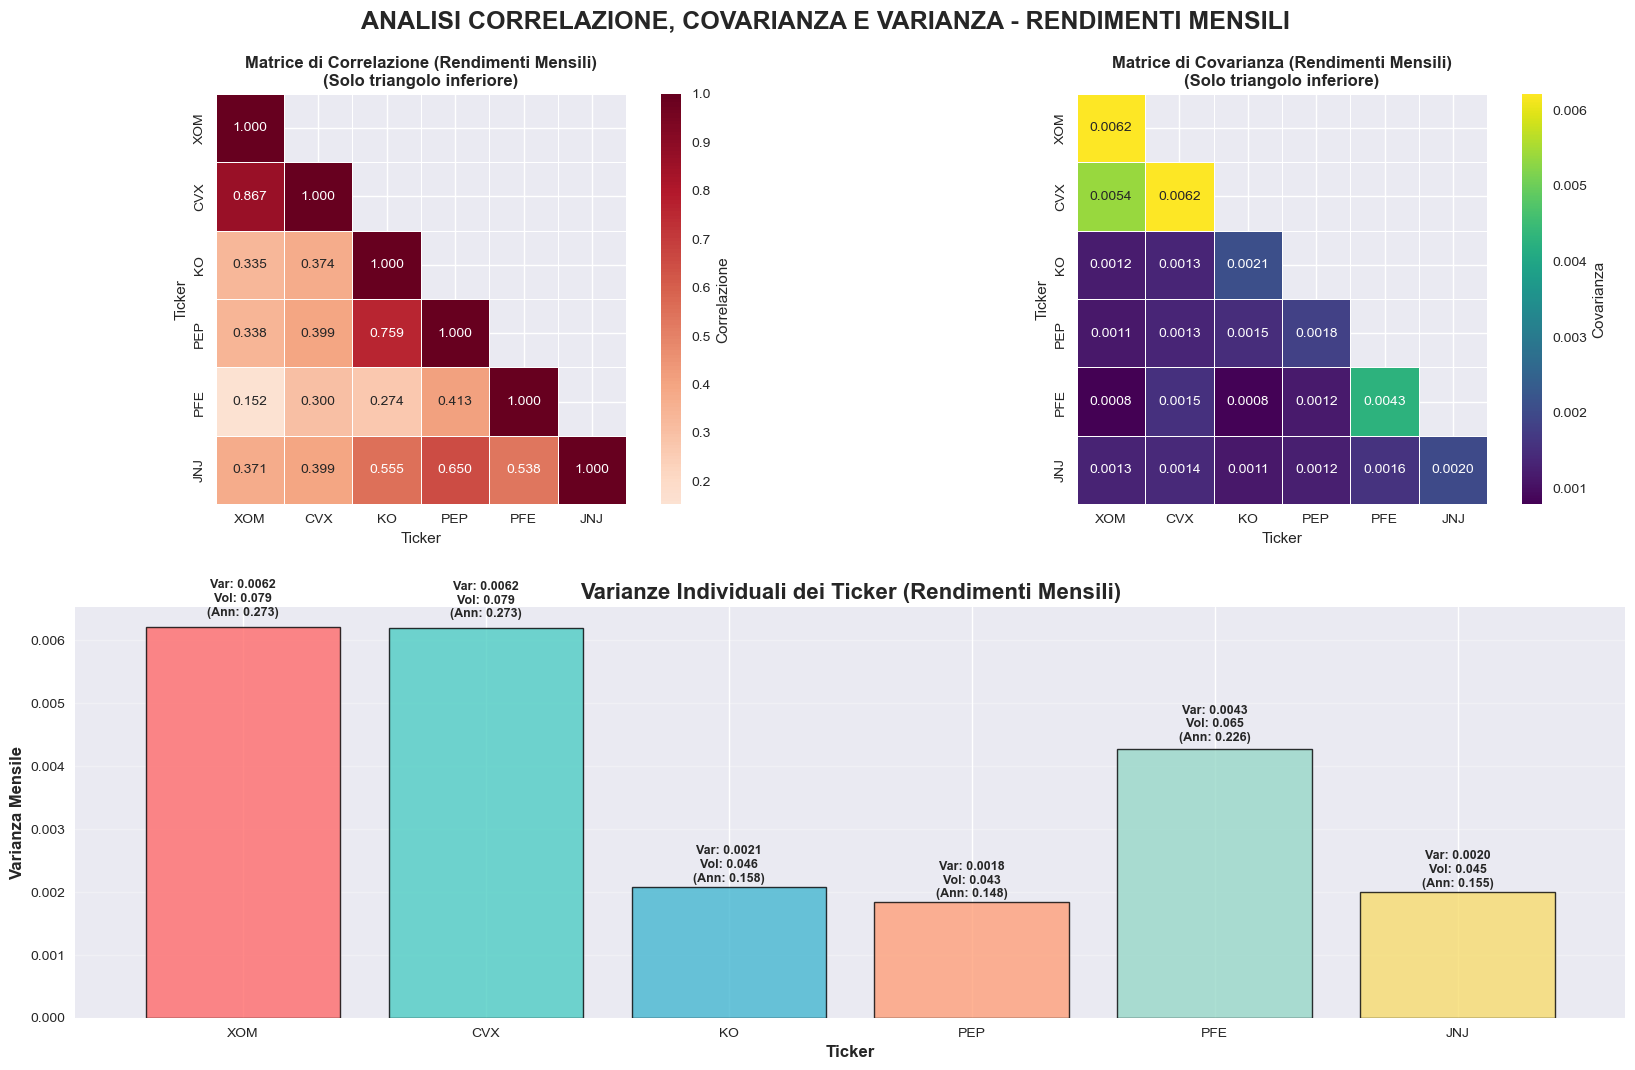

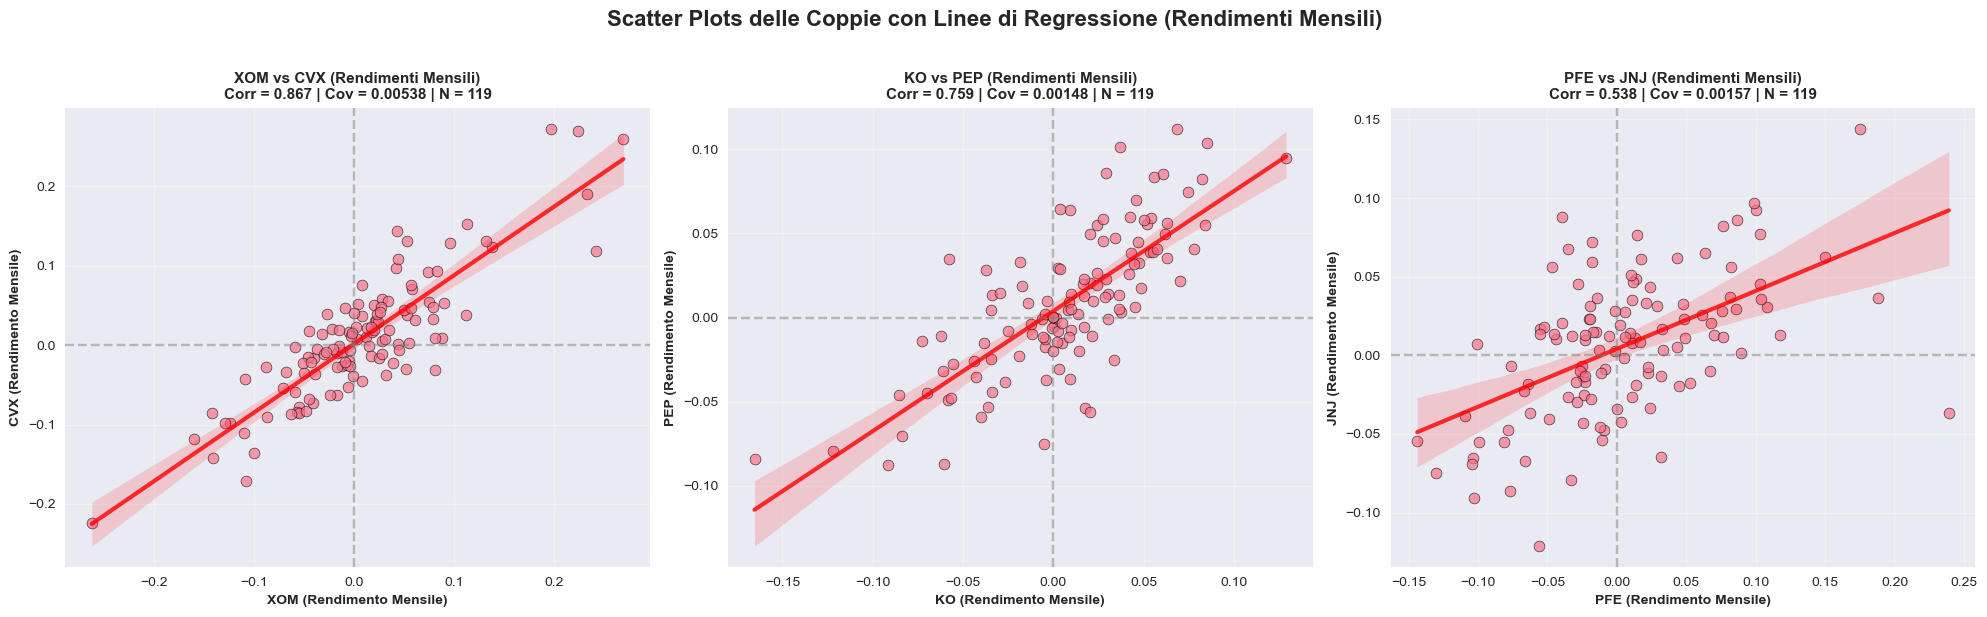

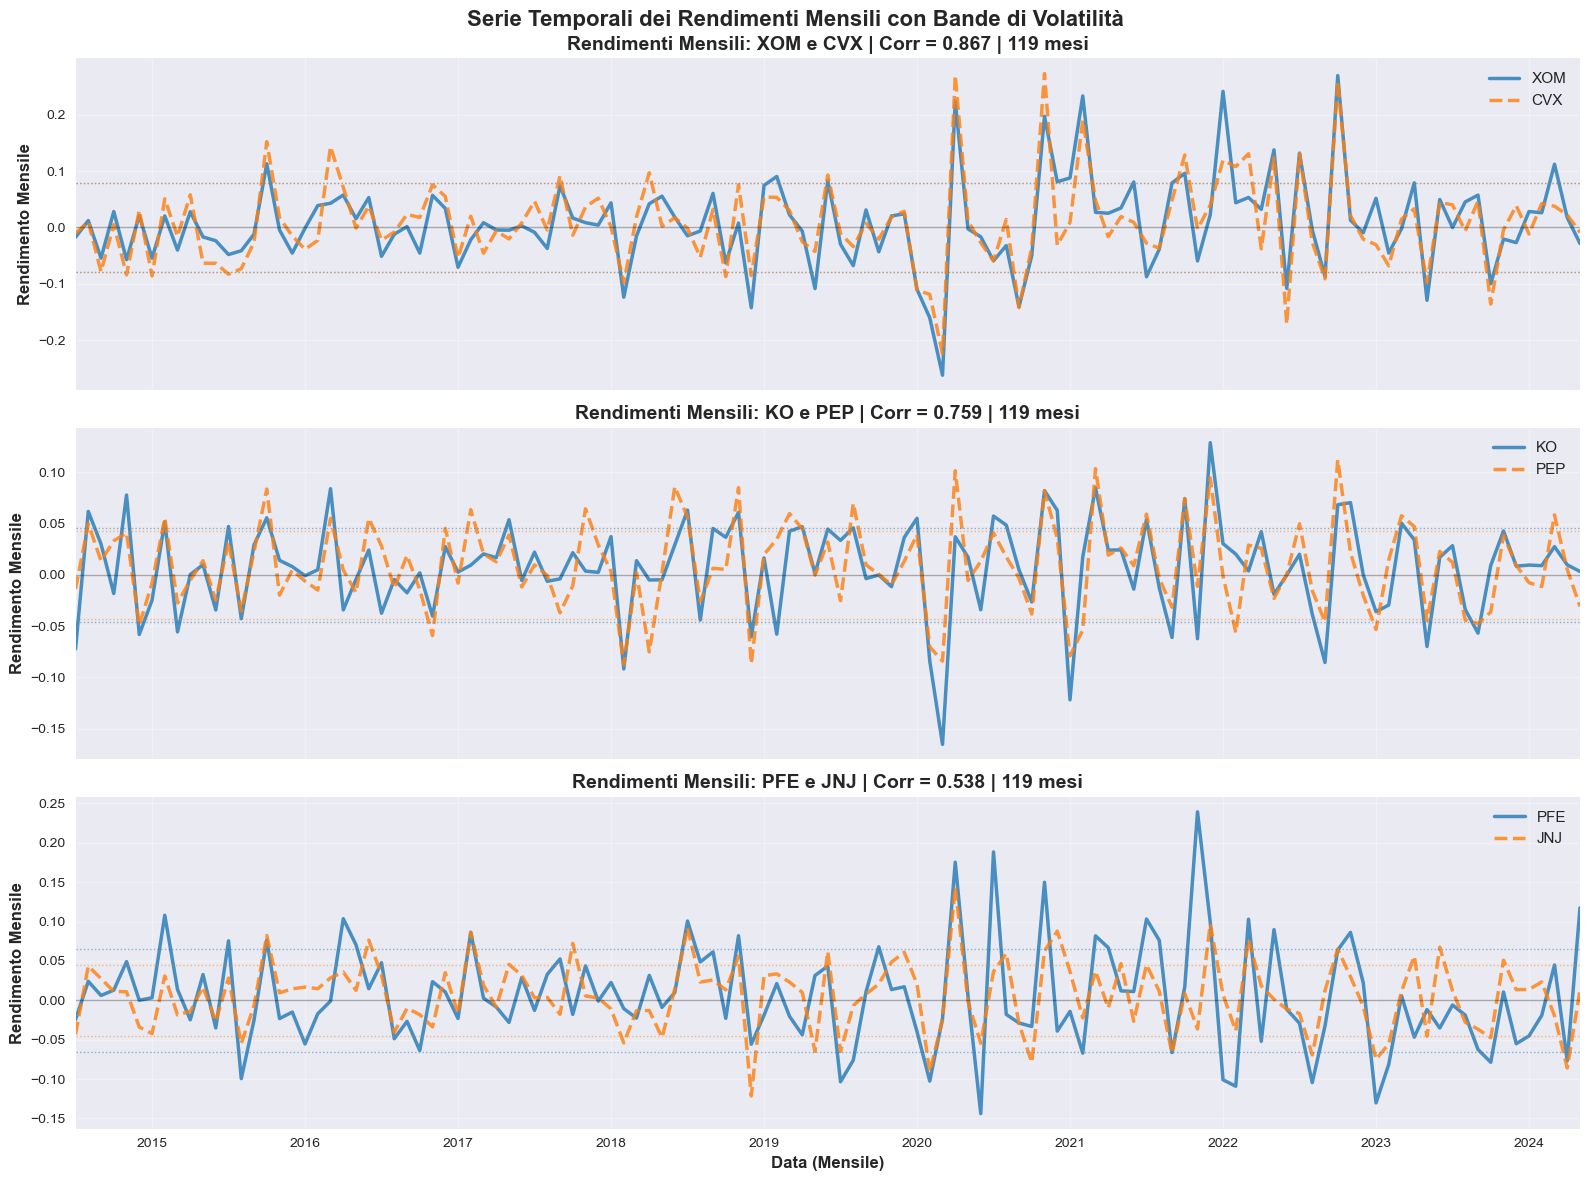

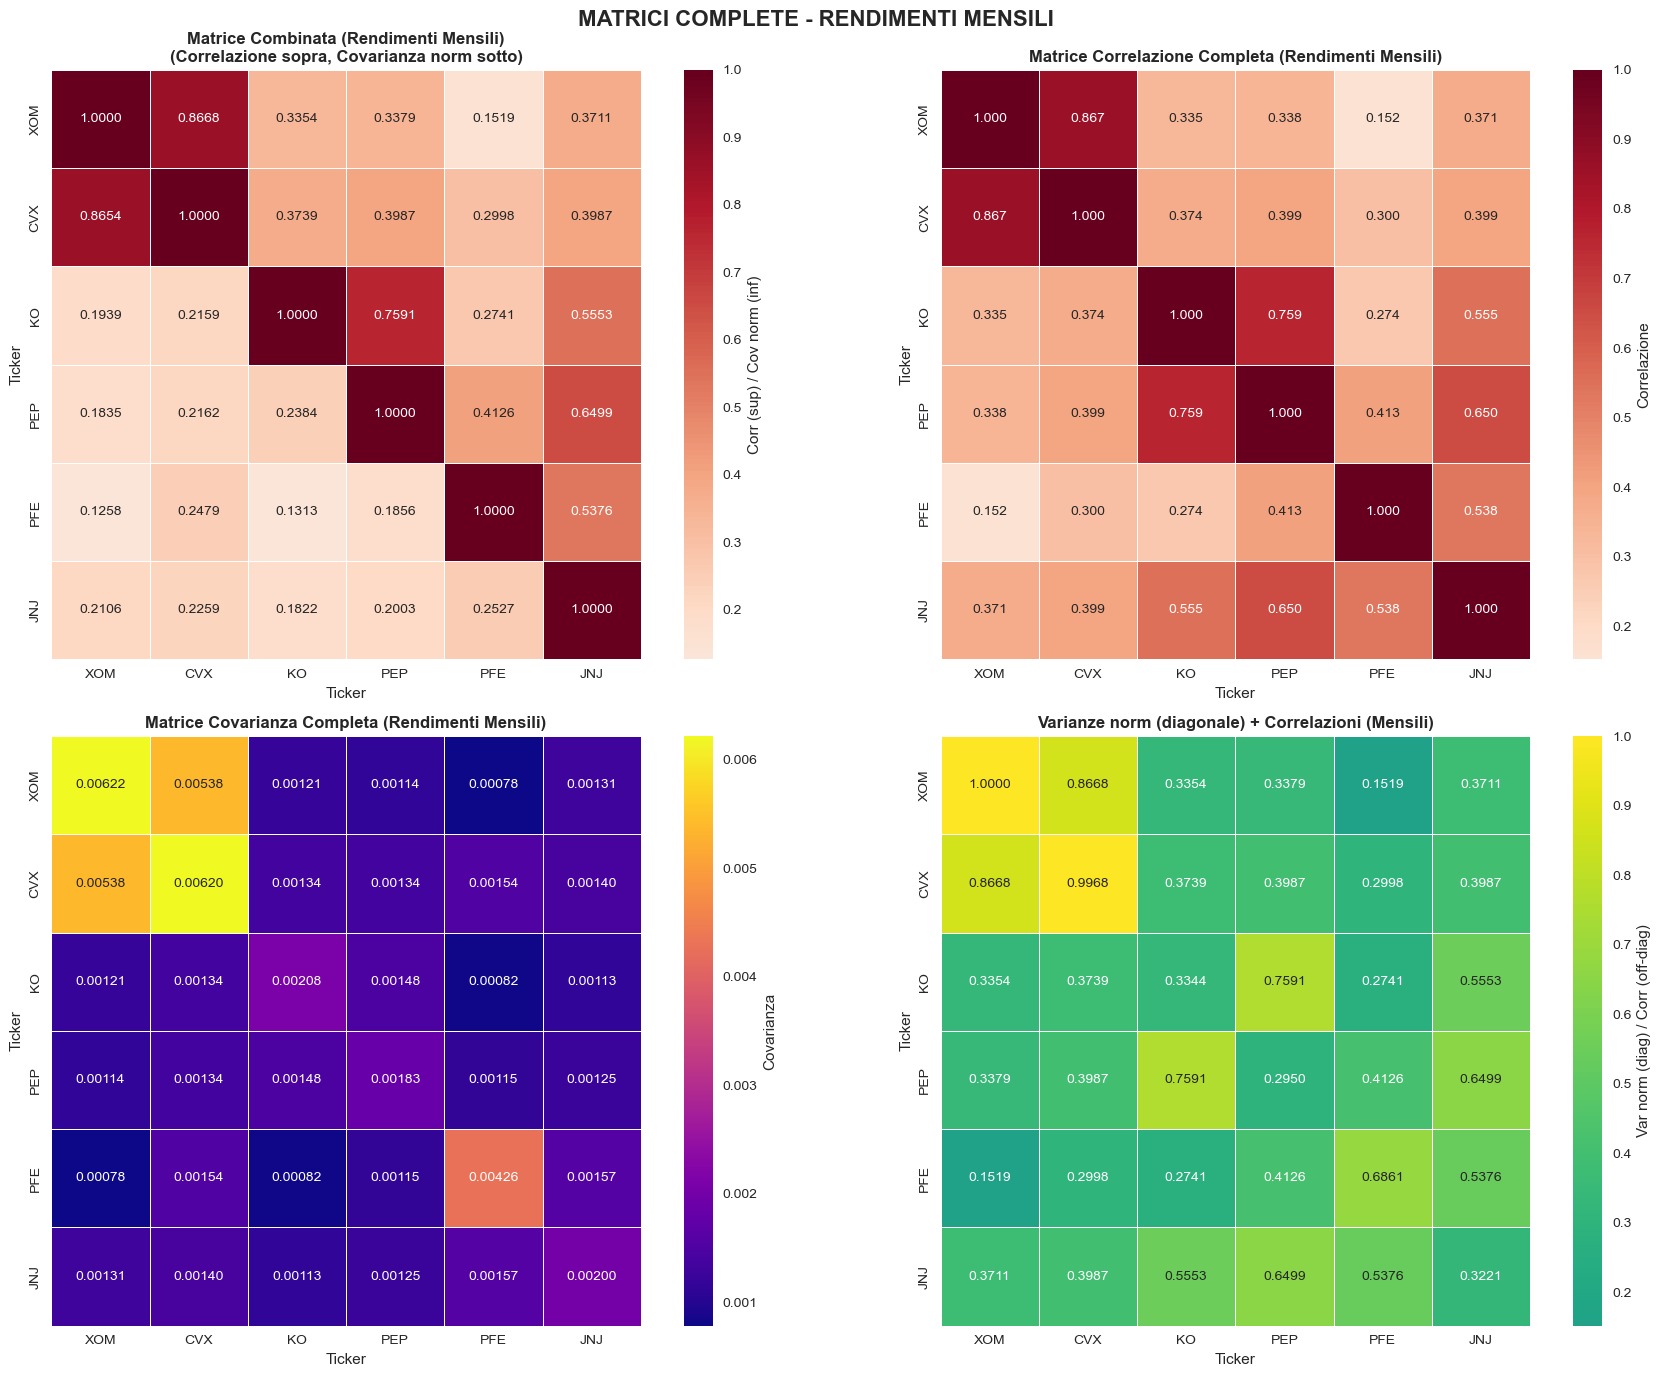

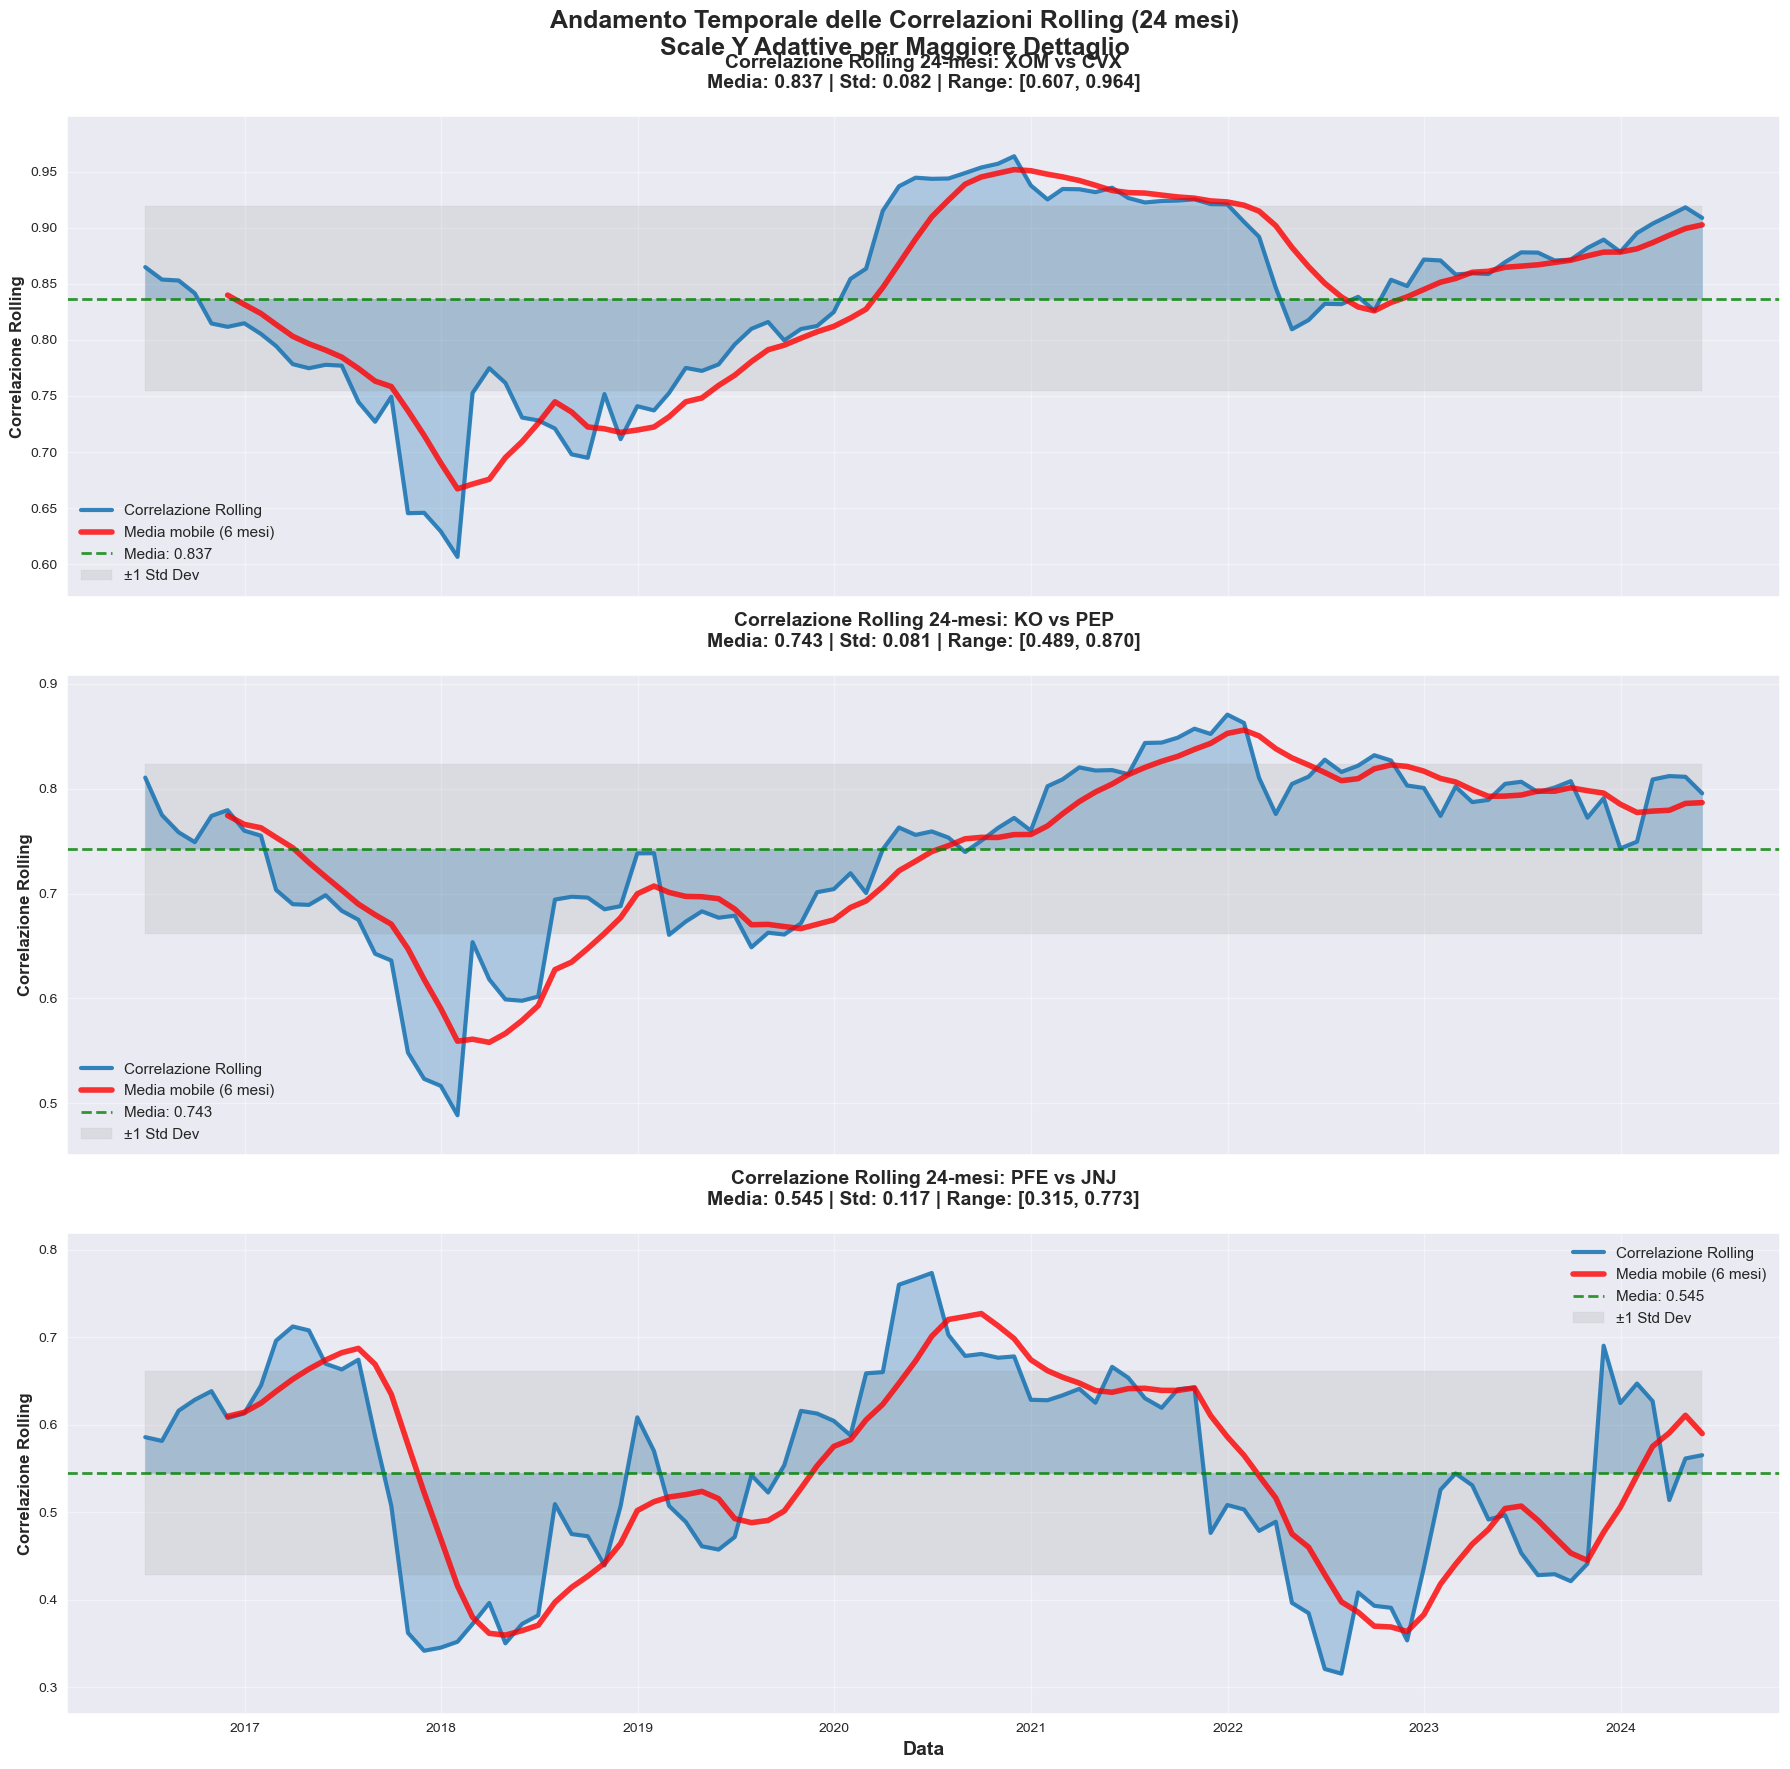


TABELLA RIASSUNTIVA COMPLETA - RENDIMENTI MENSILI

TABELLA COMPLETA (STATISTICHE MENSILI):
    Coppia  Correlazione  Covarianza     Var_A     Var_B  StdDev_A  StdDev_B  \
0  XOM-CVX      0.866816    0.005380  0.006216  0.006196  0.078844  0.078717   
1   KO-PEP      0.759110    0.001482  0.002079  0.001834  0.045591  0.042820   
2  PFE-JNJ      0.537556    0.001571  0.004265  0.002002  0.065307  0.044747   

   Prod_StdDev  Vol_Ann_A  Vol_Ann_B  
0     0.006206   0.273124   0.272683  
1     0.001952   0.157931   0.148332  
2     0.002922   0.226229   0.155007  

VERIFICA FORMULA: Corr = Cov / (σA × σB)
OK XOM-CVX: Calc=0.8668, Actual=0.8668, Diff=0.00000000
OK KO-PEP: Calc=0.7591, Actual=0.7591, Diff=0.00000000
OK PFE-JNJ: Calc=0.5376, Actual=0.5376, Diff=0.00000000

VOLATILITÀ ANNUALIZZATE (Std_mensile × √12):
   • XOM: 0.2731 (27.31%)
   • CVX: 0.2727 (27.27%)
   • KO: 0.1579 (15.79%)
   • PEP: 0.1483 (14.83%)
   • PFE: 0.2262 (22.62%)
   • JNJ: 0.1550 (15.50%)


In [70]:
# ANALISI CORRELAZIONE, COVARIANZA E VARIANZA (VERSIONE ROBUSTA)

# FUNZIONI

def check_and_convert_to_monthly(prices):
    # Conversione a mensili con diversi metodi
    conversion_methods = {
        'ultimo_giorno': prices.resample('ME').last(),
        'media_mensile': prices.resample('ME').mean(),
        'forward_fill': prices.resample('ME').ffill()
    }

    # Seleziona il metodo con più osservazioni
    best_method = None
    max_obs = 0

    for method_name, monthly_prices in conversion_methods.items():
        monthly_prices_clean = monthly_prices.dropna()
        n_obs = len(monthly_prices_clean)

        if n_obs > max_obs:
            max_obs = n_obs
            best_method = method_name
            best_monthly_prices = monthly_prices_clean

    # Calcola rendimenti mensili
    monthly_ret = best_monthly_prices.pct_change().dropna()

    # Risolve MultiIndex se presente
    if isinstance(monthly_ret.columns, pd.MultiIndex):
        monthly_ret.columns = monthly_ret.columns.get_level_values(-1)

    return monthly_ret
    print(f"   • Numero osservazioni: {len(prices)}")
    print(f"   • Numero ticker: {len(prices.columns)}")

    # Conversione a mensili con diversi metodi
    conversion_methods = {
        'ultimo_giorno': prices.resample('ME').last(),
        'media_mensile': prices.resample('ME').mean(),
        'forward_fill': prices.resample('ME').ffill()
    }

    print(f"\nMETODI DI CONVERSIONE TESTATI:")
    best_method = None
    max_obs = 0

    for method_name, monthly_prices in conversion_methods.items():
        monthly_prices_clean = monthly_prices.dropna()
        n_obs = len(monthly_prices_clean)
        print(f"   • {method_name}: {n_obs} osservazioni mensili")

        if n_obs > max_obs:
            max_obs = n_obs
            best_method = method_name
            best_monthly_prices = monthly_prices_clean

    print(f"\nMETODO SELEZIONATO: {best_method} ({max_obs} osservazioni)")

    # Calcola rendimenti mensili
    monthly_ret = best_monthly_prices.pct_change().dropna()

    # Risolve MultiIndex se presente
    if isinstance(monthly_ret.columns, pd.MultiIndex):
        print("Risoluzione MultiIndex rilevato...")
        monthly_ret.columns = monthly_ret.columns.get_level_values(-1)

    # Verifica finale
    print(f"\nRENDIMENTI MENSILI FINALI:")
    print(f"   • Periodo: {monthly_ret.index.min().strftime('%Y-%m')} a {monthly_ret.index.max().strftime('%Y-%m')}")
    print(f"   • Numero mesi: {len(monthly_ret)}")
    print(f"   • Ticker disponibili: {list(monthly_ret.columns)}")

    # Controllo qualità
    missing_data = monthly_ret.isnull().sum()
    if missing_data.any():
        print(f"\nDATI MANCANTI PER TICKER:")
        for ticker, missing in missing_data[missing_data > 0].items():
            print(f"   • {ticker}: {missing} mesi mancanti")
    else:
        print(f"\nNESSUN DATO MANCANTE")

    # Statistiche descrittive rapide
    print(f"\nSTATISTICHE DESCRITTIVE RENDIMENTI MENSILI:")
    stats_summary = monthly_ret.describe()
    print(f"   • Media min/max: {stats_summary.loc['mean'].min():.4f} / {stats_summary.loc['mean'].max():.4f}")
    print(f"   • Std min/max: {stats_summary.loc['std'].min():.4f} / {stats_summary.loc['std'].max():.4f}")

    return monthly_ret

def setup_data_and_matrices():
    # Conversione robusta a rendimenti mensili
    monthly_ret = check_and_convert_to_monthly(prices)

    pairs = [('XOM', 'CVX'), ('KO', 'PEP'), ('PFE', 'JNJ')]
    # Calcolo matrici con data disponibili
    try:
        cov_matrix = monthly_ret.cov()
        corr_matrix = monthly_ret.corr()
        var_series = monthly_ret.var()

        # Verifica che le matrici non siano vuote
        if cov_matrix.empty or corr_matrix.empty:
            raise ValueError("Matrici vuote dopo il calcolo")

        # Sottomatrici per ticker selezionati
        sub_matrices = {
            'corr': corr_matrix.loc[tickers, tickers],
            'cov': cov_matrix.loc[tickers, tickers],
            'var': var_series[tickers]
        }


    except Exception as e:
        print(f"ERRORE nel calcolo matrici: {e}")
        return None, None, None, None, None, None, None

    return monthly_ret, pairs, tickers, corr_matrix, cov_matrix, var_series, sub_matrices

def print_statistics(pairs, corr_matrix, cov_matrix, var_series, sub_matrices):
    print("\n" + "="*80)
    print("MATRICI DI CORRELAZIONE, COVARIANZA E VARIANZA - RENDIMENTI MENSILI")
    print("="*80)

    # Statistiche per coppie
    print("\nSTATISTICHE DETTAGLIATE PER LE COPPIE SELEZIONATE:")
    print("-" * 70)
    print(f"{'Coppia':<12} {'Correlazione':<12} {'Covarianza':<15} {'Var A':<12} {'Var B':<12}")
    print("-" * 70)

    for a, b in pairs:
        try:
            stats = {
                'corr': float(corr_matrix.loc[a, b]),
                'cov': float(cov_matrix.loc[a, b]),
                'var_a': float(var_series[a]),
                'var_b': float(var_series[b])
            }
            print(f"{a}-{b:<9} {stats['corr']:<12.4f} {stats['cov']:<15.6f} {stats['var_a']:<12.6f} {stats['var_b']:<12.6f}")

            # Interpretazione rapida
            if abs(stats['corr']) > 0.7:
                strength = "FORTE"
            elif abs(stats['corr']) > 0.3:
                strength = "MODERATA"
            else:
                strength = "DEBOLE"

            direction = "POSITIVA" if stats['corr'] > 0 else "NEGATIVA"
            print(f"          → Correlazione {strength} {direction}")

        except KeyError as e:
            print(f"{a}-{b}: Errore - {e}")

    # Matrici complete con interpretazione
    print(f"\nMATRICI COMPLETE (RENDIMENTI MENSILI):")
    print(f"Ticker analizzati: {list(sub_matrices['var'].index)}")

    matrices_info = [
        ('CORRELAZIONE', sub_matrices['corr'], 4),
        ('COVARIANZA', sub_matrices['cov'], 6)
    ]

    for name, matrix, decimals in matrices_info:
        print(f"\nMATRICE DI {name}:")
        print(matrix.round(decimals))

        if name == 'CORRELAZIONE':
            # Analisi correlazioni
            off_diag = matrix.values[np.triu_indices_from(matrix.values, k=1)]
            print(f"   Analisi correlazioni:")
            print(f"      • Media: {off_diag.mean():.4f}")
            print(f"      • Min: {off_diag.min():.4f}")
            print(f"      • Max: {off_diag.max():.4f}")

            strong_corr = np.sum(np.abs(off_diag) > 0.7)
            print(f"      • Correlazioni forti (|r| > 0.7): {strong_corr}")

    print(f"\nVARIANZE INDIVIDUALI (RENDIMENTI MENSILI):")
    for ticker in sub_matrices['var'].index:
        var_val = sub_matrices['var'][ticker]
        std_val = np.sqrt(var_val)
        print(f"   • {ticker}: Var = {var_val:.6f}, Std = {std_val:.4f} ({std_val*100:.2f}% mensile)")

def create_heatmap(data, ax, title, cmap, mask=None, fmt='.3f', cbar_label=''):
    #Funzione helper per creare heatmap
    sns.heatmap(data, annot=True, cmap=cmap, center=0 if 'Corr' in cbar_label else None,
                mask=mask, square=True, ax=ax, cbar_kws={'label': cbar_label},
                fmt=fmt, linewidths=0.5, linecolor='white')
    ax.set_title(title, fontweight='bold', fontsize=12)

def create_main_figure(sub_matrices):
    #Crea figura principale con correlazione, covarianza e varianze
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.25)

    # Configurazioni heatmap
    heatmap_configs = [
        (sub_matrices['corr'], gs[0, 0], 'Matrice di Correlazione (Rendimenti Mensili)\n(Solo triangolo inferiore)',
         'RdBu_r', np.triu(np.ones_like(sub_matrices['corr'], dtype=bool), k=1), '.3f', 'Correlazione'),
        (sub_matrices['cov'], gs[0, 1], 'Matrice di Covarianza (Rendimenti Mensili)\n(Solo triangolo inferiore)',
         'viridis', np.triu(np.ones_like(sub_matrices['cov'], dtype=bool), k=1), '.4f', 'Covarianza')
    ]

    # Crea heatmap
    for data, grid_pos, title, cmap, mask, fmt, cbar_label in heatmap_configs:
        ax = fig.add_subplot(grid_pos)
        create_heatmap(data, ax, title, cmap, mask, fmt, cbar_label)

    # Barplot varianze
    ax3 = fig.add_subplot(gs[1, :])
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    tickers = sub_matrices['var'].index
    bars = ax3.bar(tickers, sub_matrices['var'].values,
                   color=colors[:len(tickers)], alpha=0.8, edgecolor='black', linewidth=1)

    ax3.set_title('Varianze Individuali dei Ticker (Rendimenti Mensili)', fontweight='bold', fontsize=16)
    ax3.set_ylabel('Varianza Mensile', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Ticker', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')

    # Valori sopra barre con volatilità mensile e annualizzata
    for bar, ticker in zip(bars, tickers):
        height = bar.get_height()
        monthly_vol = np.sqrt(height)
        annual_vol = monthly_vol * np.sqrt(12)
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'Var: {height:.4f}\nVol: {monthly_vol:.3f}\n(Ann: {annual_vol:.3f})',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

    fig.suptitle('ANALISI CORRELAZIONE, COVARIANZA E VARIANZA - RENDIMENTI MENSILI',
                 fontweight='bold', fontsize=18, y=0.95)
    plt.show()

def create_scatter_plots(monthly_ret, pairs, corr_matrix, cov_matrix):
    #Crea scatter plots per le coppie
    fig, axes = plt.subplots(1, len(pairs), figsize=(20, 6))

    for i, (a, b) in enumerate(pairs):
        try:
            temp_df = monthly_ret[[a, b]].dropna()

            if temp_df.empty:
                axes[i].text(0.5, 0.5, f'Dati mancanti\nper {a}-{b}', ha='center', va='center',
                           transform=axes[i].transAxes, fontsize=12, fontweight='bold')
                continue

            # Scatter + regressione
            sns.scatterplot(data=temp_df, x=a, y=b, ax=axes[i], alpha=0.7, s=60,
                           edgecolor='black', linewidth=0.5)
            sns.regplot(data=temp_df, x=a, y=b, ax=axes[i], scatter=False, color='red',
                       line_kws={'linewidth': 3, 'alpha': 0.8})

            # Statistiche e formattazione
            corr_val = float(corr_matrix.loc[a, b])
            cov_val = float(cov_matrix.loc[a, b])
            n_obs = len(temp_df)

            axes[i].set_title(f'{a} vs {b} (Rendimenti Mensili)\nCorr = {corr_val:.3f} | Cov = {cov_val:.5f} | N = {n_obs}',
                            fontweight='bold', fontsize=11)
            axes[i].set_xlabel(f'{a} (Rendimento Mensile)', fontweight='bold', fontsize=10)
            axes[i].set_ylabel(f'{b} (Rendimento Mensile)', fontweight='bold', fontsize=10)
            axes[i].grid(True, alpha=0.3)

            # Linee di riferimento
            for line_val in [0]:
                axes[i].axhline(y=line_val, color='gray', linestyle='--', alpha=0.5)
                axes[i].axvline(x=line_val, color='gray', linestyle='--', alpha=0.5)

        except KeyError as e:
            axes[i].text(0.5, 0.5, f'Errore:\n{a}-{b}', ha='center', va='center',
                        transform=axes[i].transAxes, fontsize=12, fontweight='bold', color='red')

    fig.suptitle('Scatter Plots delle Coppie con Linee di Regressione (Rendimenti Mensili)',
                 fontweight='bold', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def create_time_series_plots(monthly_ret, pairs, corr_matrix):
    #Crea grafici serie temporali
    fig, axes = plt.subplots(len(pairs), 1, figsize=(16, 4*len(pairs)), sharex=True)

    for i, (a, b) in enumerate(pairs):
        try:
            # Plot con styling
            monthly_ret[[a, b]].plot(ax=axes[i], linewidth=2.5, alpha=0.8,
                                   style=['-', '--'], color=['#1f77b4', '#ff7f0e'])

            n_months = len(monthly_ret[[a, b]].dropna())
            axes[i].set_title(f'Rendimenti Mensili: {a} e {b} | Corr = {corr_matrix.loc[a, b]:.3f} | {n_months} mesi',
                            fontweight='bold', fontsize=14)
            axes[i].set_ylabel('Rendimento Mensile', fontweight='bold', fontsize=12)
            axes[i].grid(True, alpha=0.3)
            axes[i].legend(fontsize=11, loc='upper right')

            # Linee di riferimento e bande volatilità
            axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

            for j, ticker in enumerate([a, b]):
                std_val = monthly_ret[ticker].std()
                color = ['#1f77b4', '#ff7f0e'][j]
                for sign in [1, -1]:
                    axes[i].axhline(y=sign*std_val, color=color, linestyle=':', alpha=0.5, linewidth=1)

        except KeyError as e:
            axes[i].text(0.5, 0.5, f'Errore: {a}-{b}', ha='center', va='center',
                        transform=axes[i].transAxes, fontsize=12, fontweight='bold', color='red')

    axes[-1].set_xlabel('Data (Mensile)', fontweight='bold', fontsize=12)
    fig.suptitle('Serie Temporali dei Rendimenti Mensili con Bande di Volatilità',
                fontweight='bold', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

def create_combined_matrices(sub_matrices):
    #Crea figura con matrici combinate
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    tickers = sub_matrices['var'].index

    # Matrice combinata
    combined_matrix = sub_matrices['corr'].copy()
    max_cov = sub_matrices['cov'].values.max()
    for i in range(len(tickers)):
        for j in range(len(tickers)):
            if i > j:
                combined_matrix.iloc[i, j] = sub_matrices['cov'].iloc[i, j] / max_cov

    # Matrice varianze + correlazioni
    var_corr_matrix = sub_matrices['corr'].copy()
    np.fill_diagonal(var_corr_matrix.values, sub_matrices['var'].values)
    var_corr_norm = var_corr_matrix.copy()
    max_var = sub_matrices['var'].max()
    for i in range(len(tickers)):
        var_corr_norm.iloc[i, i] = sub_matrices['var'].iloc[i] / max_var

    # Configurazioni per tutte le heatmap
    heatmap_configs = [
        (combined_matrix, 'Matrice Combinata (Rendimenti Mensili)\n(Correlazione sopra, Covarianza norm sotto)',
         'RdBu_r', '.4f', 'Corr (sup) / Cov norm (inf)'),
        (sub_matrices['corr'], 'Matrice Correlazione Completa (Rendimenti Mensili)', 'RdBu_r', '.3f', 'Correlazione'),
        (sub_matrices['cov'], 'Matrice Covarianza Completa (Rendimenti Mensili)', 'plasma', '.5f', 'Covarianza'),
        (var_corr_norm, 'Varianze norm (diagonale) + Correlazioni (Mensili)', 'viridis', '.4f',
         'Var norm (diag) / Corr (off-diag)')
    ]

    # Crea tutte le heatmap
    for idx, (data, title, cmap, fmt, cbar_label) in enumerate(heatmap_configs):
        ax = axes.flat[idx]
        create_heatmap(data, ax, title, cmap, fmt=fmt, cbar_label=cbar_label)

    fig.suptitle('MATRICI COMPLETE - RENDIMENTI MENSILI', fontweight='bold', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

def create_summary_table(pairs, corr_matrix, cov_matrix, var_series):
    #Crea e stampa tabella riassuntiva
    print(f"\n{'='*80}")
    print("TABELLA RIASSUNTIVA COMPLETA - RENDIMENTI MENSILI")
    print(f"{'='*80}")

    summary_data = []
    for a, b in pairs:
        try:
            var_a, var_b = float(var_series[a]), float(var_series[b])
            std_a, std_b = np.sqrt(var_a), np.sqrt(var_b)

            summary_data.append({
                'Coppia': f"{a}-{b}",
                'Correlazione': float(corr_matrix.loc[a, b]),
                'Covarianza': float(cov_matrix.loc[a, b]),
                'Var_A': var_a, 'Var_B': var_b,
                'StdDev_A': std_a, 'StdDev_B': std_b,
                'Prod_StdDev': std_a * std_b,
                'Vol_Ann_A': std_a * np.sqrt(12),
                'Vol_Ann_B': std_b * np.sqrt(12)
            })
        except KeyError:
            continue

    summary_df = pd.DataFrame(summary_data)
    print("\nTABELLA COMPLETA (STATISTICHE MENSILI):")
    print(summary_df.round(6))

    # Verifica formula
    print(f"\nVERIFICA FORMULA: Corr = Cov / (σA × σB)")
    for _, row in summary_df.iterrows():
        calculated_corr = row['Covarianza'] / row['Prod_StdDev']
        diff = abs(calculated_corr - row['Correlazione'])
        status = "OK" if diff < 1e-6 else "WARNING"
        print(f"{status} {row['Coppia']}: Calc={calculated_corr:.4f}, Actual={row['Correlazione']:.4f}, "
              f"Diff={diff:.8f}")

    # Statistiche annualizzate
    print(f"\nVOLATILITÀ ANNUALIZZATE (Std_mensile × √12):")
    for _, row in summary_df.iterrows():
        print(f"   • {row['Coppia'].split('-')[0]}: {row['Vol_Ann_A']:.4f} ({row['Vol_Ann_A']*100:.2f}%)")
        print(f"   • {row['Coppia'].split('-')[1]}: {row['Vol_Ann_B']:.4f} ({row['Vol_Ann_B']*100:.2f}%)")

def create_rolling_correlation_plots(monthly_ret, pairs, window=24):
    # Figura più alta e con più spazio tra subplot
    fig, axes = plt.subplots(len(pairs), 1, figsize=(18, 6*len(pairs)), sharex=True)
    plt.subplots_adjust(hspace=0.4)  # Più spazio tra i grafici

    if len(pairs) == 1:
        axes = [axes]

    for i, (a, b) in enumerate(pairs):
        try:
            # Calcola correlazione rolling
            rolling_corr = monthly_ret[a].rolling(window=window).corr(monthly_ret[b])
            rolling_corr = rolling_corr.dropna()

            if rolling_corr.empty:
                axes[i].text(0.5, 0.5, f'Dati insufficienti\nper {a}-{b}',
                           ha='center', va='center', transform=axes[i].transAxes,
                           fontsize=12, fontweight='bold')
                continue

            # Calcola prima le statistiche
            corr_mean = rolling_corr.mean()
            corr_std = rolling_corr.std()
            corr_min = rolling_corr.min()
            corr_max = rolling_corr.max()

            # Plot correlazione rolling con area riempita
            axes[i].plot(rolling_corr.index, rolling_corr.values,
                        linewidth=3, color='#1f77b4', alpha=0.9, label='Correlazione Rolling')
            axes[i].fill_between(rolling_corr.index, rolling_corr.values, corr_mean,
                                alpha=0.3, color='#1f77b4')

            # Media mobile della correlazione
            rolling_corr_smooth = rolling_corr.rolling(window=6).mean()
            axes[i].plot(rolling_corr_smooth.index, rolling_corr_smooth.values,
                        linewidth=4, color='red', alpha=0.8, label=f'Media mobile (6 mesi)')

            # Linee di riferimento
            axes[i].axhline(y=corr_mean, color='green', linestyle='--', alpha=0.8,
                           linewidth=2, label=f'Media: {corr_mean:.3f}')

            # Solo se 0 è nel range visibile
            if corr_min < 0.1:
                axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

            # Bande di confidenza (media ± 1 std)
            axes[i].fill_between(rolling_corr.index,
                                corr_mean - corr_std, corr_mean + corr_std,
                                alpha=0.15, color='gray', label='±1 Std Dev')

            # Scale Y adattive con margine del 10%
            y_range = corr_max - corr_min
            y_margin = y_range * 0.1
            y_min = max(-1, corr_min - y_margin)
            y_max = min(1, corr_max + y_margin)
            axes[i].set_ylim(y_min, y_max)

            # Titolo e labels più grandi
            axes[i].set_title(f'Correlazione Rolling {window}-mesi: {a} vs {b}\n'
                            f'Media: {corr_mean:.3f} | Std: {corr_std:.3f} | '
                            f'Range: [{corr_min:.3f}, {corr_max:.3f}]',
                            fontweight='bold', fontsize=14, pad=20)
            axes[i].set_ylabel('Correlazione Rolling', fontweight='bold', fontsize=12)
            axes[i].grid(True, alpha=0.4)
            axes[i].legend(fontsize=11, loc='best')

            # Miglioramenti estetici
            axes[i].tick_params(labelsize=10)
            for spine in axes[i].spines.values():
                spine.set_linewidth(1.2)

        except KeyError as e:
            axes[i].text(0.5, 0.5, f'Errore: {a}-{b}\n{str(e)}',
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, fontweight='bold', color='red')

    axes[-1].set_xlabel('Data', fontweight='bold', fontsize=14)
    fig.suptitle(f'Andamento Temporale delle Correlazioni Rolling ({window} mesi)\nScale Y Adattive per Maggiore Dettaglio',
                 fontweight='bold', fontsize=18, y=0.98)
    plt.tight_layout()
    plt.show()

# ESECUZIONE ANALISI

# Setup dati e matrici con controlli
result = setup_data_and_matrices()

if result[0] is not None:  # Se il setup è andato a buon fine
    monthly_ret, pairs, tickers, corr_matrix, cov_matrix, var_series, sub_matrices = result

    # Stampa statistiche
    print_statistics(pairs, corr_matrix, cov_matrix, var_series, sub_matrices)

    # Crea tutti i grafici
    create_main_figure(sub_matrices)
    create_scatter_plots(monthly_ret, pairs, corr_matrix, cov_matrix)
    create_time_series_plots(monthly_ret, pairs, corr_matrix)
    create_combined_matrices(sub_matrices)
    create_rolling_correlation_plots(monthly_ret, pairs, window=24)
    # Tabella riassuntiva
    create_summary_table(pairs, corr_matrix, cov_matrix, var_series)


Ho implementato una configurazione dinamica dei periodi di training che può spiegare piccole differenze nella selezione dei parametri ARIMA rispetto all'approccio fisso

=== ANALISI ARIMA PORTFOLIO ===
Configurazione: 80/30/10 mesi

--- XOM ---
Stazionario: No
Modello ottimale: ARIMA(2, 1, 2) (AIC: 3786.759)


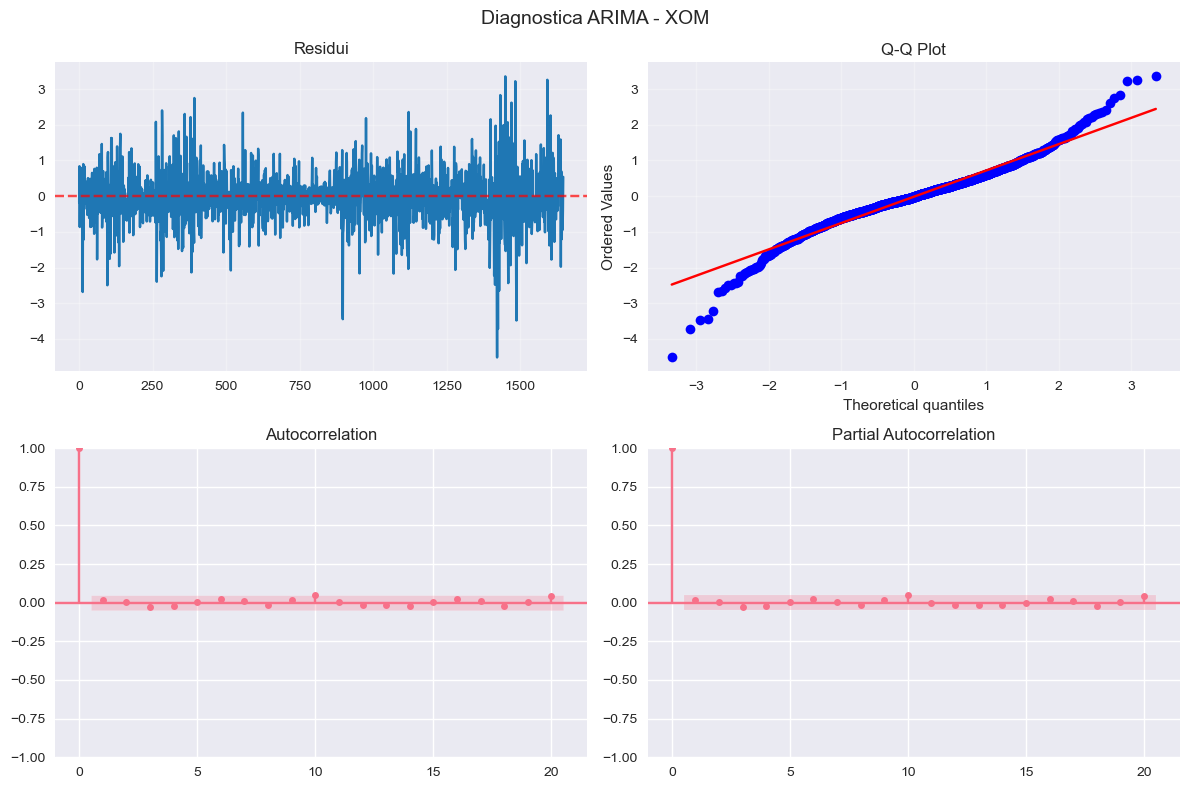

Ljung-Box p-value: 0.5397



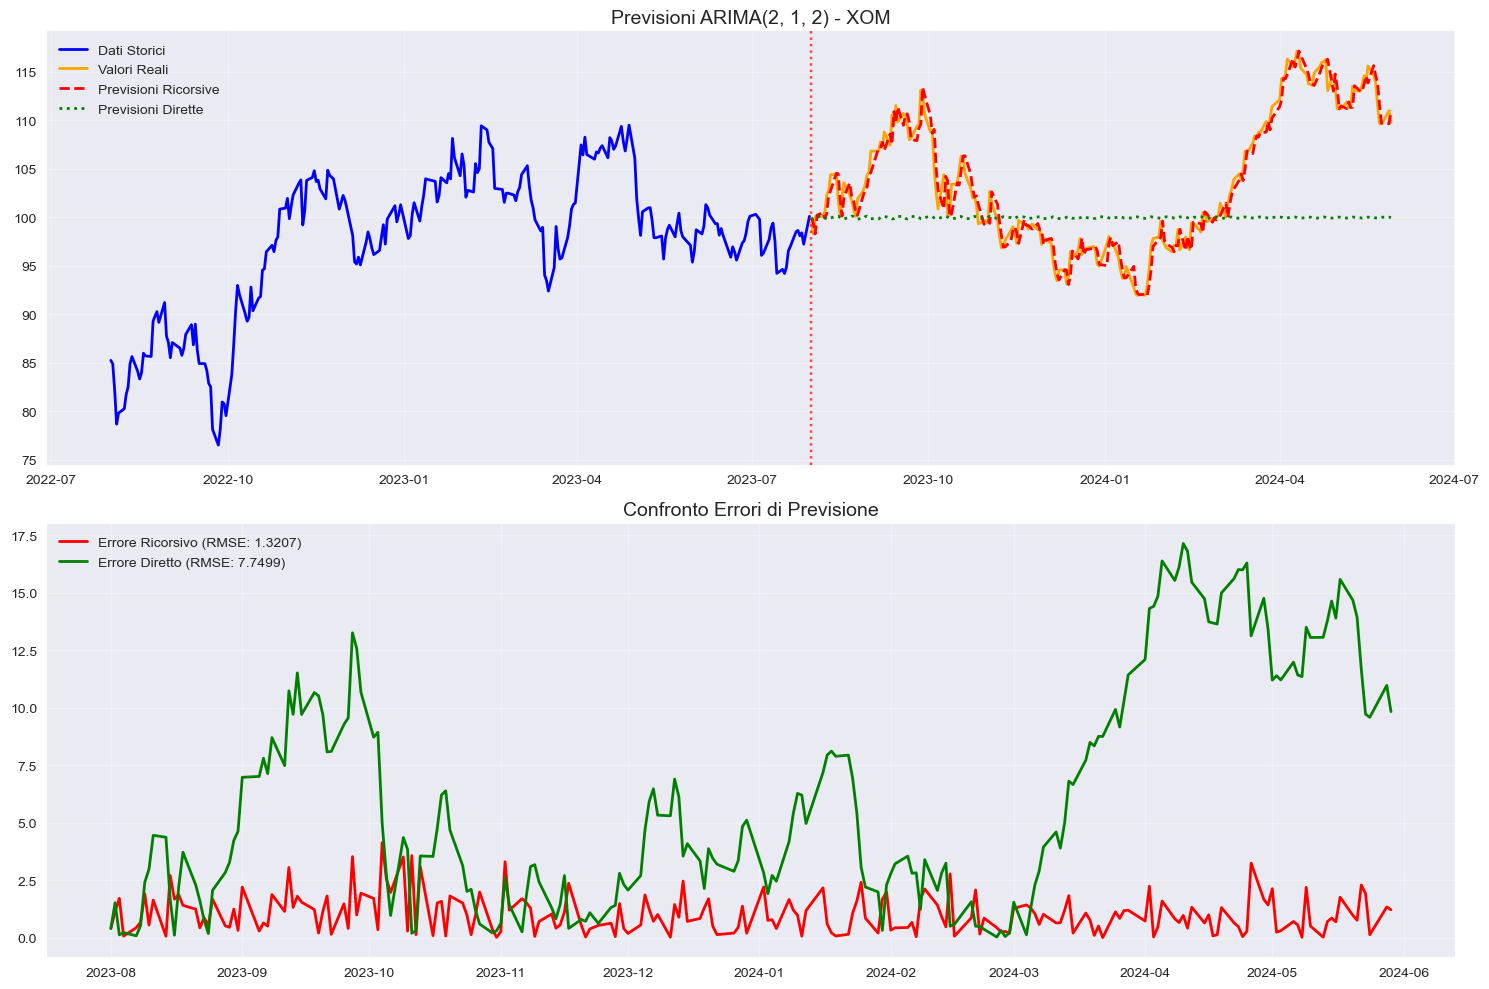

Metriche Test - RMSE: 42.5711, MAPE: 44.25%
Metriche Ricorsive - RMSE: 1.3207, MAPE: 1.00%
Metriche Dirette - RMSE: 7.7499, MAPE: 5.58%

--- CVX ---
Stazionario: No
Modello ottimale: ARIMA(2, 1, 2) (AIC: 5663.933)


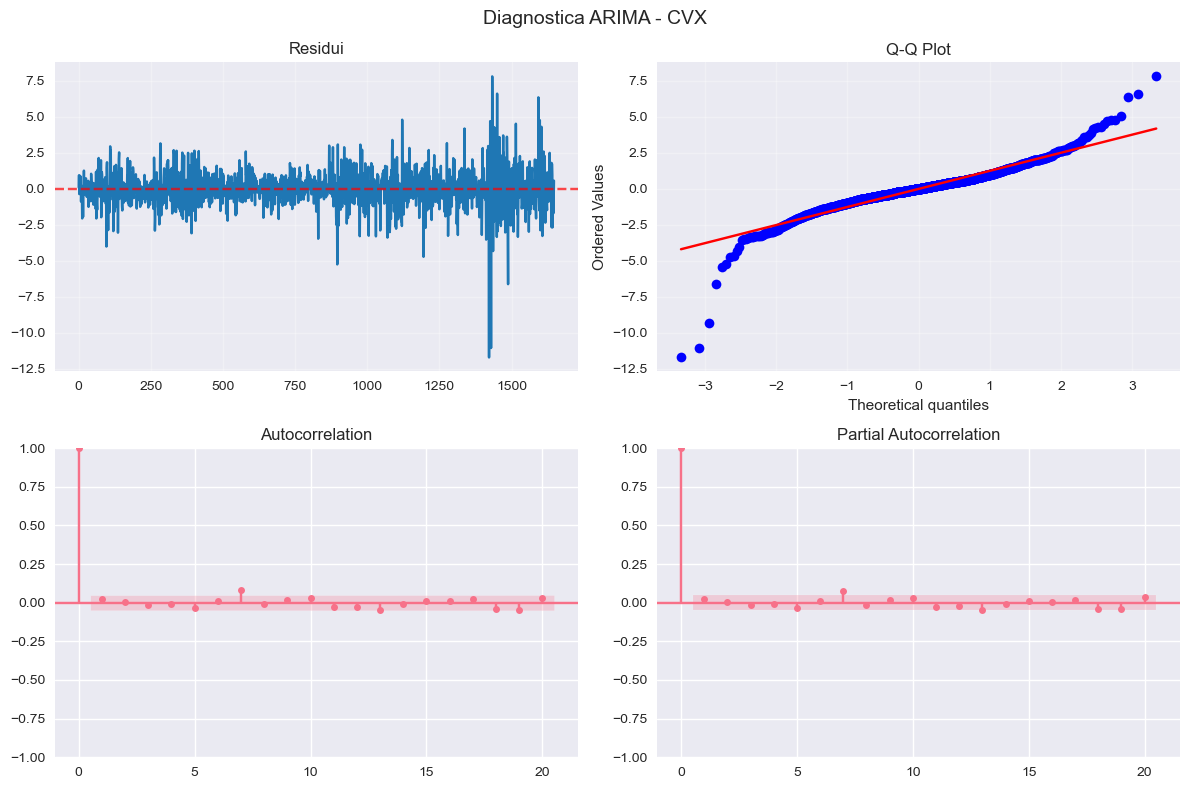

Ljung-Box p-value: 0.0505



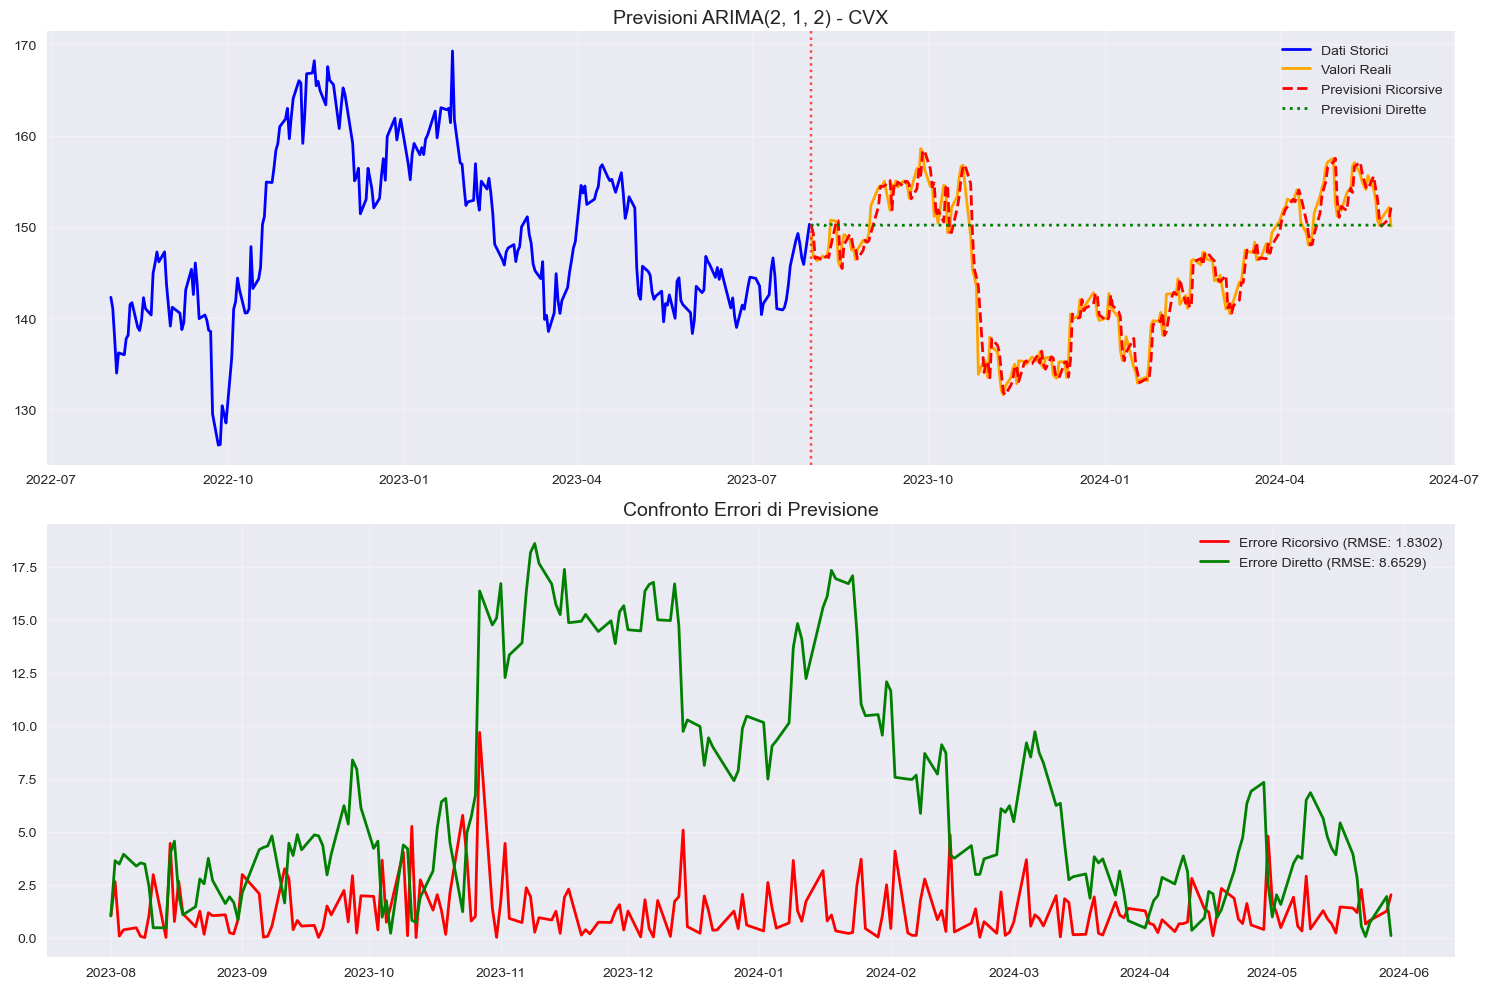

Metriche Test - RMSE: 57.6119, MAPE: 36.86%
Metriche Ricorsive - RMSE: 1.8302, MAPE: 0.89%
Metriche Dirette - RMSE: 8.6529, MAPE: 4.93%

--- KO ---
Stazionario: No
Modello ottimale: ARIMA(1, 1, 2) (AIC: 2136.878)


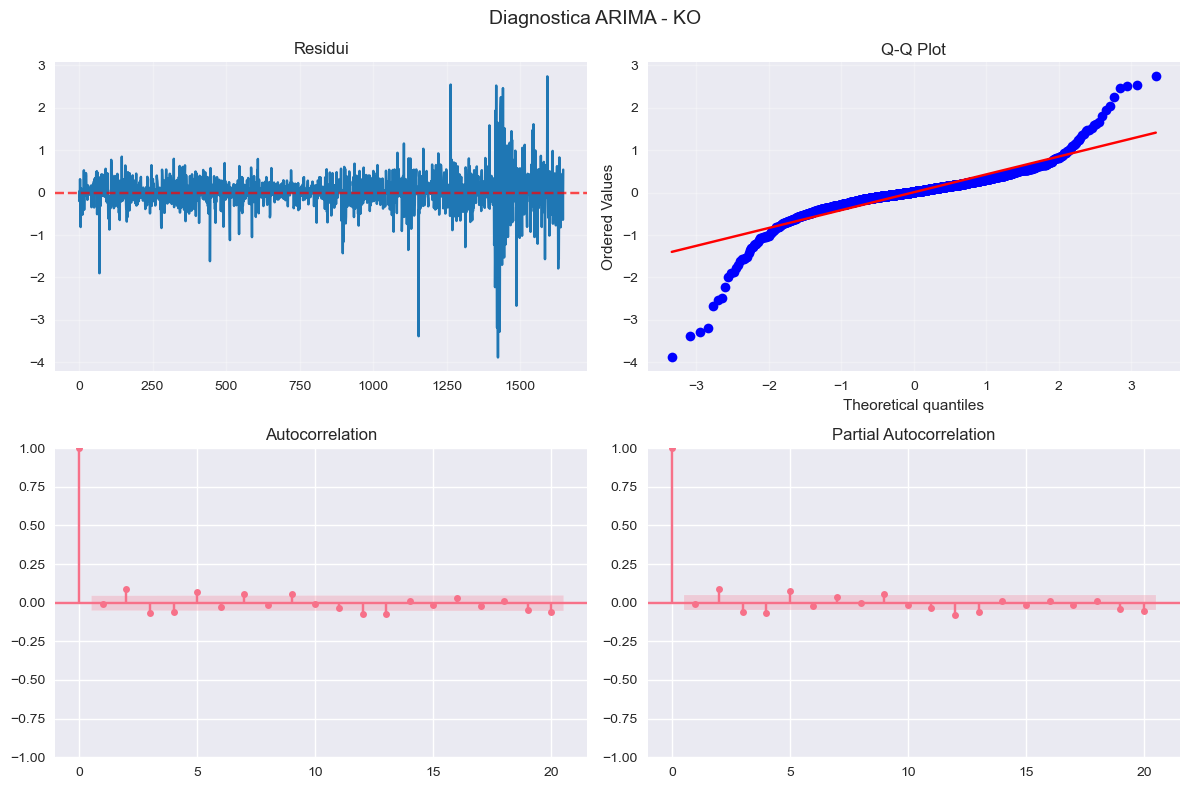

Ljung-Box p-value: 0.0000



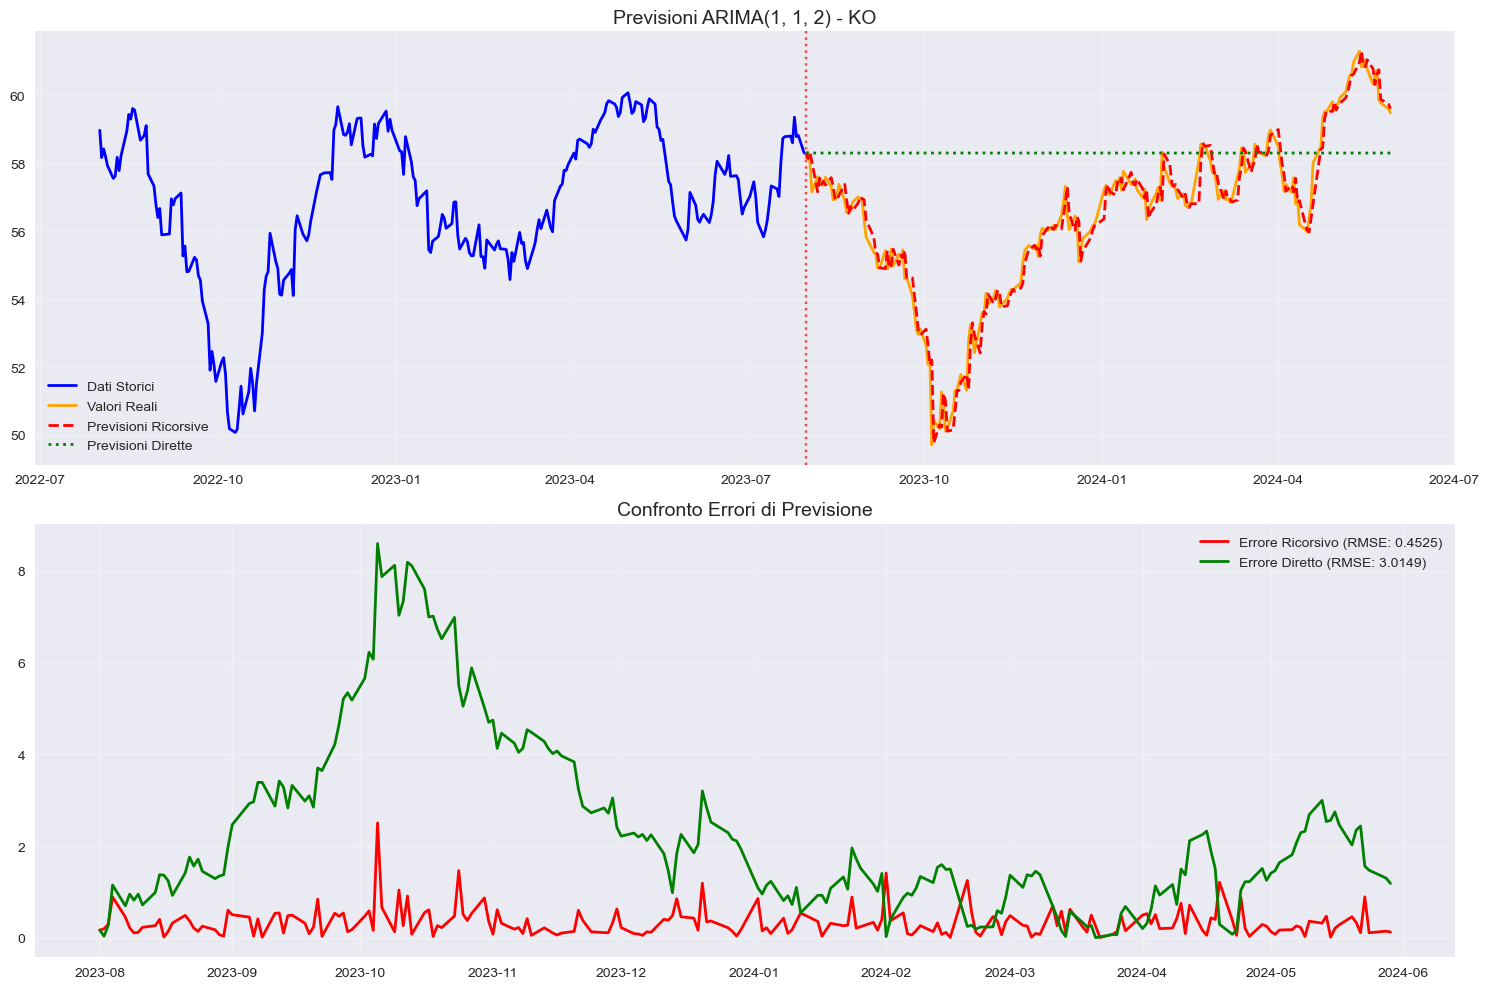

Metriche Test - RMSE: 11.5644, MAPE: 19.20%
Metriche Ricorsive - RMSE: 0.4525, MAPE: 0.60%
Metriche Dirette - RMSE: 3.0149, MAPE: 4.23%

--- PEP ---
Stazionario: No
Modello ottimale: ARIMA(2, 1, 2) (AIC: 5193.661)


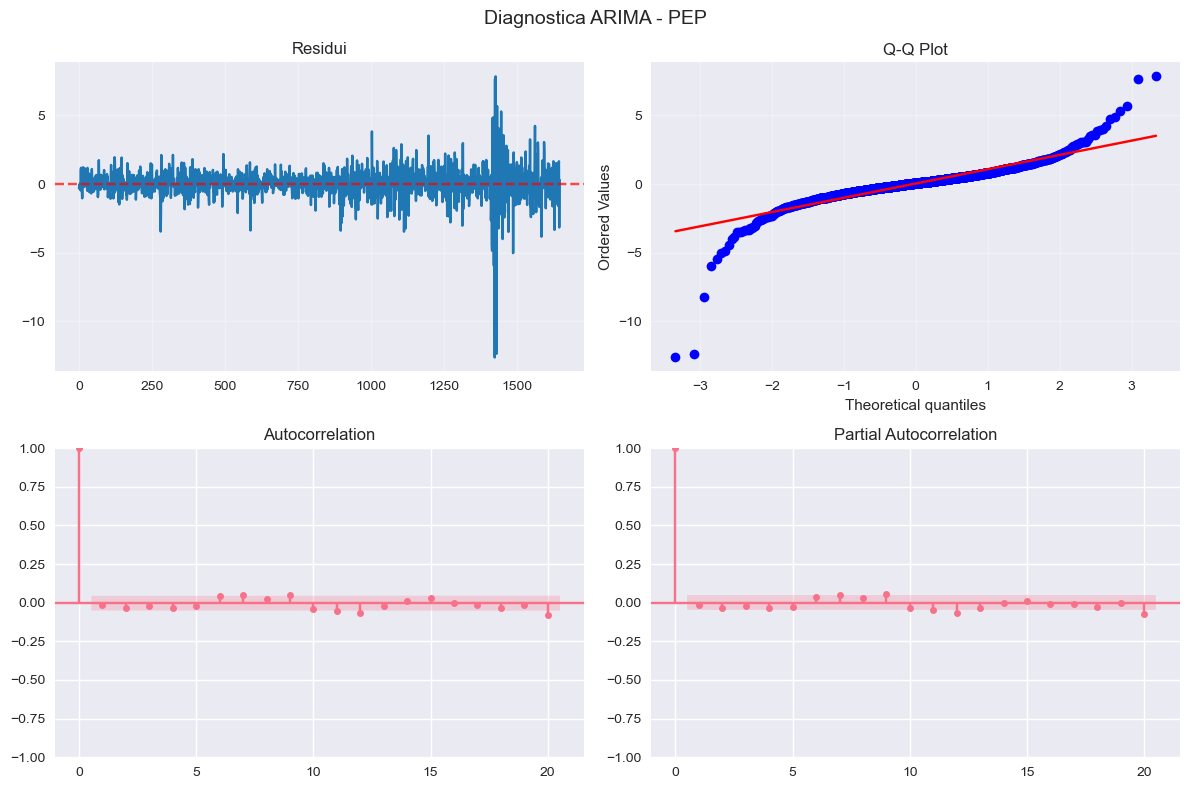

Ljung-Box p-value: 0.0183



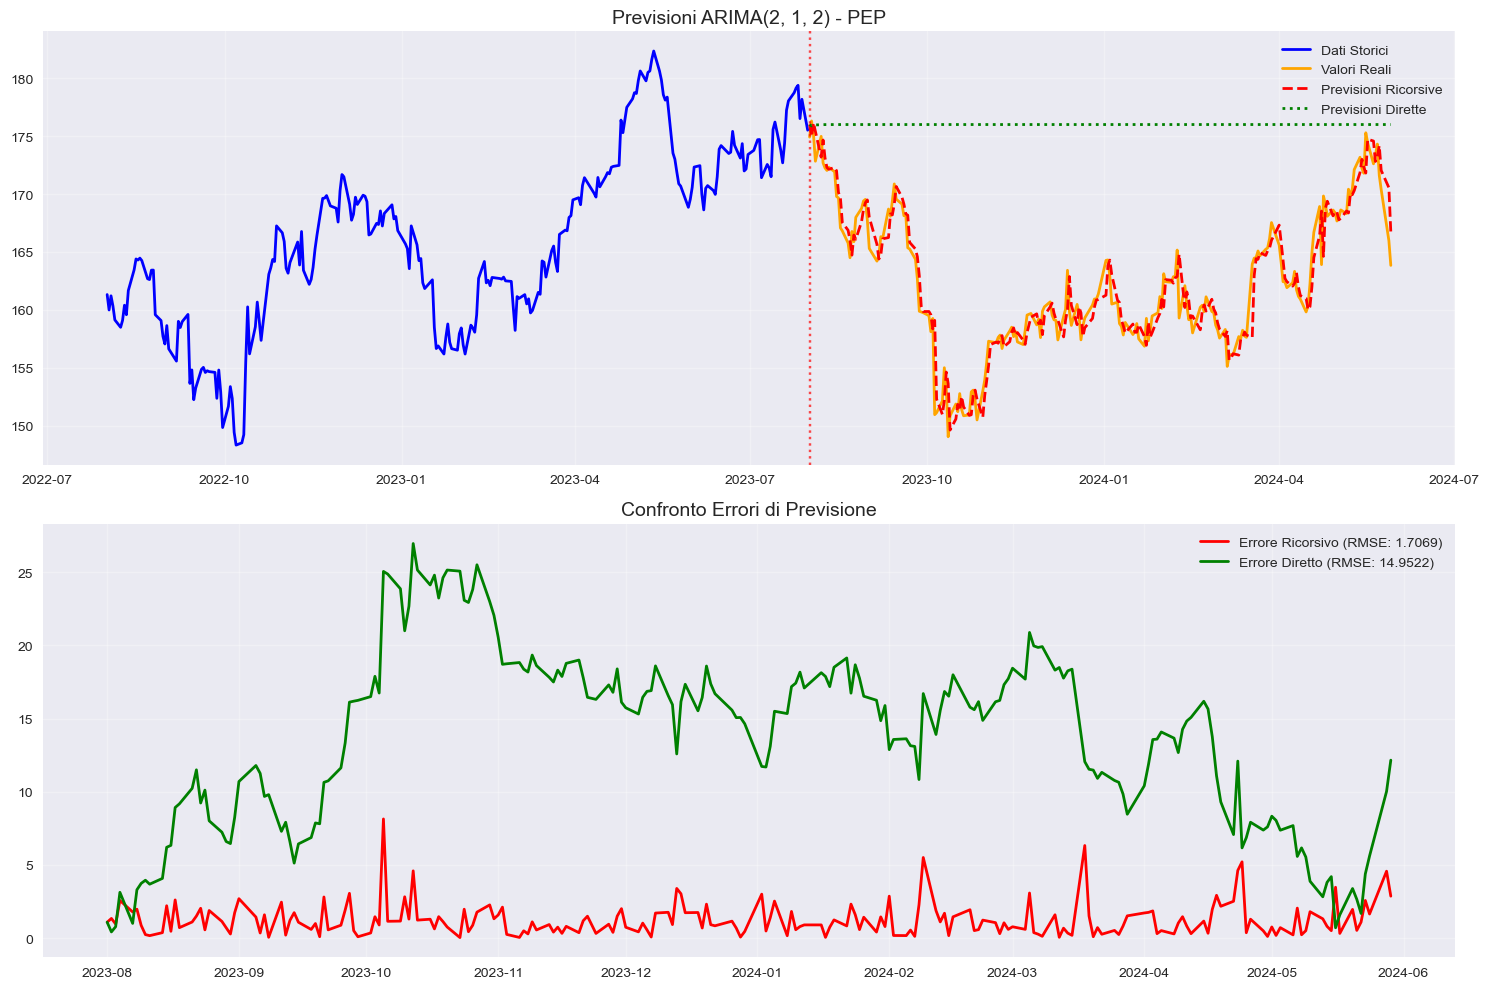

Metriche Test - RMSE: 33.8101, MAPE: 19.05%
Metriche Ricorsive - RMSE: 1.7069, MAPE: 0.78%
Metriche Dirette - RMSE: 14.9522, MAPE: 8.59%

--- PFE ---
Stazionario: No
Modello ottimale: ARIMA(2, 1, 2) (AIC: 1149.316)


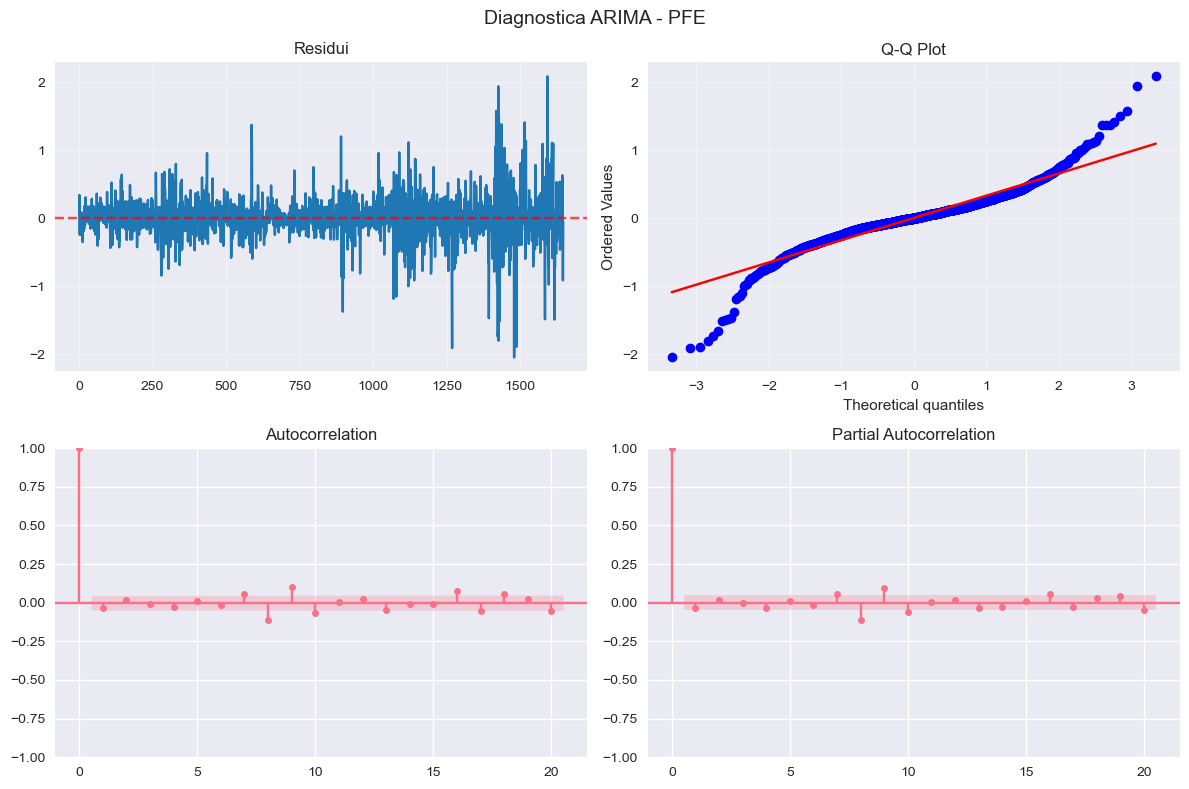

Ljung-Box p-value: 0.0000



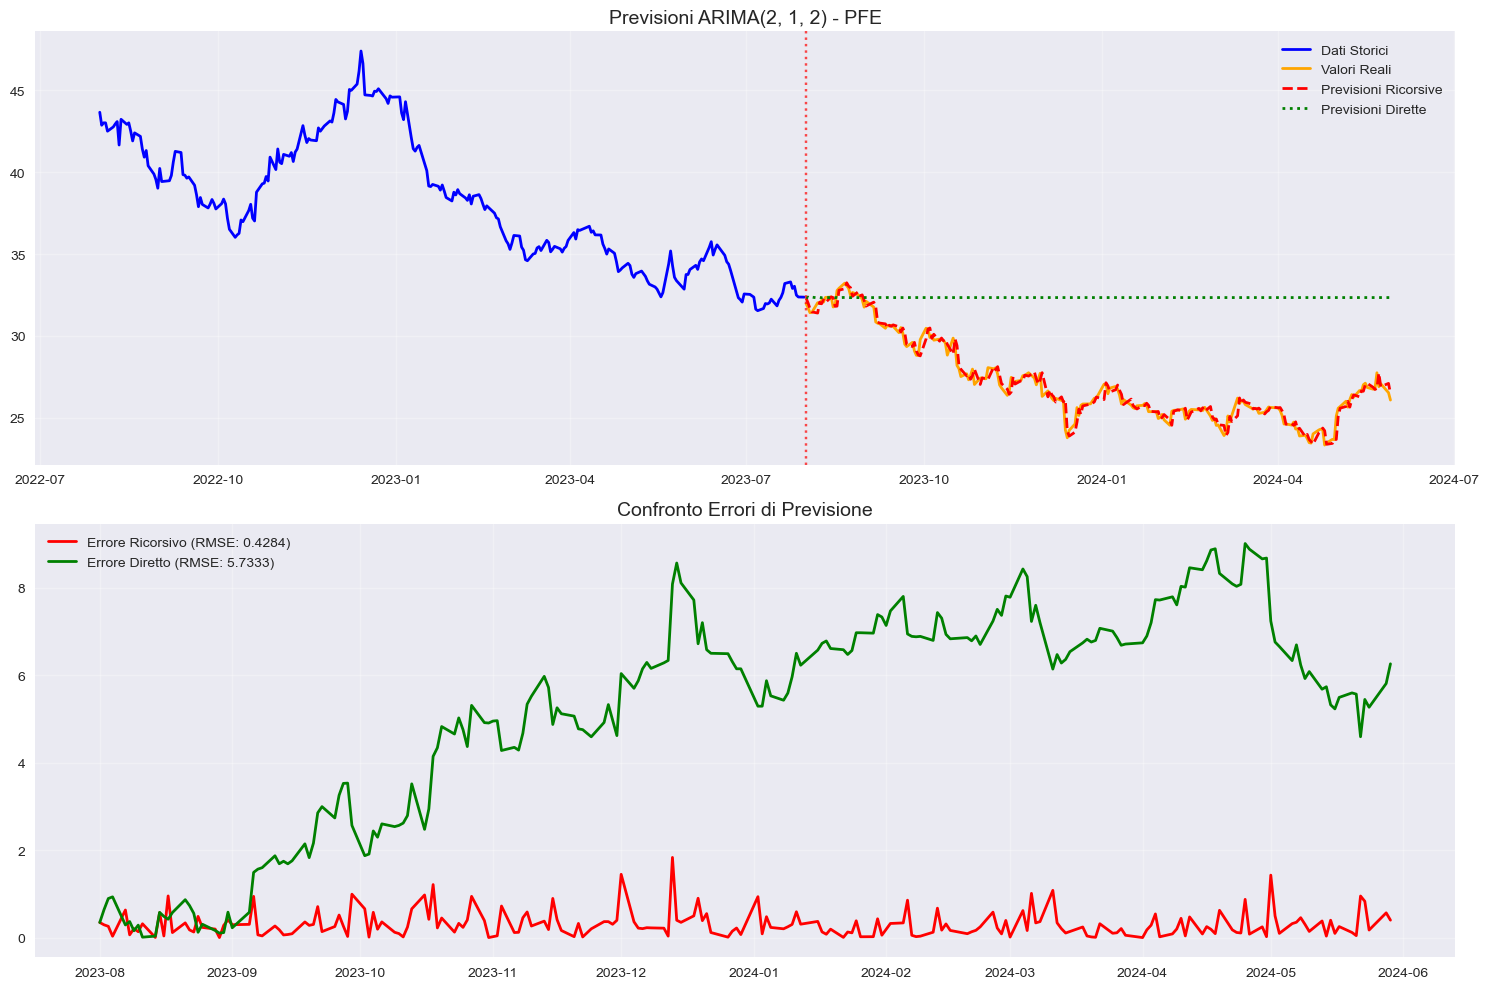

Metriche Test - RMSE: 10.5168, MAPE: 22.26%
Metriche Ricorsive - RMSE: 0.4284, MAPE: 1.15%
Metriche Dirette - RMSE: 5.7333, MAPE: 19.97%

--- JNJ ---
Stazionario: No
Modello ottimale: ARIMA(2, 1, 2) (AIC: 5561.377)


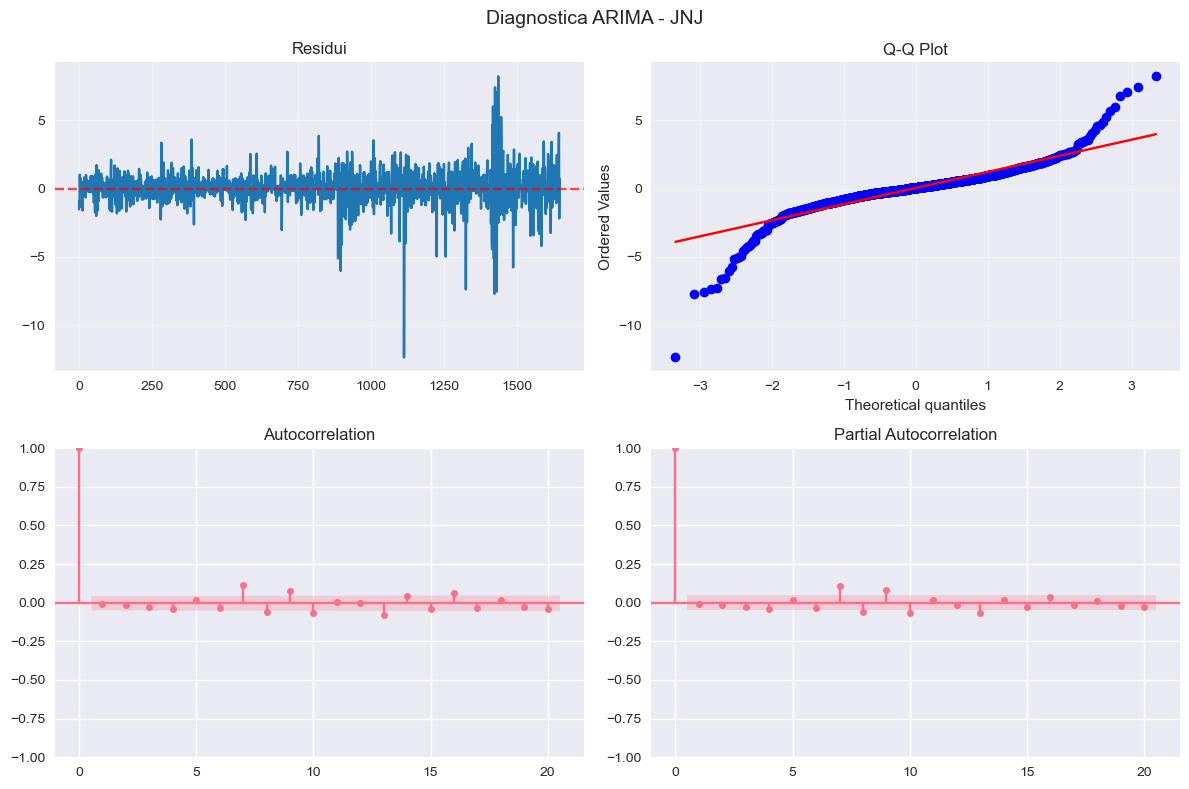

Ljung-Box p-value: 0.0000



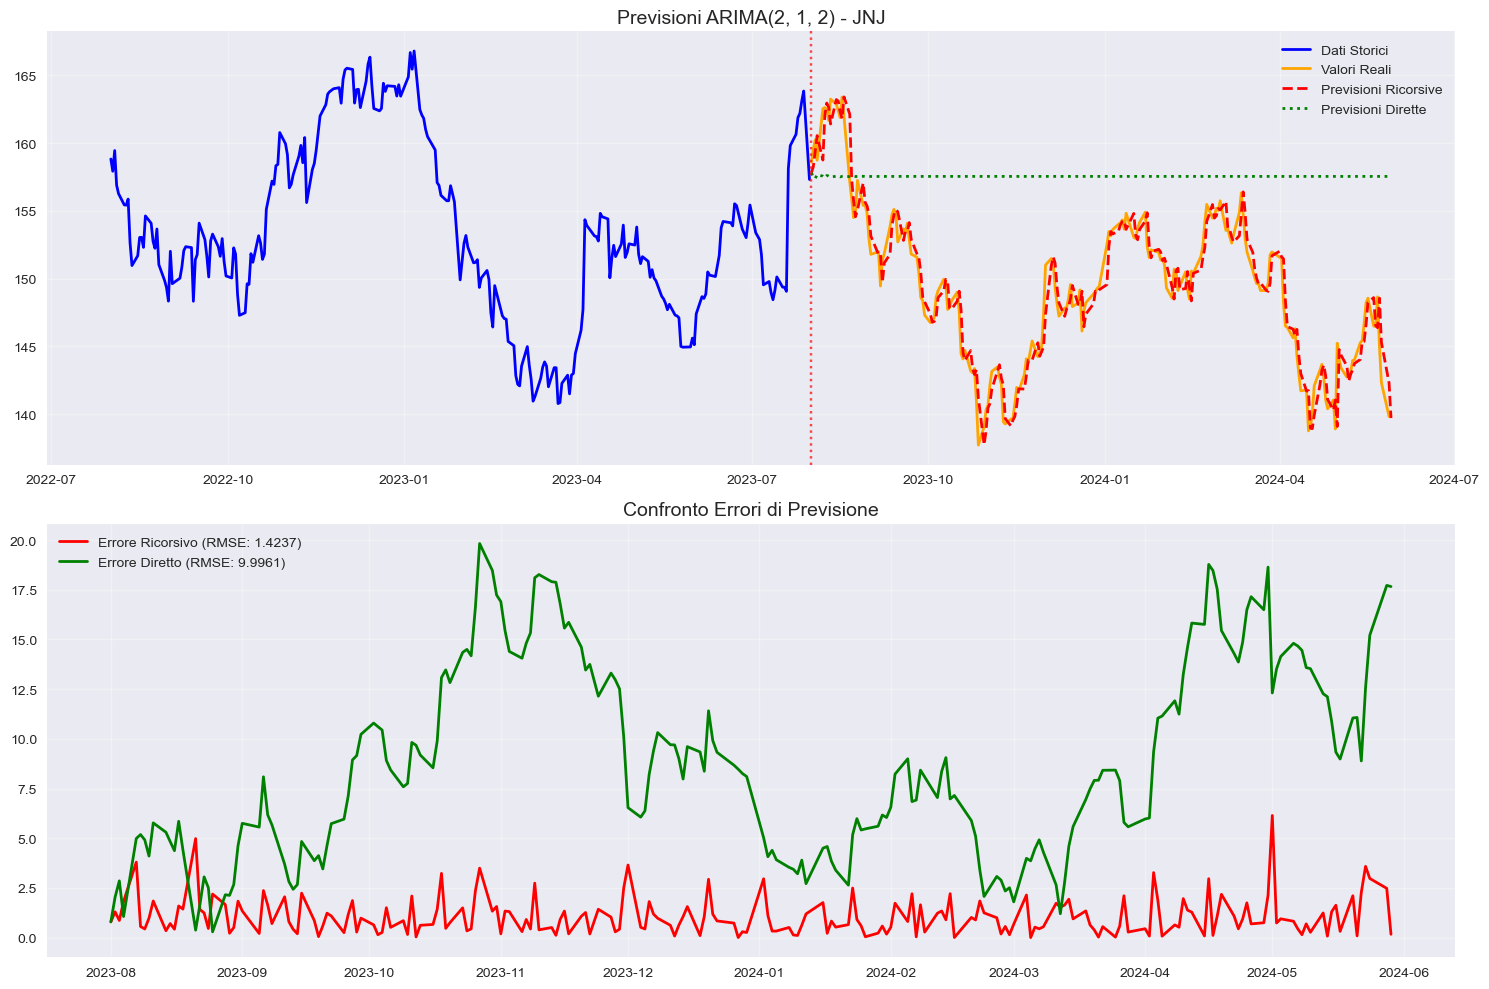

Metriche Test - RMSE: 7.8550, MAPE: 4.00%
Metriche Ricorsive - RMSE: 1.4237, MAPE: 0.72%
Metriche Dirette - RMSE: 9.9961, MAPE: 5.98%

=== RIEPILOGO PERFORMANCE ===
********************************************************************************
+----------+----------------+------------------+------------------+---------------+
| Ticker   | Modello        |   RMSE_Ricorsivo |   MAPE_Ricorsivo | Stazionario   |
+==========+================+==================+==================+===============+
| XOM      | ARIMA(2, 1, 2) |           1.3207 |             1    | No            |
+----------+----------------+------------------+------------------+---------------+
| CVX      | ARIMA(2, 1, 2) |           1.8302 |             0.89 | No            |
+----------+----------------+------------------+------------------+---------------+
| KO       | ARIMA(1, 1, 2) |           0.4525 |             0.6  | No            |
+----------+----------------+------------------+------------------+---------------

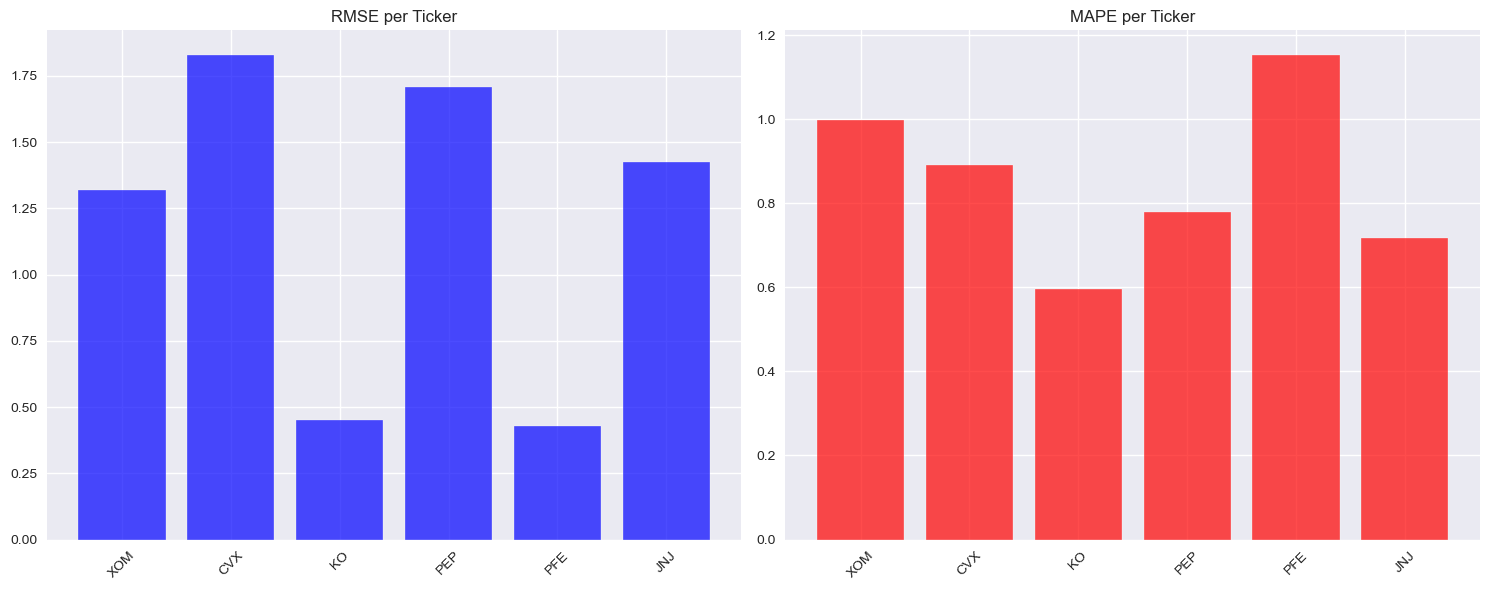

In [71]:
# ANALISI ARIMA REFACTORIZZATA

class ARIMAAnalyzer:
    def __init__(self, train_months=80, test_months=30, forecast_months=10):
        self.config = {
            'train_months': train_months,
            'test_months': test_months,
            'forecast_months': forecast_months
        }
        self.colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    def _calculate_trading_config(self, data):
        #Calcola la configurazione giorni di trading.
        years_span = (data.index[-1] - data.index[0]).days / 365.25
        days_per_month = len(data) / (years_span * 12)

        required_months = sum(self.config.values())
        scale_factor = min(1.0, len(data) / (required_months * days_per_month))

        return {
            'training_days': int(self.config['train_months'] * days_per_month * scale_factor),
            'test_days': int(self.config['test_months'] * days_per_month * scale_factor),
            'forecast_days': int(self.config['forecast_months'] * days_per_month * scale_factor),
            'days_per_month': days_per_month * scale_factor
        }

    def _test_stationarity(self, series):
        #Test di stazionarietà combinato ADF e KPSS.
        try:
            adf_stat, adf_p = adfuller(series)[0:2]
            kpss_stat, kpss_p = kpss(series, regression='c')[0:2]
            return adf_p <= 0.05 and kpss_p >= 0.05
        except:
            return False

    def _grid_search_arima(self, data, max_order=3):
        #Ricerca parametri ARIMA ottimali.
        best_aic, best_order, best_model = float('inf'), None, None

        for order in itertools.product(range(max_order), range(max_order), range(max_order)):
            try:
                model = ARIMA(data, order=order).fit()
                if model.aic < best_aic:
                    best_aic, best_order, best_model = model.aic, order, model
            except:
                continue

        return best_aic, best_order, best_model

    def _calculate_metrics(self, actual, predicted):
        #Calcola tutte le metriche di errore.
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = np.mean(np.abs((actual - predicted) / np.where(actual == 0, 1e-8, actual))) * 100
        return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    def _create_diagnostic_plot(self, model, ticker_name):
        #Grafici diagnostici semplificati.
        try:
            residuals = model.resid[30:] # Skip burn-in

            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(f'Diagnostica ARIMA - {ticker_name}', fontsize=14)

            # Residui
            axes[0,0].plot(residuals, color=self.colors[0])
            axes[0,0].axhline(0, color='red', linestyle='--', alpha=0.7)
            axes[0,0].set_title('Residui')
            axes[0,0].grid(True, alpha=0.3)

            # Q-Q plot
            from scipy import stats
            stats.probplot(residuals, dist="norm", plot=axes[0,1])
            axes[0,1].set_title('Q-Q Plot')
            axes[0,1].grid(True, alpha=0.3)

            # ACF e PACF
            from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
            plot_acf(residuals, ax=axes[1,0], lags=min(20, len(residuals)//4))
            plot_pacf(residuals, ax=axes[1,1], lags=min(20, len(residuals)//4))

            plt.tight_layout()
            plt.show()

            # Test Ljung-Box
            lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
            print(f"Ljung-Box p-value: {lb_test['lb_pvalue'].min():.4f}")
            print()

        except Exception as e:
            print(f"Errore diagnostica per {ticker_name}: {e}")

    def analyze_ticker(self, data, ticker_name):
        #Analisi ARIMA completa per un singolo ticker.
        print(f"\n--- {ticker_name} ---")

        # Configurazione dinamica
        config = self._calculate_trading_config(data)
        train_end = config['training_days']
        test_end = train_end + config['test_days']
        forecast_end = test_end + config['forecast_days']

        if len(data) < forecast_end:
            print(f"Dati insufficienti per {ticker_name}")
            return None

        # Divisione dati
        train_data = data.iloc[:train_end].values.ravel()
        test_data = data.iloc[train_end:test_end].values.ravel()
        forecast_data = data.iloc[test_end:forecast_end].values.ravel()

        # Test stazionarietà
        is_stationary = self._test_stationarity(train_data)
        print(f"Stazionario: {'Sì' if is_stationary else 'No'}")

        # Ricerca parametri ottimali
        best_aic, best_order, best_model = self._grid_search_arima(train_data)
        if best_order is None:
            print(f"Impossibile trovare parametri validi per {ticker_name}")
            return None

        print(f"Modello ottimale: ARIMA{best_order} (AIC: {best_aic:.3f})")

        # Diagnostica
        self._create_diagnostic_plot(best_model, ticker_name)

        # Test forecast
        test_forecast = best_model.forecast(steps=len(test_data))
        test_metrics = self._calculate_metrics(test_data, test_forecast)

        # Previsione ricorsiva
        predictions = []
        current_data = np.concatenate([train_data, test_data])

        for i in range(len(forecast_data)):
            try:
                model = ARIMA(current_data, order=best_order).fit()
                pred = model.forecast(steps=1)[0]
                predictions.append(pred)
                current_data = np.append(current_data, forecast_data[i])
            except:
                predictions.append(predictions[-1] if predictions else 0)

        predictions = np.array(predictions)

        # Previsione diretta
        try:
            extended_model = ARIMA(current_data[:-len(forecast_data)], order=best_order).fit()
            direct_forecast = extended_model.forecast(steps=len(forecast_data))
        except:
            direct_forecast = np.zeros(len(forecast_data))

        # Metriche finali
        recursive_metrics = self._calculate_metrics(forecast_data, predictions)
        direct_metrics = self._calculate_metrics(forecast_data, direct_forecast)

        # Visualizzazione
        self._plot_results(data, ticker_name, best_order, config,
                          forecast_data, predictions, direct_forecast)

        # Risultati
        print(f"Metriche Test - RMSE: {test_metrics['RMSE']:.4f}, MAPE: {test_metrics['MAPE']:.2f}%")
        print(f"Metriche Ricorsive - RMSE: {recursive_metrics['RMSE']:.4f}, MAPE: {recursive_metrics['MAPE']:.2f}%")
        print(f"Metriche Dirette - RMSE: {direct_metrics['RMSE']:.4f}, MAPE: {direct_metrics['MAPE']:.2f}%")

        return {
            'ticker': ticker_name,
            'model_params': best_order,
            'aic': best_aic,
            'is_stationary': is_stationary,
            'test_metrics': test_metrics,
            'recursive_metrics': recursive_metrics,
            'direct_metrics': direct_metrics,
            'actual_values': forecast_data,
            'recursive_forecast': predictions,
            'direct_forecast': direct_forecast,
            'config': config
        }

    def _plot_results(self, data, ticker_name, order, config, actual, recursive, direct):
        #Visualizzazione risultati semplificata.
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))

        # Setup indici
        test_end = config['training_days'] + config['test_days']
        forecast_end = test_end + config['forecast_days']
        context_start = max(0, test_end - int(12 * config['days_per_month']))

        context_data = data.iloc[context_start:test_end]
        forecast_index = data.iloc[test_end:forecast_end].index

        # Grafico 1: Serie temporale e previsioni
        axes[0].plot(context_data.index, context_data.values,
                    label='Dati Storici', color='blue', linewidth=2)
        axes[0].plot(forecast_index, actual,
                    label='Valori Reali', color='orange', linewidth=2)
        axes[0].plot(forecast_index, recursive,
                    label='Previsioni Ricorsive', color='red', linestyle='--', linewidth=2)
        axes[0].plot(forecast_index, direct,
                    label='Previsioni Dirette', color='green', linestyle=':', linewidth=2)

        axes[0].axvline(x=forecast_index[0], color='red', linestyle=':', alpha=0.7)
        axes[0].set_title(f'Previsioni ARIMA{order} - {ticker_name}', fontsize=14)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Grafico 2: Errori
        error_recursive = np.abs(actual - recursive)
        error_direct = np.abs(actual - direct)

        axes[1].plot(forecast_index, error_recursive,
                    label=f'Errore Ricorsivo (RMSE: {np.sqrt(np.mean(error_recursive**2)):.4f})',
                    color='red', linewidth=2)
        axes[1].plot(forecast_index, error_direct,
                    label=f'Errore Diretto (RMSE: {np.sqrt(np.mean(error_direct**2)):.4f})',
                    color='green', linewidth=2)

        axes[1].set_title('Confronto Errori di Previsione', fontsize=14)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def analyze_portfolio(self, prices_df, tickers):
        #Analisi ARIMA per portfolio completo.
        print("=== ANALISI ARIMA PORTFOLIO ===")
        print(f"Configurazione: {self.config['train_months']}/{self.config['test_months']}/{self.config['forecast_months']} mesi")

        results = {}
        summary_data = []

        for ticker in tickers:
            if ticker not in prices_df.columns:
                print(f"Ticker {ticker} non trovato nei dati")
                continue

            ticker_data = prices_df[ticker].dropna()
            result = self.analyze_ticker(ticker_data, ticker)

            if result:
                results[ticker] = result
                summary_data.append({
                    'Ticker': ticker,
                    'Modello': f'ARIMA{result["model_params"]}',
                    'AIC': result['aic'],
                    'RMSE_Test': result['test_metrics']['RMSE'],
                    'RMSE_Ricorsivo': result['recursive_metrics']['RMSE'],
                    'RMSE_Diretto': result['direct_metrics']['RMSE'],
                    'MAPE_Ricorsivo': result['recursive_metrics']['MAPE'],
                    'Stazionario': 'Sì' if result['is_stationary'] else 'No'
                })

        if summary_data:
            summary_df = pd.DataFrame(summary_data)

            print("\n=== RIEPILOGO PERFORMANCE ===")
            display_df = summary_df[['Ticker', 'Modello', 'RMSE_Ricorsivo', 'MAPE_Ricorsivo', 'Stazionario']].copy()
            display_df['RMSE_Ricorsivo'] = display_df['RMSE_Ricorsivo'].round(4)
            display_df['MAPE_Ricorsivo'] = display_df['MAPE_Ricorsivo'].round(2)

            print(f"{'*'*80}")
            print(tabulate(display_df, headers='keys', tablefmt='grid', showindex=False))

            print(f"\nStatistiche aggregate:")
            print(f"RMSE medio: {summary_df['RMSE_Ricorsivo'].mean():.4f}")
            print(f"MAPE medio: {summary_df['MAPE_Ricorsivo'].mean():.2f}%")
            print(f"Migliore RMSE: {summary_df.loc[summary_df['RMSE_Ricorsivo'].idxmin(), 'Ticker']}")

            # Grafico comparativo
            if len(summary_df) > 1:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

                ax1.bar(range(len(summary_df)), summary_df['RMSE_Ricorsivo'],
                       color='blue', alpha=0.7)
                ax1.set_title('RMSE per Ticker')
                ax1.set_xticks(range(len(summary_df)))
                ax1.set_xticklabels(summary_df['Ticker'], rotation=45)

                ax2.bar(range(len(summary_df)), summary_df['MAPE_Ricorsivo'],
                       color='red', alpha=0.7)
                ax2.set_title('MAPE per Ticker')
                ax2.set_xticks(range(len(summary_df)))
                ax2.set_xticklabels(summary_df['Ticker'], rotation=45)

                plt.tight_layout()
                plt.show()

            return results, summary_df

        return None, None

#Funzione principale per eseguire l'analisi ARIMA.
def run_arima_analysis(prices_df=None, tickers=None):
    # Verifica prerequisiti
    if prices_df is None:
        if 'prices' not in globals():
            print("ERRORE: DataFrame 'prices' non trovato!")
            print("Definire: prices = pd.DataFrame con i dati dei prezzi")
            return None, None
        prices_df = globals()['prices']

    if tickers is None:
        if 'tickers' not in globals():
            print("ERRORE: Lista 'tickers' non trovata!")
            print("Definire: tickers = ['AAPL', 'GOOGL', ...]")
            return None, None
        tickers = globals()['tickers']

    # Esecuzione analisi
    analyzer = ARIMAAnalyzer()
    return analyzer.analyze_portfolio(prices_df, tickers)

# Esecuzione automatica se i prerequisiti sono disponibili
if __name__ == "__main__":
    results, summary = run_arima_analysis()

STRATEGIA DIFENSIVA COCA-COLA (KO)
Dati allineati: 2516 osservazioni (2014-06-02 - 2024-05-29)
KO preso dal dataset prices, SPY/VIX/XLP scaricati per stesso periodo
Segnali generati: 1 Strong Buy, 4 Moderate Buy, 3 Sell
Backtesting completato: 18 trades, Valore finale: $160,661 vs BH: $207,430

RISULTATI STRATEGIA KO
Rendimento Strategia:      60.66%
Rendimento Buy & Hold:    107.43%
Outperformance:           -46.77%
Volatilità (S/BH):         10.82% /   17.88%
Sharpe (S/BH):             0.308 /   0.387
Max DD (S/BH):            -20.13% /  -36.99%
Numero Trades:                18


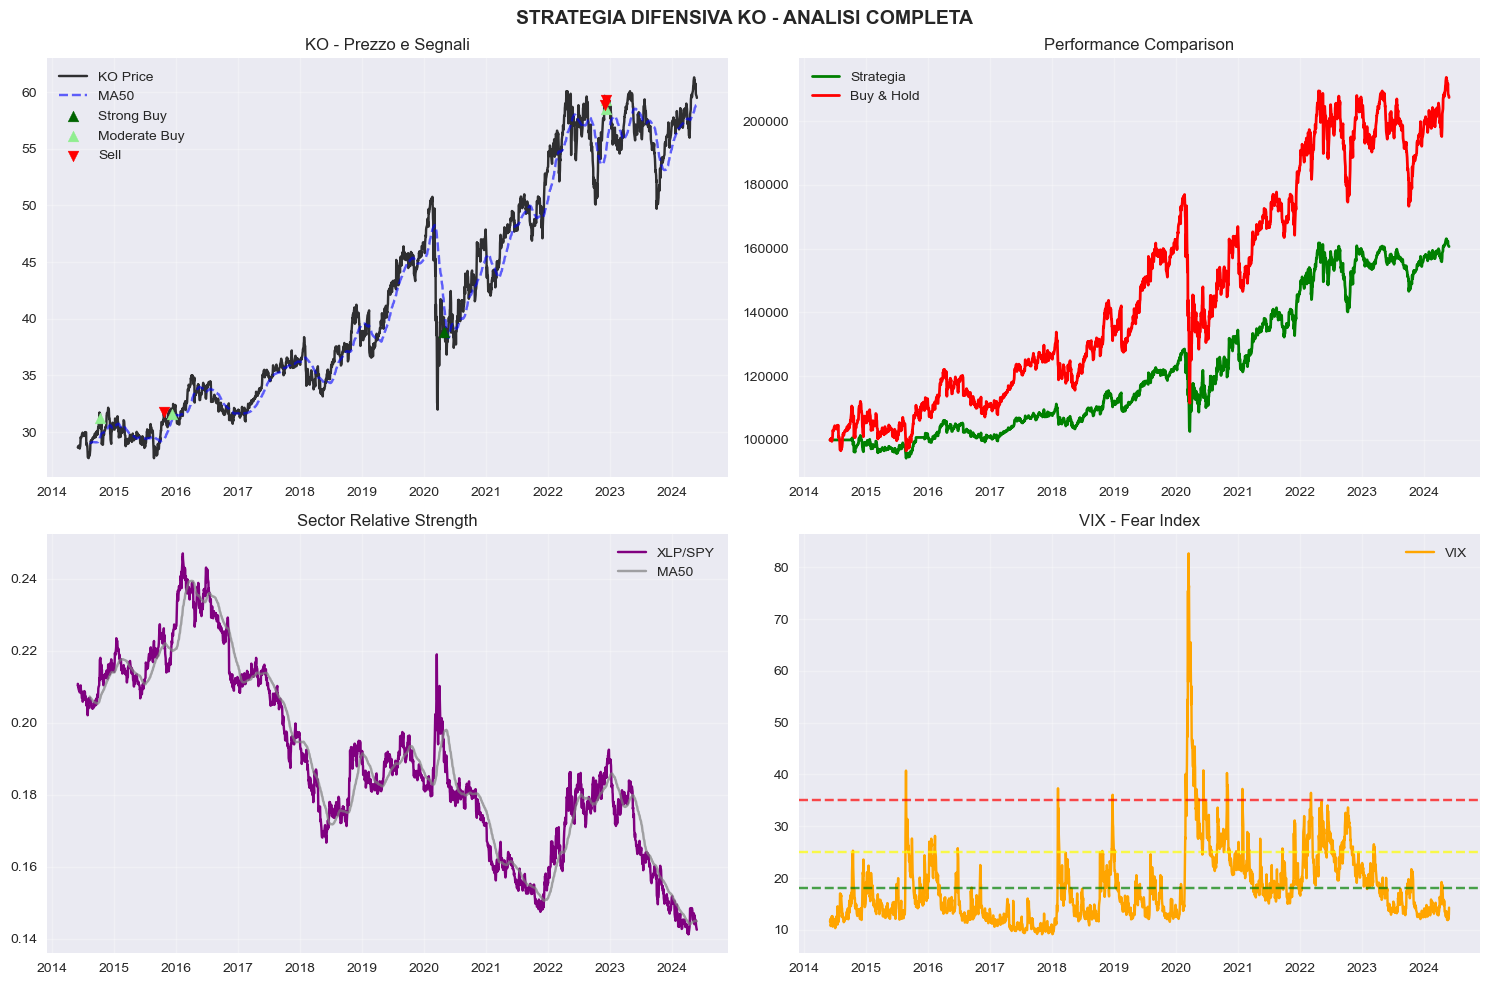


La strategia ha sottoperformato il Buy & Hold di 46.77 punti percentuali.


In [72]:
class KODefensiveStrategy:

    def __init__(self, capital=100000, cost=0.001, start_date="2020-01-01"):
        self.capital = capital
        self.cost = cost
        self.start_date = start_date

    def download_data(self, prices_df=None):
        print("STRATEGIA DIFENSIVA COCA-COLA (KO)")
        print("=" * 58)

        if prices_df is None:
            raise ValueError("È necessario fornire il DataFrame prices con i dati di KO")

        # Estrai KO dal DataFrame prices
        if isinstance(prices_df.columns, pd.MultiIndex):
            # Se MultiIndex, cerca KO nel primo livello
            ko_columns = [col for col in prices_df.columns if 'KO' in str(col)]
            if ko_columns:
                self.ko = prices_df[ko_columns[0]].dropna()
            else:
                raise ValueError("KO non trovato nel DataFrame prices")
        else:
            # Se colonne semplici
            self.ko = prices_df['KO'].dropna()

        # Scarica gli altri dati necessari (SPY, VIX, XLP) per il periodo di KO
        start_date = self.ko.index[0].strftime('%Y-%m-%d')
        end_date = self.ko.index[-1].strftime('%Y-%m-%d')

        other_data = yf.download(['SPY', '^VIX', 'XLP'], start=start_date, end=end_date, progress=False)

        # Estrai prezzi di chiusura
        if isinstance(other_data.columns, pd.MultiIndex):
            self.spy = other_data['Close']['SPY'].dropna()
            self.vix = other_data['Close']['^VIX'].dropna()
            self.xlp = other_data['Close']['XLP'].dropna()
        else:
            # Fallback per single ticker downloads
            self.spy = other_data['Close'].dropna() if len(other_data.columns) == 1 else other_data['SPY'].dropna()

        # Allinea tutte le date
        common_dates = self.ko.index.intersection(self.spy.index).intersection(self.vix.index).intersection(self.xlp.index)
        self.ko = self.ko[common_dates]
        self.spy = self.spy[common_dates]
        self.vix = self.vix[common_dates]
        self.xlp = self.xlp[common_dates]

        print(f"Dati allineati: {len(self.ko)} osservazioni ({self.ko.index[0].date()} - {self.ko.index[-1].date()})")
        print(f"KO preso dal dataset prices, SPY/VIX/XLP scaricati per stesso periodo")
        return self

    def calculate_indicators(self):
        # Moving averages
        self.ko_ma50 = self.ko.rolling(50).mean()
        self.ko_ma200 = self.ko.rolling(200).mean()

        # Sector strength
        xlp_spy_ratio = self.xlp / self.spy
        xlp_spy_ma = xlp_spy_ratio.rolling(50).mean()

        # Condizioni di mercato (return boolean series directly)
        conditions = {
            'sector_strong': xlp_spy_ratio > xlp_spy_ma * 1.005,
            'sector_weak': xlp_spy_ratio < xlp_spy_ma * 0.995,
            'vix_high': self.vix > 25,
            'vix_extreme': self.vix > 35,
            'vix_low': self.vix < 18,
            'ko_oversold': self.ko < self.ko_ma50 * 0.97,
            'ko_deep_oversold': self.ko < self.ko_ma200 * 0.93,
            'ko_overbought': self.ko > self.ko_ma50 * 1.08,
            'bull_market': self.spy > self.spy.rolling(200).mean(),
            'vol_falling': self.vix < self.vix.rolling(20).mean() * 0.8,
            'vol_rising': self.vix > self.vix.rolling(20).mean() * 1.2
        }

        self.conditions = pd.DataFrame(conditions, index=self.ko.index).fillna(False)
        return self

    def generate_signals(self):
        #Genera segnali di trading
        c = self.conditions  # Shorthand

        # Logica segnali
        strong_buy = (
            (c.vix_extreme & c.ko_oversold) |
            (c.sector_strong & c.ko_deep_oversold) |
            (c.vix_high & c.ko_deep_oversold & c.bull_market)
        )

        moderate_buy = (
            (c.bull_market & c.ko_oversold & c.vol_falling) |
            (c.sector_strong & ~c.ko_overbought & ~c.vix_low) |
            (c.vix_high & c.ko_oversold & ~c.sector_weak)
        )

        sell = (
            (c.vix_low & c.ko_overbought) |
            (c.sector_weak & c.ko_overbought & c.vol_rising) |
            (~c.bull_market & c.ko_overbought)
        )

        # Crea segnali e pulisci
        signals = pd.Series(0, index=self.ko.index)
        signals[strong_buy] = 2
        signals[moderate_buy] = 1
        signals[sell] = -1

        self.signals = self._clean_signals(signals)

        print(f"Segnali generati: {(self.signals==2).sum()} Strong Buy, "
              f"{(self.signals==1).sum()} Moderate Buy, {(self.signals==-1).sum()} Sell")
        return self

    def _clean_signals(self, signals):
        #Pulisce segnali per evitare ridondanza
        clean = signals.copy()
        position = 0

        for i, signal in enumerate(signals):
            if signal == 2 and position < 2:
                position = 2
            elif signal == 1 and position == 0:
                position = 1
            elif signal == -1 and position > 0:
                position = 0
            else:
                clean.iloc[i] = 0

        return clean

    def backtest(self):
        #Backtesting ottimizzato con position sizing
        cash, shares = self.capital, 0
        portfolio_values, trades = [], []
        target_exposure = 0  # Mantieni state tra iterazioni

        for i, (price, signal) in enumerate(zip(self.ko, self.signals)):
            # Aggiorna target exposure solo quando c'è un segnale
            if signal == 2:
                target_exposure = 0.8
            elif signal == 1:
                target_exposure = 0.5
            elif signal == -1:
                target_exposure = 0.0
            # Se signal == 0, mantieni target_exposure precedente

            # Calcola rebalancing
            portfolio_value = cash + shares * price
            target_shares = (portfolio_value * target_exposure) / price if price > 0 else 0
            diff_shares = target_shares - shares

            # Esegui trade se differenza significativa
            if abs(diff_shares * price) > portfolio_value * 0.03:
                trade_value = abs(diff_shares * price)
                transaction_cost = trade_value * self.cost

                if diff_shares > 0:  # Buy
                    total_cost = trade_value + transaction_cost
                    if cash >= total_cost:
                        cash -= total_cost
                        shares += diff_shares
                        trades.append({
                            'date': self.ko.index[i],
                            'action': 'BUY',
                            'price': price,
                            'shares': diff_shares,
                            'target_exposure': target_exposure
                        })

                elif diff_shares < 0:  # Sell
                    shares_to_sell = abs(diff_shares)
                    gross_proceeds = shares_to_sell * price
                    net_proceeds = gross_proceeds - transaction_cost
                    cash += net_proceeds
                    shares -= shares_to_sell
                    trades.append({
                        'date': self.ko.index[i],
                        'action': 'SELL',
                        'price': price,
                        'shares': shares_to_sell,
                        'target_exposure': target_exposure
                    })

            portfolio_values.append(cash + shares * price)

        # Salva risultati
        self.portfolio = pd.Series(portfolio_values, index=self.ko.index)
        self.trades = trades
        self.final_value = cash + shares * self.ko.iloc[-1]
        self.buy_hold_value = self.capital * (self.ko.iloc[-1] / self.ko.iloc[0])

        print(f"Backtesting completato: {len(trades)} trades, "
              f"Valore finale: ${self.final_value:,.0f} vs BH: ${self.buy_hold_value:,.0f}")
        return self

    def calculate_metrics(self):
        # Returns
        strategy_return = (self.final_value / self.capital - 1) * 100
        bh_return = (self.buy_hold_value / self.capital - 1) * 100
        outperformance = strategy_return - bh_return

        # Risk metrics
        strategy_rets = self.portfolio.pct_change().dropna()
        bh_rets = (self.capital * self.ko / self.ko.iloc[0]).pct_change().dropna()

        strategy_vol = strategy_rets.std() * np.sqrt(252) * 100
        bh_vol = bh_rets.std() * np.sqrt(252) * 100

        # Sharpe ratios
        strategy_sharpe = (strategy_rets.mean() * 252 - 0.02) / (strategy_rets.std() * np.sqrt(252))
        bh_sharpe = (bh_rets.mean() * 252 - 0.02) / (bh_rets.std() * np.sqrt(252))

        # Max drawdowns
        strategy_dd = ((self.portfolio - self.portfolio.expanding().max()) / self.portfolio.expanding().max()).min() * 100
        bh_portfolio = self.capital * self.ko / self.ko.iloc[0]
        bh_dd = ((bh_portfolio - bh_portfolio.expanding().max()) / bh_portfolio.expanding().max()).min() * 100

        # Store metrics
        self.metrics = {
            'strategy_return': strategy_return,
            'bh_return': bh_return,
            'outperformance': outperformance,
            'strategy_vol': strategy_vol,
            'bh_vol': bh_vol,
            'strategy_sharpe': strategy_sharpe,
            'bh_sharpe': bh_sharpe,
            'strategy_dd': strategy_dd,
            'bh_dd': bh_dd
        }

        return self

    def print_results(self):
        m = self.metrics
        print(f"\nRISULTATI STRATEGIA KO")
        print("=" * 30)
        print(f"Rendimento Strategia:    {m['strategy_return']:7.2f}%")
        print(f"Rendimento Buy & Hold:   {m['bh_return']:7.2f}%")
        print(f"Outperformance:          {m['outperformance']:7.2f}%")
        print(f"Volatilità (S/BH):       {m['strategy_vol']:7.2f}% / {m['bh_vol']:7.2f}%")
        print(f"Sharpe (S/BH):           {m['strategy_sharpe']:7.3f} / {m['bh_sharpe']:7.3f}")
        print(f"Max DD (S/BH):           {m['strategy_dd']:7.2f}% / {m['bh_dd']:7.2f}%")
        print(f"Numero Trades:           {len(self.trades):7d}")

    def plot_results(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Prezzo e segnali
        ax1 = axes[0,0]
        ax1.plot(self.ko, 'k-', label='KO Price', alpha=0.8)
        ax1.plot(self.ko_ma50, 'b--', alpha=0.6, label='MA50')

        # Segnali
        for signal, color, marker, label in [(2, 'darkgreen', '^', 'Strong Buy'),
                                           (1, 'lightgreen', '^', 'Moderate Buy'),
                                           (-1, 'red', 'v', 'Sell')]:
            dates = self.signals[self.signals == signal].index
            if len(dates) > 0:
                ax1.scatter(dates, self.ko[dates], c=color, marker=marker, s=60, label=label, zorder=5)

        ax1.set_title('KO - Prezzo e Segnali')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Performance comparison
        ax2 = axes[0,1]
        bh_portfolio = self.capital * self.ko / self.ko.iloc[0]
        ax2.plot(self.portfolio, 'g-', linewidth=2, label='Strategia')
        ax2.plot(bh_portfolio, 'r-', linewidth=2, label='Buy & Hold')
        ax2.set_title('Performance Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Sector strength
        ax3 = axes[1,0]
        xlp_spy = self.xlp / self.spy
        ax3.plot(xlp_spy, 'purple', label='XLP/SPY')
        ax3.plot(xlp_spy.rolling(50).mean(), 'gray', alpha=0.7, label='MA50')
        ax3.set_title('Sector Relative Strength')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # VIX
        ax4 = axes[1,1]
        ax4.plot(self.vix, 'orange', label='VIX')
        for level, color in [(18, 'green'), (25, 'yellow'), (35, 'red')]:
            ax4.axhline(level, color=color, linestyle='--', alpha=0.7)
        ax4.set_title('VIX - Fear Index')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.suptitle('STRATEGIA DIFENSIVA KO - ANALISI COMPLETA', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def run(self, prices_df=None):
        #Esegue l'intera strategia
        return (self.download_data(prices_df)
                   .calculate_indicators()
                   .generate_signals()
                   .backtest()
                   .calculate_metrics())

# ESECUZIONE STRATEGIA
if __name__ == "__main__":
    strategy = KODefensiveStrategy()
    strategy.run(prices_df=prices)  # Passa il DataFrame prices esistente
    strategy.print_results()
    strategy.plot_results()

    print(f"\nLa strategia ha {'sovraperformato' if strategy.metrics['outperformance'] > 0 else 'sottoperformato'} "
          f"il Buy & Hold di {abs(strategy.metrics['outperformance']):.2f} punti percentuali.")

✓ Usando DataFrame 'prices' esistente
ANALISI CAPM E FAMA-FRENCH
Dati preparati: 119 mesi, 6 titoli
Eseguendo analisi CAPM...
CAPM completato per 6 titoli
Eseguendo analisi Fama-French...
Fama-French completato per 6 titoli

                     RISULTATI ANALISI                      

CAPM RESULTS:
         Beta Expected_Return R_squared  Risk_Class
XOM  0.944011        0.076921  0.280209   Difensivo
CVX  1.081282        0.084471  0.368815  Aggressivo
KO   0.561395        0.055877  0.296381   Difensivo
PEP   0.55092        0.055301  0.323558   Difensivo
PFE  0.670003         0.06185  0.205732   Difensivo
JNJ  0.578765        0.056832  0.327001   Difensivo

Beta Stats: Mean=0.731, Range=0.551-1.081

FAMA-FRENCH 3F RESULTS:
    Market_Beta Size_Factor Value_Factor R_squared
XOM    0.876665     0.06745     1.031874   0.52355
CVX    1.022638   -0.004162     0.947413   0.57173
KO     0.623135   -0.722708     0.218912  0.443722
PEP    0.592454   -0.566472     0.032576   0.39338
PFE    0.703

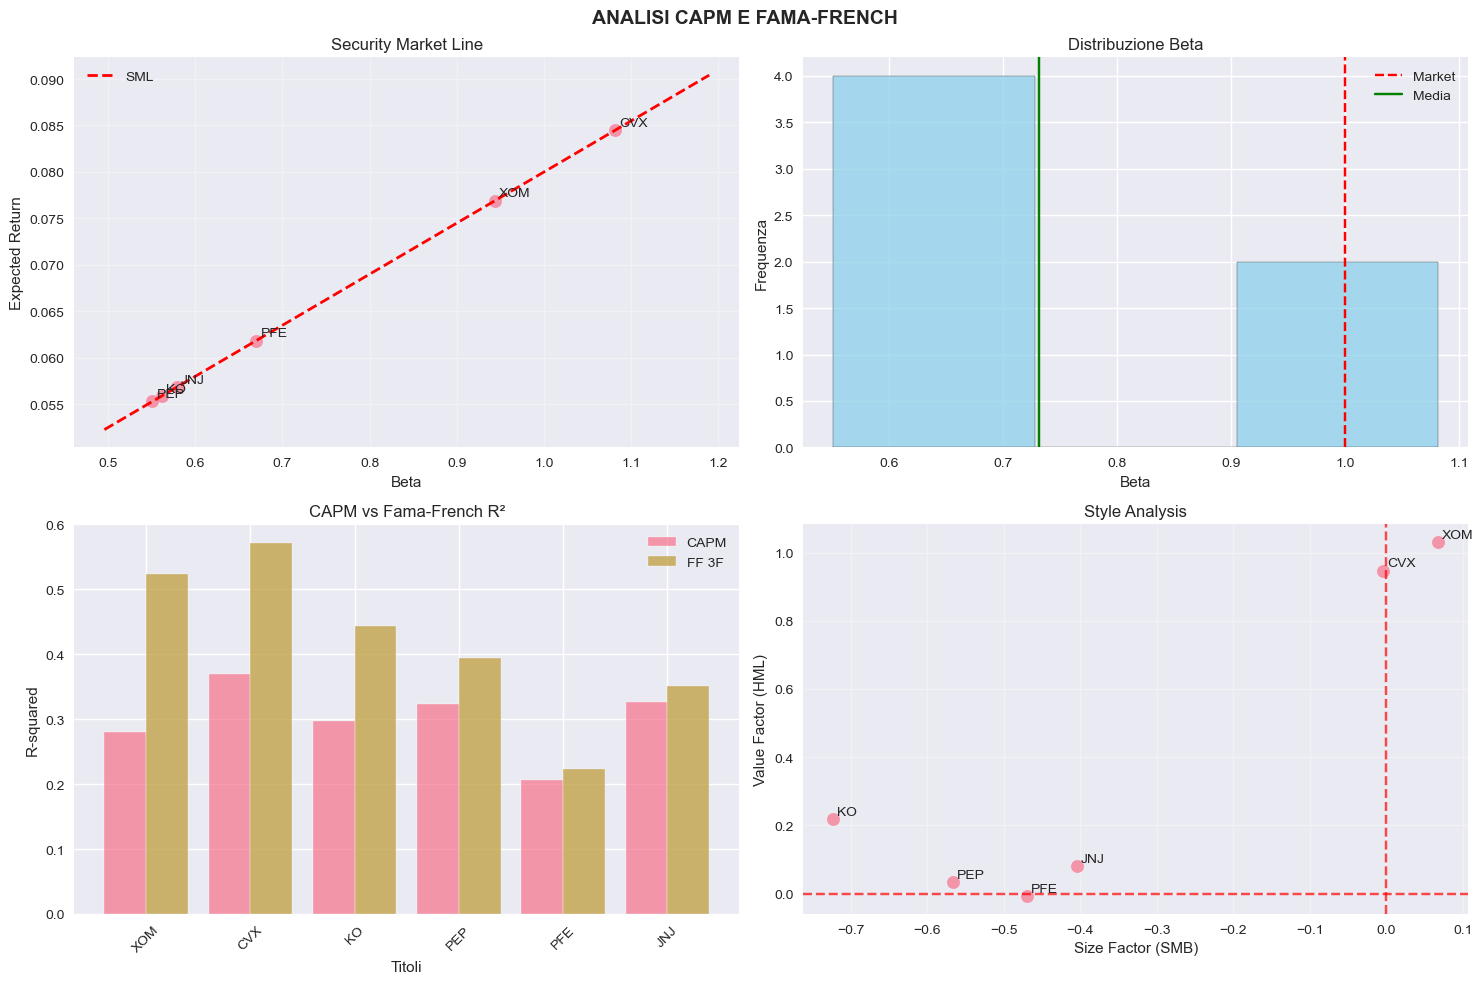


✓ ANALISI COMPLETATA - Risultati salvati in 'punto5_results'


In [73]:
# ANALISI CAPM E FAMA-FRENCH

# Configurazione
def get_config():
    try:
        return {
            'tickers': tickers,
            'start_date': start_date,
            'end_date': end_date,
            'market_index': '^GSPC',
            'risk_free_rate': 0.025,
            'market_forecast': 0.08
        }
    except NameError:
        return {
            'tickers': ['XOM', 'CVX', 'KO', 'PEP', 'PFE', 'JNJ'],
            'start_date': '2014-05-31',
            'end_date': '2024-05-31',
            'market_index': '^GSPC',
            'risk_free_rate': 0.025,
            'market_forecast': 0.08
        }

CONFIG = get_config()

def clean_dataframe_columns(df):
    #Pulisce le colonne del DataFrame
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    elif any(isinstance(col, tuple) for col in df.columns):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    return df

def prepare_data(prices_df):
    # Pulisci colonne e scarica mercato
    prices_df = clean_dataframe_columns(prices_df)
    market_data = yf.download(CONFIG['market_index'],
                             start=CONFIG['start_date'],
                             end=CONFIG['end_date'],
                             progress=False, auto_adjust=True)['Close']

    # Combina e calcola rendimenti mensili
    all_prices = prices_df.copy()
    all_prices['Market'] = market_data
    monthly_prices = all_prices.resample('M').last().dropna()
    monthly_returns = monthly_prices.pct_change().dropna()

    # Separa componenti
    stock_tickers = [col for col in monthly_returns.columns
                    if col != 'Market' and col in CONFIG['tickers']]
    stock_returns = monthly_returns[stock_tickers]
    market_returns = monthly_returns['Market']
    risk_free = pd.Series(CONFIG['risk_free_rate']/12,
                         index=stock_returns.index, name='Risk_Free')

    # Allinea indici
    for series in [stock_returns, market_returns, risk_free]:
        series.index = series.index.to_period('M')

    print(f"Dati preparati: {len(stock_returns)} mesi, {len(stock_tickers)} titoli")
    return stock_returns, market_returns, risk_free

def calculate_regression(y, x):
    #Calcola regressione con gestione errori
    try:
        # Pulisci dati
        data = pd.DataFrame({'y': y, 'x': x}).replace([np.inf, -np.inf], np.nan).dropna()
        if len(data) < 10:
            return None

        # Regressione OLS
        slope, intercept, r_value, p_value, _ = stats.linregress(data['x'], data['y'])
        return {
            'alpha': intercept,
            'beta': slope,
            'r_squared': r_value ** 2,
            'p_value': p_value,
            'n_obs': len(data)
        }
    except:
        return None

def run_capm_analysis(stock_returns, market_returns, risk_free):
    print("Eseguendo analisi CAPM...")
    results = {}

    for ticker in stock_returns.columns:
        # Trova indici comuni e calcola excess returns
        common_idx = (stock_returns.index
                     .intersection(market_returns.index)
                     .intersection(risk_free.index))

        if len(common_idx) < 10:
            continue

        stock_excess = stock_returns.loc[common_idx, ticker] - risk_free.loc[common_idx]
        market_excess = market_returns.loc[common_idx] - risk_free.loc[common_idx]

        # Calcola regressione
        reg_result = calculate_regression(stock_excess, market_excess)
        if reg_result is None:
            continue

        # Metriche CAPM
        beta = reg_result['beta']
        expected_return = (CONFIG['risk_free_rate'] +
                          beta * (CONFIG['market_forecast'] - CONFIG['risk_free_rate']))

        results[ticker] = {
            'Beta': beta,
            'Alpha_Annual': reg_result['alpha'] * 12,
            'R_squared': reg_result['r_squared'],
            'Expected_Return': expected_return,
            'Risk_Class': 'Aggressivo' if beta > 1 else 'Difensivo',
            'Observations': reg_result['n_obs']
        }

    print(f"CAPM completato per {len(results)} titoli")
    return results

def get_fama_french_factors():
    #Scarica o genera fattori Fama-French
    if not FF_AVAILABLE:
        return generate_synthetic_ff()

    try:
        # Prova a scaricare fattori reali
        ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench',
                           CONFIG['start_date'], CONFIG['end_date'])[0] / 100
        try:
            ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench',
                               CONFIG['start_date'], CONFIG['end_date'])[0] / 100
            return pd.concat([ff3, ff5[['RMW', 'CMA']]], axis=1)
        except:
            return ff3
    except:
        return generate_synthetic_ff()

def generate_synthetic_ff():
    #Genera fattori sintetici
    dates = pd.date_range(CONFIG['start_date'], CONFIG['end_date'], freq='M')
    np.random.seed(42)

    return pd.DataFrame({
        'Mkt-RF': np.random.normal(0.008, 0.04, len(dates)),
        'SMB': np.random.normal(0.002, 0.02, len(dates)),
        'HML': np.random.normal(0.003, 0.03, len(dates)),
        'RF': CONFIG['risk_free_rate']/12,
        'RMW': np.random.normal(0.002, 0.02, len(dates)),
        'CMA': np.random.normal(-0.001, 0.02, len(dates))
    }, index=dates)

def run_fama_french_analysis(stock_returns, ff_factors):
    print("Eseguendo analisi Fama-French...")

    # Allinea indici
    for data in [stock_returns, ff_factors]:
        if isinstance(data.index, pd.DatetimeIndex):
            data.index = data.index.to_period('M')

    common_idx = stock_returns.index.intersection(ff_factors.index)
    stock_aligned = stock_returns.loc[common_idx]
    ff_aligned = ff_factors.loc[common_idx]

    results_3f = {}
    results_5f = {} if 'RMW' in ff_aligned.columns else None

    for ticker in stock_aligned.columns:
        try:
            stock_excess = stock_aligned[ticker] - ff_aligned['RF']

            # Modello 3F
            X_3f = sm.add_constant(ff_aligned[['Mkt-RF', 'SMB', 'HML']])
            model_3f = sm.OLS(stock_excess, X_3f).fit()

            results_3f[ticker] = {
                'Alpha_Annual': model_3f.params['const'] * 12,
                'Market_Beta': model_3f.params['Mkt-RF'],
                'Size_Factor': model_3f.params['SMB'],
                'Value_Factor': model_3f.params['HML'],
                'R_squared': model_3f.rsquared,
                'Style_Size': 'Small-cap' if model_3f.params['SMB'] > 0 else 'Large-cap',
                'Style_Value': 'Value' if model_3f.params['HML'] > 0 else 'Growth'
            }

            # Modello 5F se disponibile
            if results_5f is not None:
                X_5f = sm.add_constant(ff_aligned[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
                model_5f = sm.OLS(stock_excess, X_5f).fit()
                results_5f[ticker] = {
                    'R_squared': model_5f.rsquared,
                    'R_squared_improvement': model_5f.rsquared - model_3f.rsquared
                }
        except:
            continue

    print(f"Fama-French completato per {len(results_3f)} titoli")
    return results_3f, results_5f

def create_visualizations(capm_results, ff3_results):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('ANALISI CAPM E FAMA-FRENCH', fontsize=14, fontweight='bold')

    # Usa CAPM se disponibile, altrimenti FF3
    valid_capm = {k: v for k, v in capm_results.items() if v is not None}

    if valid_capm:
        betas = [v['Beta'] for v in valid_capm.values()]
        expected_rets = [v['Expected_Return'] for v in valid_capm.values()]
        tickers = list(valid_capm.keys())
    else:
        betas = [ff3_results[t]['Market_Beta'] for t in ff3_results.keys()]
        expected_rets = [CONFIG['risk_free_rate'] + b * (CONFIG['market_forecast'] - CONFIG['risk_free_rate'])
                        for b in betas]
        tickers = list(ff3_results.keys())

    # 1. Security Market Line
    ax1.scatter(betas, expected_rets, s=80, alpha=0.7)
    for i, ticker in enumerate(tickers):
        ax1.annotate(ticker, (betas[i], expected_rets[i]), xytext=(3, 3), textcoords='offset points')

    beta_range = np.linspace(min(betas)*0.9, max(betas)*1.1, 100)
    sml = CONFIG['risk_free_rate'] + beta_range * (CONFIG['market_forecast'] - CONFIG['risk_free_rate'])
    ax1.plot(beta_range, sml, 'r--', linewidth=2, label='SML')
    ax1.set_xlabel('Beta')
    ax1.set_ylabel('Expected Return')
    ax1.set_title('Security Market Line')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Distribuzione Beta
    ax2.hist(betas, bins=max(3, len(betas)//2), alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(1, color='red', linestyle='--', label='Market')
    ax2.axvline(np.mean(betas), color='green', linestyle='-', label='Media')
    ax2.set_xlabel('Beta')
    ax2.set_ylabel('Frequenza')
    ax2.set_title('Distribuzione Beta')
    ax2.legend()

    # 3. R-squared comparison
    if valid_capm and ff3_results:
        capm_r2 = [valid_capm[t]['R_squared'] for t in tickers if t in valid_capm]
        ff_r2 = [ff3_results[t]['R_squared'] for t in tickers if t in ff3_results]
        common_tickers = [t for t in tickers if t in valid_capm and t in ff3_results]

        x_pos = np.arange(len(common_tickers))
        ax3.bar(x_pos - 0.2, [valid_capm[t]['R_squared'] for t in common_tickers],
                0.4, label='CAPM', alpha=0.7)
        ax3.bar(x_pos + 0.2, [ff3_results[t]['R_squared'] for t in common_tickers],
                0.4, label='FF 3F', alpha=0.7)
        ax3.set_xlabel('Titoli')
        ax3.set_ylabel('R-squared')
        ax3.set_title('CAPM vs Fama-French R²')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(common_tickers, rotation=45)
        ax3.legend()

    # 4. Style Analysis
    if ff3_results:
        smb_vals = [ff3_results[t]['Size_Factor'] for t in ff3_results.keys()]
        hml_vals = [ff3_results[t]['Value_Factor'] for t in ff3_results.keys()]
        ff_tickers = list(ff3_results.keys())

        ax4.scatter(smb_vals, hml_vals, s=80, alpha=0.7)
        for i, ticker in enumerate(ff_tickers):
            ax4.annotate(ticker, (smb_vals[i], hml_vals[i]), xytext=(3, 3), textcoords='offset points')

        ax4.axhline(0, color='red', linestyle='--', alpha=0.7)
        ax4.axvline(0, color='red', linestyle='--', alpha=0.7)
        ax4.set_xlabel('Size Factor (SMB)')
        ax4.set_ylabel('Value Factor (HML)')
        ax4.set_title('Style Analysis')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_results(capm_results, ff3_results, ff5_results):
    print("\n" + "="*60)
    print("RISULTATI ANALISI".center(60))
    print("="*60)

    # CAPM Results
    valid_capm = {k: v for k, v in capm_results.items() if v is not None}
    if valid_capm:
        capm_df = pd.DataFrame(valid_capm).T
        print("\nCAPM RESULTS:")
        print(capm_df[['Beta', 'Expected_Return', 'R_squared', 'Risk_Class']].round(4))

        betas = capm_df['Beta']
        print(f"\nBeta Stats: Mean={betas.mean():.3f}, Range={betas.min():.3f}-{betas.max():.3f}")

    # Fama-French Results
    if ff3_results:
        ff3_df = pd.DataFrame(ff3_results).T
        print("\nFAMA-FRENCH 3F RESULTS:")
        print(ff3_df[['Market_Beta', 'Size_Factor', 'Value_Factor', 'R_squared']].round(4))

        if ff5_results:
            avg_improvement = np.mean([ff5_results[t]['R_squared_improvement']
                                     for t in ff5_results.keys()])
            print(f"\n5F Model Average R² Improvement: +{avg_improvement:.3f}")

    # Style Summary
    if ff3_results:
        print("\nSTYLE CLASSIFICATION:")
        for ticker in ff3_results.keys():
            size = ff3_results[ticker]['Style_Size']
            value = ff3_results[ticker]['Style_Value']
            print(f"{ticker}: {size} {value}")

def main(prices_df):
    print("ANALISI CAPM E FAMA-FRENCH")
    print("="*60)

    try:
        # Pipeline di analisi
        stock_returns, market_returns, risk_free = prepare_data(prices_df)
        capm_results = run_capm_analysis(stock_returns, market_returns, risk_free)
        ff_factors = get_fama_french_factors()
        ff3_results, ff5_results = run_fama_french_analysis(stock_returns, ff_factors)

        # Output
        print_results(capm_results, ff3_results, ff5_results)
        create_visualizations(capm_results, ff3_results)

        # Salva risultati
        results = {
            'capm': capm_results,
            'ff3': ff3_results,
            'ff5': ff5_results,
            'config': CONFIG
        }

        globals()['punto5_results'] = results
        print("\n✓ ANALISI COMPLETATA - Risultati salvati in 'punto5_results'")
        return results

    except Exception as e:
        print(f"✗ ERRORE: {e}")
        return None

# Funzioni di convenienza
def run_analysis():
    try:
        return main(prices)
    except NameError:
        print("ERRORE: DataFrame 'prices' non trovato!")
        return None

# Esecuzione
if __name__ == "__main__":
    try:
        if 'prices' in globals() and not prices.empty:
            print("✓ Usando DataFrame 'prices' esistente")
            main(prices)
        else:
            raise NameError("prices non trovato o vuoto")
    except NameError:
        prices_df = pd.DataFrame()
        for ticker in CONFIG['tickers']:
            try:
                data = yf.download(ticker, start=CONFIG['start_date'], end=CONFIG['end_date'],
                                 progress=False, auto_adjust=True)['Close']
                prices_df[ticker] = data
            except:
                continue

        if not prices_df.empty:
            prices_df.dropna(inplace=True)
            main(prices_df)
        else:
            print("Errore: Nessun dato scaricato")

STRATEGIE DINAMICHE
Dati: (119, 6) | 2014-07 - 2024-05

ESECUZIONE STRATEGIE

6.a - PERFORMANCE COMPARATIVE
+--------------+---------+--------+--------+----------+--------+----------+
| Strategia    | Tot     | Anno   | Vol    |   Sharpe | DD     | Valore   |
+==============+=========+========+========+==========+========+==========+
| Buy & Hold   | 108.94% | 7.71%  | 15.10% |    0.345 | 24.03% | $208,940 |
+--------------+---------+--------+--------+----------+--------+----------+
| Equal Weight | 110.94% | 7.82%  | 15.03% |    0.354 | 23.37% | $210,940 |
+--------------+---------+--------+--------+----------+--------+----------+
| Stop Loss    | 138.83% | 9.18%  | 13.90% |    0.48  | 12.62% | $238,826 |
+--------------+---------+--------+--------+----------+--------+----------+
| CPPI         | 77.19%  | 5.94%  | 11.46% |    0.3   | 18.13% | $177,186 |
+--------------+---------+--------+--------+----------+--------+----------+
| TPPI         | 71.91%  | 5.62%  | 9.90%  |    0.315 | 

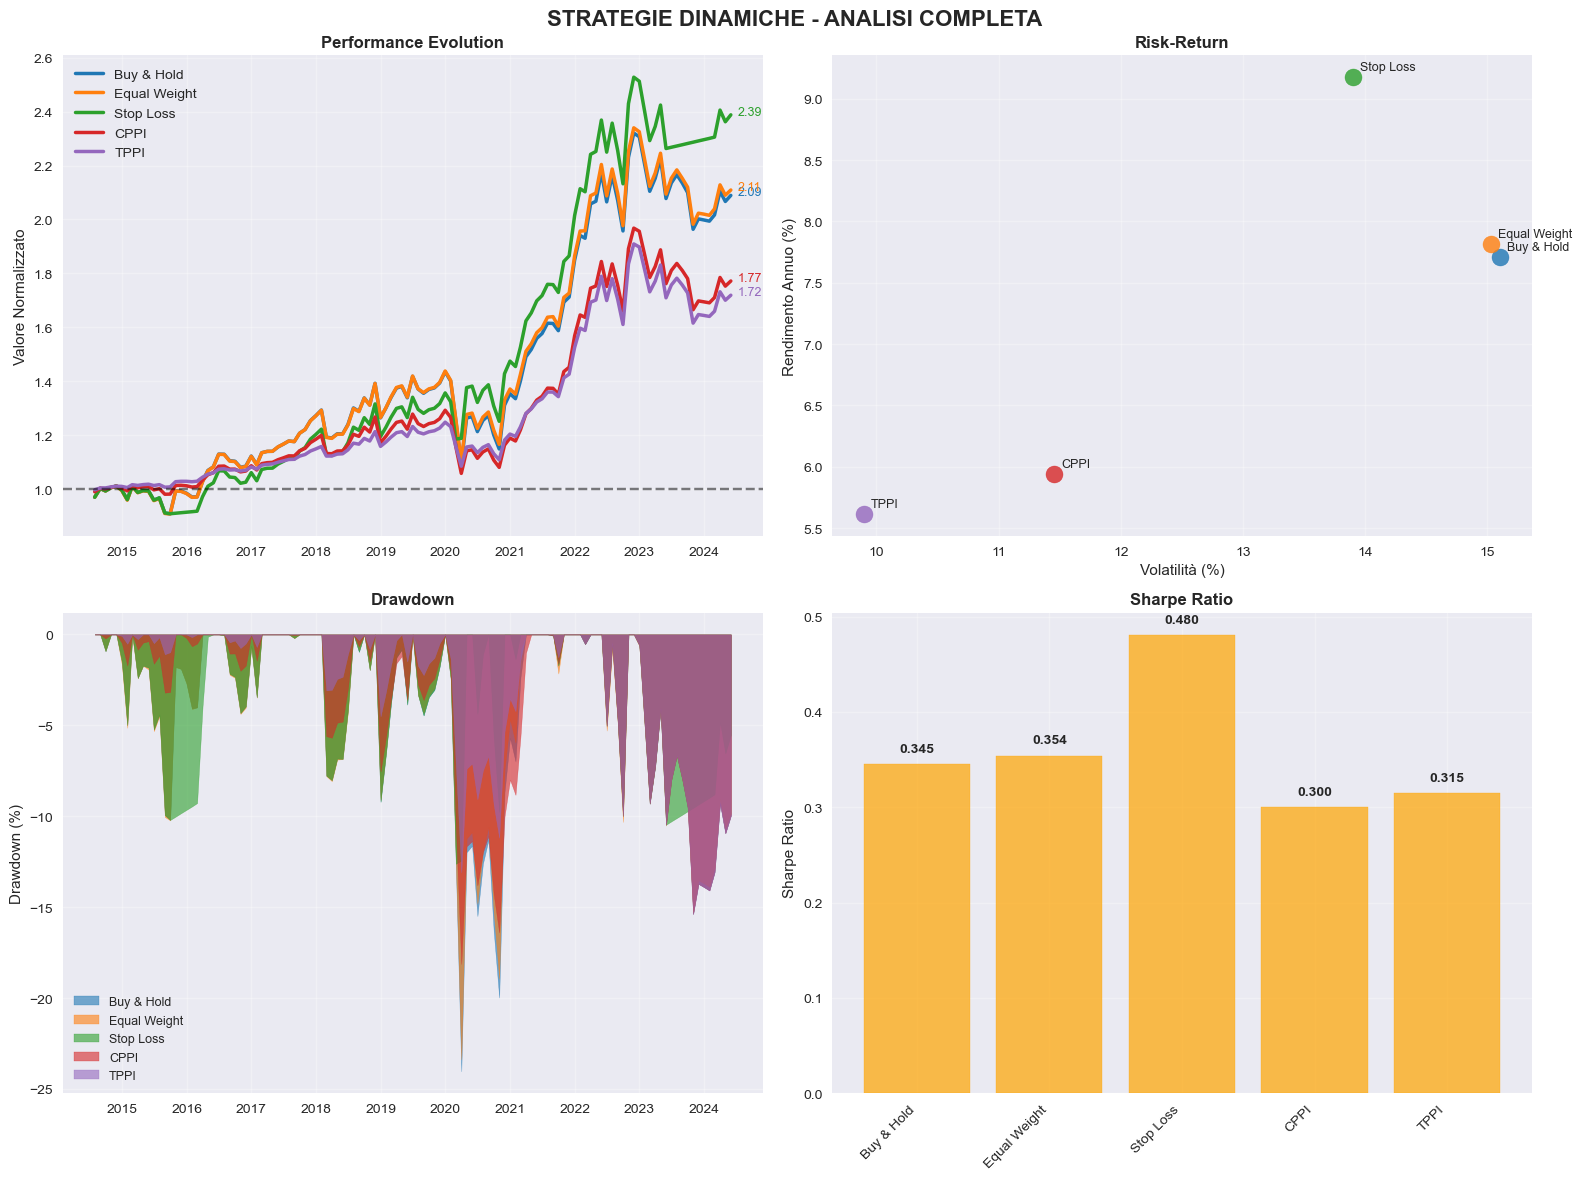

In [74]:
"""
PUNTO 6 - STRATEGIE DINAMICHE
Tutte le funzionalità in ~200 righe
"""
print("="*80)
print("STRATEGIE DINAMICHE")
print("="*80)

# Configurazione globale
CAPITAL, RF_RATE = 100000, 0.025
RF_MONTHLY = (1 + RF_RATE)**(1/12) - 1
PARAMS = {'ew_rebal': 3, 'sl_threshold': 0.10, 'cppi_mult': 2.5, 'floor_ratio': 0.85}

def prepare_data(input_data):
    """Prepara rendimenti mensili."""
    if input_data is None:
        np.random.seed(42)
        dates = pd.date_range('2020-01', '2024-12', freq='M')
        data = {f'Asset{i}': np.random.normal(0.01, 0.05, len(dates)) for i in range(6)}
        returns = pd.DataFrame(data, index=dates)
    else:
        returns = input_data.resample('M').last().pct_change().dropna()
        print(f"Dati: {returns.shape} | {returns.index[0].strftime('%Y-%m')} - {returns.index[-1].strftime('%Y-%m')}")
    return returns.replace([np.inf, -np.inf], np.nan).dropna()

def insurance_strategy(returns_eq, multiplier_func, floor_value):
    """Strategia unificata per CPPI/TPPI."""
    values, portfolio_val = [], CAPITAL
    for i, ret in enumerate(returns_eq):
        if pd.isna(ret):
            values.append(portfolio_val)
            continue
        cushion = max(portfolio_val - floor_value, 0)
        mult = multiplier_func(i)
        risky_alloc = min(mult * cushion / portfolio_val, 1.0) if cushion > 0 else 0.0
        risky_alloc = max(risky_alloc, 0.0)
        port_ret = risky_alloc * ret + (1 - risky_alloc) * RF_MONTHLY
        portfolio_val = max(floor_value, portfolio_val * (1 + port_ret))
        values.append(portfolio_val)
    return values

def run_all_strategies(returns):
    """Esegue tutte le strategie in modo ottimizzato."""
    print("\nESECUZIONE STRATEGIE")
    print("="*50)

    n_assets = len(returns.columns)
    equal_w = np.full(n_assets, 1.0/n_assets)
    returns_eq = (returns * equal_w).sum(axis=1)  # Precalcola rendimenti equal-weight
    floor_val = CAPITAL * PARAMS['floor_ratio']
    total_periods = len(returns)

    results = {}

    # 1. Buy & Hold
    bh_val = CAPITAL
    bh_values = []
    for ret in returns_eq:
        bh_val *= (1 + ret) if not pd.isna(ret) else 1
        bh_values.append(bh_val)
    results['Buy & Hold'] = bh_values

    # 2. Equal Weight (con ribilanciamento)
    ew_values, ew_val, weights = [], CAPITAL, equal_w.copy()

    for i, (_, row) in enumerate(returns.iterrows()):
        # Ribilanciamento periodico
        if i % PARAMS['ew_rebal'] == 0:
            weights = equal_w.copy()

        # Applica rendimenti agli asset individuali
        if not row.isna().any():
            asset_values = weights * ew_val * (1 + row)
            ew_val = asset_values.sum()

            # Aggiorna pesi (drift naturale)
            if ew_val > 0:
                weights = asset_values / ew_val

        ew_values.append(ew_val)
    results['Equal Weight'] = ew_values

    # 3. Stop Loss
    sl_values, sl_val, peak = [], CAPITAL, CAPITAL
    in_stop_loss = False

    for ret in returns_eq:
        if pd.isna(ret):
            sl_values.append(sl_val)
            continue

        if not in_stop_loss:
            dd = (sl_val - peak) / peak
            if dd < -PARAMS['sl_threshold']:
                sl_val *= (1 + RF_MONTHLY)
                in_stop_loss = True
            else:
                sl_val *= (1 + ret)
                peak = max(peak, sl_val)
        else:
            # Re-entry quando valore supera 95% del peak
            new_val_if_invested = sl_val * (1 + ret)
            if new_val_if_invested > peak * 0.95:
                sl_val = new_val_if_invested
                peak = max(peak, sl_val)
                in_stop_loss = False
            else:
                sl_val *= (1 + RF_MONTHLY)

        sl_values.append(sl_val)
    results['Stop Loss'] = sl_values

    # 4. CPPI
    cppi_mult = lambda i: PARAMS['cppi_mult']
    results['CPPI'] = insurance_strategy(returns_eq, cppi_mult, floor_val)

    # 5. TPPI
    tppi_mult = lambda i: 1 + (PARAMS['cppi_mult'] - 1) * (i/(total_periods-1))
    results['TPPI'] = insurance_strategy(returns_eq, tppi_mult, floor_val)

    return {k: pd.Series(v, index=returns.index) for k, v in results.items()}

def calc_metrics(values):
    """Calcola tutte le metriche."""
    rets = values.pct_change().dropna()
    total_ret = values.iloc[-1] / CAPITAL - 1
    periods = len(values)
    annual_ret = (1 + total_ret) ** (12/periods) - 1
    vol = rets.std() * np.sqrt(12)
    sharpe = (annual_ret - RF_RATE) / vol if vol > 0 else 0
    dd = 1 - (values / values.expanding().max()).min()
    win_rate = (rets > 0).mean()
    return {
        'Total Return': total_ret, 'Annual Return': annual_ret, 'Volatility': vol,
        'Sharpe': sharpe, 'Max DD': dd, 'Win Rate': win_rate, 'Final Value': values.iloc[-1]
    }

def create_analysis(results):
    """Analisi completa con tabelle."""
    # Calcola metriche
    metrics = {name: calc_metrics(values) for name, values in results.items()}

    # 6.a - Tabella Performance
    print("\n6.a - PERFORMANCE COMPARATIVE")
    perf_data = [[name, f"{m['Total Return']:.2%}", f"{m['Annual Return']:.2%}",
                  f"{m['Volatility']:.2%}", f"{m['Sharpe']:.3f}", f"{m['Max DD']:.2%}",
                  f"${m['Final Value']:,.0f}"] for name, m in metrics.items()]
    print(tabulate(perf_data, headers=['Strategia', 'Tot', 'Anno', 'Vol', 'Sharpe', 'DD', 'Valore'], tablefmt='grid'))

    # 6.b - Confronto Buy & Hold
    print(f"\n6.b - CONFRONTO BUY & HOLD")
    bh = metrics['Buy & Hold']
    print(f"Buy & Hold: {bh['Total Return']:.2%} | Sharpe {bh['Sharpe']:.3f} | DD {bh['Max DD']:.2%}")

    comp_data = []
    for name, m in metrics.items():
        if name == 'Buy & Hold': continue
        ret_diff = m['Total Return'] - bh['Total Return']
        sharpe_diff = m['Sharpe'] - bh['Sharpe']
        dd_diff = bh['Max DD'] - m['Max DD']
        outperf = '✓' if ret_diff > 0 and sharpe_diff > 0 else '✗'
        comp_data.append([name, f"{ret_diff:+.2%}", f"{sharpe_diff:+.3f}", f"{dd_diff:+.2%}", outperf])

    print(tabulate(comp_data, headers=['Strategia', 'Δ Ret', 'Δ Sharpe', 'Δ DD', 'Out'], tablefmt='simple'))

    # 6.c - Parametri
    print(f"\n6.c - PARAMETRI E SUGGERIMENTI")
    param_data = [
        ['Equal Weight', f"Rebal: {PARAMS['ew_rebal']}m", 'Testare 1-6 mesi'],
        ['Stop Loss', f"Soglia: {PARAMS['sl_threshold']:.1%}", 'Provare 5-15%'],
        ['CPPI', f"Mult: {PARAMS['cppi_mult']}, Floor: {PARAMS['floor_ratio']:.1%}", 'Mult 2-4'],
        ['TPPI', 'Mult crescente su periodo', 'Considerare risking progressivo']
    ]
    print(tabulate(param_data, headers=['Strategia', 'Parametri', 'Suggerimenti'], tablefmt='simple'))

    return metrics

def create_charts(results, metrics):
    """Grafici ottimizzati."""
    print("\nGRAFICI CHIAVE")
    print("="*30)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('STRATEGIE DINAMICHE - ANALISI COMPLETA', fontsize=16, fontweight='bold')

    # 1. Performance
    for i, (name, values) in enumerate(results.items()):
        norm = values / CAPITAL
        ax1.plot(norm.index, norm.values, label=name, linewidth=2.5, color=colors[i])
        ax1.annotate(f'{norm.iloc[-1]:.2f}', (norm.index[-1], norm.iloc[-1]),
                    xytext=(5, 0), textcoords='offset points', fontsize=9, color=colors[i])
    ax1.set_title('Performance Evolution', fontweight='bold')
    ax1.set_ylabel('Valore Normalizzato')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5)

    # 2. Risk-Return
    for i, (name, m) in enumerate(metrics.items()):
        ax2.scatter(m['Volatility']*100, m['Annual Return']*100, s=150,
                   label=name, color=colors[i], alpha=0.8)
        ax2.annotate(name, (m['Volatility']*100, m['Annual Return']*100),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    ax2.set_title('Risk-Return', fontweight='bold')
    ax2.set_xlabel('Volatilità (%)')
    ax2.set_ylabel('Rendimento Annuo (%)')
    ax2.grid(True, alpha=0.3)

    # 3. Drawdown
    for i, (name, values) in enumerate(results.items()):
        dd_series = (1 - values / values.expanding().max()) * 100
        ax3.fill_between(dd_series.index, -dd_series.values, 0, alpha=0.6,
                        label=name, color=colors[i])
    ax3.set_title('Drawdown', fontweight='bold')
    ax3.set_ylabel('Drawdown (%)')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Sharpe
    names = list(metrics.keys())
    sharpes = [metrics[name]['Sharpe'] for name in names]
    bars = ax4.bar(range(len(names)), sharpes, alpha=0.8)
    for bar, sharpe in zip(bars, sharpes):
        color = 'green' if sharpe > 0.5 else 'orange' if sharpe > 0.2 else 'red'
        bar.set_color(color)
        bar.set_alpha(0.7)
    ax4.set_title('Sharpe Ratio', fontweight='bold')
    ax4.set_ylabel('Sharpe Ratio')
    ax4.set_xticks(range(len(names)))
    ax4.set_xticklabels(names, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)
    for bar, value in zip(bars, sharpes):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01 if height >= 0 else height - 0.02,
                f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

    plt.tight_layout()
    plt.show()

def main_analysis(data_input=None):
    """Analisi completa ultra-compatta."""
    try:
        returns = prepare_data(data_input)
        results = run_all_strategies(returns)
        metrics = create_analysis(results)
        create_charts(results, metrics)

        return {'success': True, 'results': results, 'metrics': metrics}
    except Exception as e:
        print(f"Errore: {e}")
        return {'success': False}

# Auto-esecuzione
if __name__ == "__main__":
    try:
        data_source = prices if 'prices' in locals() or 'prices' in globals() else None
        results = main_analysis(data_source)
    except:
        results = main_analysis(None)